# I. Introduccion


# 1. Librerias

#### CODIGO

In [1]:
! pip install pennylane
! pip install qutip
#! pip install pennylane-sf --upgrade
#! pip install PennyLane-Lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 20.6 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

In [4]:
import matplotlib.pyplot as plt
from qutip import Bloch
import qutip


/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [5]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

In [6]:
import json

# 2. Funciones propias

In [7]:
def fidelity(state0, state1):
  F  = qml.math.fidelity(state0, state1)
  return F

In [8]:
# Make a dataset of points inside and outside of a circle
def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    """
    Generates a dataset of points with 1/0 labels inside a given radius.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)

In [9]:
def make_IRIS(n_comp):
  # Cargar el conjunto de datos Iris
  iris = load_iris()
  # Acceder a las características y las etiquetas
  X = iris.data  # Características
  # Crear una instancia de PCA y especificar el número de componentes deseados (2 en este caso)
  pca = PCA(n_components=n_comp, random_state=None)
  # Aplicar PCA a las características
  X_pca = pca.fit(X).transform(X)
  y = iris.target  # Etiquetas
  # Percentage of variance explained for each components
  print(
      "explained variance ratio (first two components): %s"
      % str(pca.explained_variance_ratio_)
  )
  return X_pca, y

In [10]:
def circle_v2(samples, centers=[[0.0, 0.0], [0.0, 0.0]], radii=[np.sqrt(0.8),np.sqrt(0.8 - 2/np.pi)]):
    """
    Generates a dataset of points with three class labels based on two radii.

    Args:
        samples (int): number of samples to generate
        centers (list of tuples): centers of the circles
        radii (list of floats): radii of the circles

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0

        for j, center in enumerate(centers):
            if np.linalg.norm(x - center) < radii[j]:
                y = j + 1

        Xvals.append(x)
        yvals.append(y)

    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)

In [11]:
def make_IRIS_v2(n_comp, n_classes):
    # Cargar el conjunto de datos Iris
    iris = load_iris()
    # Acceder a las características y las etiquetas
    X = iris.data  # Características
    # Crear una instancia de PCA y especificar el número de componentes deseados
    pca = PCA(n_components=n_comp, random_state=None)
    # Aplicar PCA a las características
    X_pca = pca.fit_transform(X)
    y = iris.target  # Etiquetas
    if n_classes == 1:
        # Filtrar muestras y etiquetas de una clase específica
        class_index = 0  # Índice de la clase deseada
        mask = (y == class_index)
        X_pca = X_pca[mask]
        y = y[mask]
        return X_pca, y
    elif n_classes == 2:
        # Filtrar muestras y etiquetas de dos clases específicas
        class_indices = [0, 1]  # Índices de las clases deseadas
        mask = np.isin(y, class_indices)
        X_pca = X_pca[mask]
        y = y[mask]
        return X_pca, y
    else:
      return X_pca,y

In [12]:
def representatives(classes, qubits_lab):
    """
    This function creates the label states for the classification task
    INPUT:
        -classes: number of classes of our problem
        -qubits_lab: how many qubits will store the labels
    OUTPUT:
        -reprs: the label states
    """
    reprs = np.zeros((classes, 2**qubits_lab), dtype = 'complex', requires_grad=False)
    if qubits_lab == 1:
        if classes == 0:
            raise ValueError('Nonsense classifier')
        if classes == 1:
            raise ValueError('Nonsense classifier')
        if classes == 2:
            reprs[0] = np.array([1, 0])
            reprs[1] = np.array([0, 1])
        if classes == 3:
            reprs[0] = np.array([1, 0])
            reprs[1] = np.array([1 / 2, np.sqrt(3) / 2])
            reprs[2] = np.array([1 / 2, -np.sqrt(3) / 2])
        if classes == 4:
            reprs[0] = np.array([1, 0])
            reprs[1] = np.array([1 / np.sqrt(3), np.sqrt(2 / 3)])
            reprs[2] = np.array([1 / np.sqrt(3), np.exp(1j * 2 * np.pi / 3) * np.sqrt(2 / 3)])
            reprs[3] = np.array([1 / np.sqrt(3), np.exp(-1j * 2 * np.pi / 3) * np.sqrt(2 / 3)])
        if classes == 6:
            reprs[0] = np.array([1, 0])
            reprs[1] = np.array([0, 1])
            reprs[2] = 1 / np.sqrt(2) * np.array([1, 1])
            reprs[3] = 1 / np.sqrt(2) * np.array([1, -1])
            reprs[4] = 1 / np.sqrt(2) * np.array([1, 1j])
            reprs[5] = 1 / np.sqrt(2) * np.array([1, -1j])

    if qubits_lab == 2:
        if classes == 0:
            raise ValueError('Nonsense classifier')
        if classes == 1:
            raise ValueError('Nonsense classifier')
        if classes == 2:
            reprs[0] = np.array([1, 0, 0, 0])
            reprs[1] = np.array([0, 0, 0, 1])
        if classes == 3:
            reprs[0] = np.array([1, 0, 0, 0])
            reprs[1] = np.array([0, 1, 0, 0])
            reprs[2] = np.array([0, 0, 1, 0])
        if classes == 4:
            reprs[0] = np.array([1, 0, 0, 0])
            reprs[1] = np.array([0, 1, 0, 0])
            reprs[2] = np.array([0, 0, 1, 0])
            reprs[3] = np.array([0, 0, 0, 1])
    if qubits_lab == 4:
      if classes == 3:
        reprs[0] = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        reprs[1] = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        reprs[2] = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


    return reprs

In [13]:
def representatives_v2(classes, qubits_lab):
    """
    This function creates the label states for the classification task
    INPUT:
        -classes: number of classes of our problem
        -qubits_lab: how many qubits will store the labels
    OUTPUT:
        -reprs: the label states
    """
    reprs = np.zeros((classes, 2**qubits_lab), dtype = 'complex', requires_grad=False)
    if qubits_lab == 1:
        if classes == 0:
            raise ValueError('Nonsense classifier')
        if classes == 1:
            raise ValueError('Nonsense classifier')
        if classes == 2:
            reprs[0] = np.array([1, 0])
            reprs[1] = np.array([0, 1])
        if classes == 3:
            reprs[0] = np.array([1, 0])
            reprs[1] = np.array([1 / 2, np.sqrt(3) / 2])
            reprs[2] = np.array([1 / 2, -np.sqrt(3) / 2])
        if classes == 4:
            reprs[0] = np.array([1, 0])
            reprs[1] = np.array([1 / np.sqrt(3), np.sqrt(2 / 3)])
            reprs[2] = np.array([1 / np.sqrt(3), np.exp(1j * 2 * np.pi / 3) * np.sqrt(2 / 3)])
            reprs[3] = np.array([1 / np.sqrt(3), np.exp(-1j * 2 * np.pi / 3) * np.sqrt(2 / 3)])
        if classes == 6:
            reprs[0] = np.array([1, 0])
            reprs[1] = np.array([0, 1])
            reprs[2] = 1 / np.sqrt(2) * np.array([1, 1])
            reprs[3] = 1 / np.sqrt(2) * np.array([1, -1])
            reprs[4] = 1 / np.sqrt(2) * np.array([1, 1j])
            reprs[5] = 1 / np.sqrt(2) * np.array([1, -1j])

    if qubits_lab == 2:
        if classes == 0:
            raise ValueError('Nonsense classifier')
        if classes == 1:
            raise ValueError('Nonsense classifier')
        if classes == 2:
            reprs[0] = np.array([1, 0, 0, 0])
            reprs[1] = np.array([0, 0, 0, 1])
        if classes == 3:
            reprs[0] = np.array([1, 0, 0, 0])
            reprs[1] = np.array([0, 1, 0, 0])
            reprs[2] = np.array([0, 0, 1, 0])
        if classes == 4:
            reprs[0] = np.array([1, 0, 0, 0])
            reprs[1] = np.array([0, 1, 0, 0])
            reprs[2] = np.array([0, 0, 1, 0])
            reprs[3] = np.array([0, 0, 0, 1])
    if qubits_lab == 4:
      if classes == 3:
        reprs[0] = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        reprs[1] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
        reprs[2] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])


    return reprs

In [14]:
def representatives_to_entropy(classes, qubits_lab):
    """
    This function creates the label states for the classification task
    INPUT:
        -classes: number of classes of our problem
        -qubits_lab: how many qubits will store the labels
    OUTPUT:
        -reprs: the label states
    """
    reprs = np.zeros((classes, 2**qubits_lab), dtype = 'complex', requires_grad=False)
    if qubits_lab == 1:
        if classes == 0:
            raise ValueError('Nonsense classifier')
        if classes == 1:
            raise ValueError('Nonsense classifier')
        if classes == 2:
            reprs[0] = np.array([1, 0])
            reprs[1] = np.array([0, 1])
        if classes == 3:
            reprs[0] = np.array([1, 0])
            reprs[1] = np.array([1 / 2, np.sqrt(3) / 2])
            reprs[2] = np.array([1 / 2, -np.sqrt(3) / 2])
        if classes == 4:
            reprs[0] = np.array([1, 0])
            reprs[1] = np.array([1 / np.sqrt(3), np.sqrt(2 / 3)])
            reprs[2] = np.array([1 / np.sqrt(3), np.exp(1j * 2 * np.pi / 3) * np.sqrt(2 / 3)])
            reprs[3] = np.array([1 / np.sqrt(3), np.exp(-1j * 2 * np.pi / 3) * np.sqrt(2 / 3)])
        if classes == 6:
            reprs[0] = np.array([1, 0])
            reprs[1] = np.array([0, 1])
            reprs[2] = 1 / np.sqrt(2) * np.array([1, 1])
            reprs[3] = 1 / np.sqrt(2) * np.array([1, -1])
            reprs[4] = 1 / np.sqrt(2) * np.array([1, 1j])
            reprs[5] = 1 / np.sqrt(2) * np.array([1, -1j])

    if qubits_lab == 2:
        if classes == 0:
            raise ValueError('Nonsense classifier')
        if classes == 1:
            raise ValueError('Nonsense classifier')
        if classes == 2:
            reprs[0] = np.array([1, 0, 0, 0])
            reprs[1] = np.array([0, 0, 0, 1])
        if classes == 3:
            reprs[0] = np.array([1, 0, 0, 0])
            reprs[1] = np.array([0, 1, 0, 0])
            reprs[2] = np.array([0, 0, 1, 0])
        if classes == 4:
            reprs[0] = np.array([1, 0, 0, 0])
            reprs[1] = np.array([0, 1, 0, 0])
            reprs[2] = np.array([0, 0, 1, 0])
            reprs[3] = np.array([0, 0, 0, 1])

    return reprs

In [15]:
def to_spherical(state):
    r0 = np.abs(state[0])
    ϕ0 = np.angle(state[0])
    r1 = np.abs(state[1])
    ϕ1 = np.angle(state[1])
    r = np.sqrt(r0 ** 2 + r1 ** 2)
    θ = 2 * np.arccos(r0 / r)
    ϕ = ϕ1 - ϕ0
    return [r, θ, ϕ]

def to_cartesian(polar):
    r = polar[0]
    θ = polar[1]
    ϕ = polar[2]
    x = r * np.sin(θ) * np.cos(ϕ)
    y = r * np.sin(θ) * np.sin(ϕ)
    z = r * np.cos(θ)
    return [x, y, z]

In [16]:
def visualization_1_qubit(f_q_circuit, X, Y, params, ax, angles=[-90,180], sz=1, bias=None, entanglement=False):
  nf, nc = X.shape
  clases = list(set(Y))
  if nc == 1:
    X = np.hstack((X, np.zeros((nf, 2), requires_grad=False)))
  elif nc == 2:
    X = np.hstack((X, np.zeros((nf, 1), requires_grad=False)))
  dict_coord = {}
  # Agregar datos al diccionario
  def agregar_dato(key, dato):
      dict_coord.setdefault(key, []).append(dato)
  for i in range(len(X)):
    state = f_q_circuit(params, X[i], bias, entanglement)
    alpha, beta = state
    my_state = [complex(alpha), complex(beta)]
    polar = to_spherical(my_state)
    x, y, z = to_cartesian(polar)
    agregar_dato(f'cl_{int(Y[i])}_x', x)
    agregar_dato(f'cl_{int(Y[i])}_y', y)
    agregar_dato(f'cl_{int(Y[i])}_z', z)
  bloch_sphere = Bloch(view=(angles))
  bloch_sphere.axes = ax
  bloch_sphere.point_size = sz
  color_to_cycle = ["#FF0000", "#0000FF", "#006400"]
  my_colors = [ color_to_cycle[cl] for cl in clases ]
  bloch_sphere.point_color = my_colors
  for cl in clases:
    X_key = f'cl_{cl}_x'
    Y_key = f'cl_{cl}_y'
    Z_key = f'cl_{cl}_z'
    pnts = [dict_coord[X_key], dict_coord[Y_key], dict_coord[Z_key]]
    bloch_sphere.add_points(pnts)
    bloch_sphere.render()
  bloch_sphere.show()

In [17]:
# Visualizacion Train, test, true
def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

In [18]:
# Visualizacion Train, test, true
def plot_data_v2(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    green = y == 2
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.scatter(x[green, 0], x[green, 1], c="green", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

In [19]:
def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)

In [20]:
def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data
    Args:
        inputs (array[float]): input data
        targets (array[float]): targets
    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

In [21]:
def test(model, params, x, y, state_labels=None, bias=None, entanglement = False):
  """
  Tests on a given set of data. This function predicts in function of max fidelity.
  Args:
      params (array[float]): array of parameters
      x (array[float]): 2-d array of input vectors
      y (array[float]): 1-d array of targets
      state_labels (array[float]): 1-d array of state representations for labels
  Returns:
      predicted (array([int]): predicted labels for test data
      output_states (array[float]): output quantum states from the circuit
  """
  fidelity_values = []
  dm_labels = [s for s in state_labels]
  #print(f'len labels = {len(dm_labels)}')
  predicted = []
  for i in range(len(x)):
    #fidel_function = lambda y: qcircuit(params, x[i], y)
    fidelities = []
    for dm in dm_labels:
      state_output = model(params, x[i], bias=bias, entanglement = entanglement)
      # fidelity_cost(model, params, x, y, state_labels=None)
      f = fidelity(qml.math.dm_from_state_vector(state_output), qml.math.dm_from_state_vector(dm))
      fidelities.append(f)
    best_fidel = np.argmax(fidelities)
    #print(fidelities, best_fidel, y[i])
    predicted.append(best_fidel)
    fidelity_values.append(fidelities)
  return np.array(predicted), np.array(fidelity_values)

In [22]:
def test_intra_states(model, params, x, y, state_labels=None, bias=None, entanglement = False, alpha_noise = 0.0):
  # Esta funcion permite obtener los estados cuenticos de un circuito cuentico
  # y devuelve un diccionario donde los estados se guardan para ser utilizados
  # en test de fidelidas posteriores.
  dict_states_by_sample = []
  for i in range(len(x)):
    if i == 0:
      print(x[i])
    diccionario_estados = qml.snapshots(model)(params,x[i], bias=bias, entanglement = entanglement, alpha_noise = alpha_noise )
    dict_states_by_sample.append(diccionario_estados)
  return dict_states_by_sample

def w_r_json(write_or_read, path, file = []):
  # Esta función permite escribir o leer diccionarios como json files.

  if write_or_read == 'w':
  # Si se desea escribir se guarda la parte real e imaginaria en una sub lista para
  # cada uno de los estados cuanticos:
    list_new = []
    for dict_i in file:
      json_errors = {k: [v.numpy().real.tolist(), v.numpy().imag.tolist()] for k, v in dict_i.items()}
      list_new.append(json_errors)
    # Escribir la lista de diccionarios en un archivo JSON
    with open(path, 'w') as archivo_json:
        json.dump(list_new, archivo_json)

  elif write_or_read == 'r':
  # Si se desea leer un archivo json se recupera el archivo coomo una lista de listas
  # y se devuelve un formato tipo diccionario pero con el formato en numero complejos
  # nuevamente.
    with open(path, 'r') as archivo_json:
        lista_recuperada = json.load(archivo_json)
    list_new = []
    for dict_i in lista_recuperada:
      json_errors = {k: np.array(v[0]) + 1j * np.array(v[1])  for k, v in dict_i.items()}
      list_new.append(json_errors)
    return lista_recuperada, list_new

# 3. Data sintetica

## Circulo (2 features vs 2 clases)

In [ ]:
# Set a random seed
np.random.seed(42)

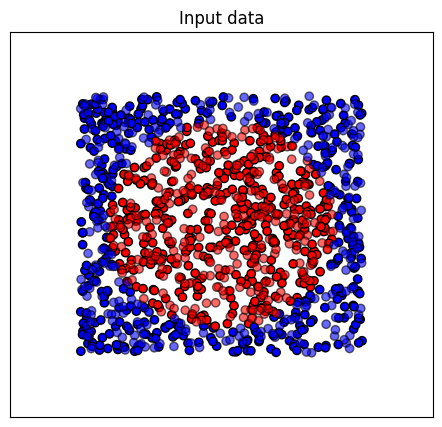

In [ ]:
datasets = [
    circle(1234, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi))
]

figure = plt.figure(figsize=(12, 5))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    clases = set(y)
    color_to_cycle = ["#FF0000", "#0000FF", "#006400"]
    my_colors = [ color_to_cycle[cl] for cl in clases ]
    cm_bright = ListedColormap(my_colors)
    ax = plt.subplot(len(datasets), 1 + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

## Lunas (2 features vs 2 clases)

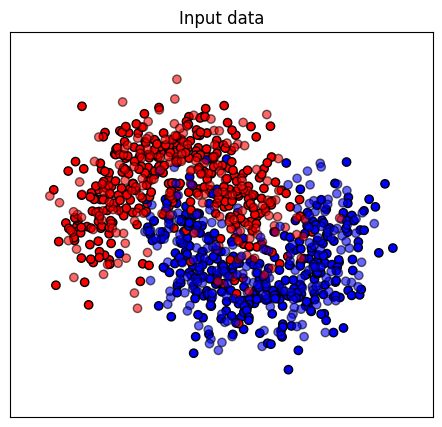

In [ ]:
datasets = [
    make_moons(n_samples=1000, noise=0.3, random_state=0)
]

figure = plt.figure(figsize=(12, 5))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    clases = set(y)
    color_to_cycle = ["#FF0000", "#0000FF", "#006400"]
    my_colors = [ color_to_cycle[cl] for cl in clases ]
    cm_bright = ListedColormap(my_colors)
    ax = plt.subplot(len(datasets), 1 + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

## Iris (2 features vs 3 clases)

explained variance ratio (first two components): [0.92461872 0.05306648]


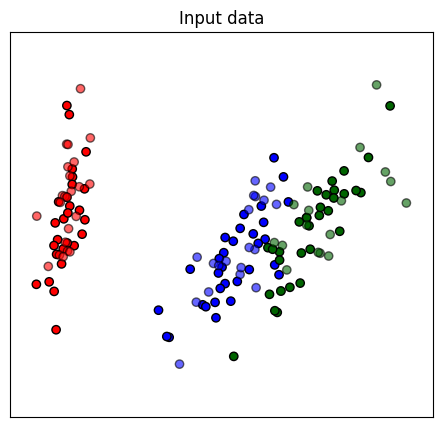

In [ ]:
datasets = [
    make_IRIS(2)
]

figure = plt.figure(figsize=(12, 5))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    clases = set(y)
    color_to_cycle = ["#FF0000", "#0000FF", "#006400"]
    my_colors = [ color_to_cycle[cl] for cl in clases ]
    cm_bright = ListedColormap(my_colors)
    ax = plt.subplot(len(datasets), 1 + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

## Circulos (2 features vs 3 clases)

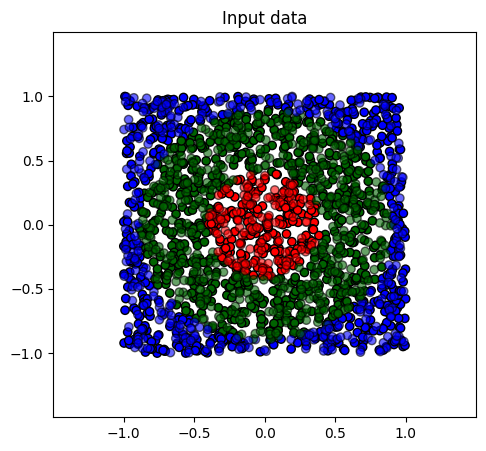

In [ ]:
datasets = [
    circle_v2(2000)
]

figure = plt.figure(figsize=(12, 5))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    clases = set(y)
    color_to_cycle = ["#FF0000", "#0000FF", "#006400"]
    my_colors = [ color_to_cycle[cl] for cl in clases ]
    cm_bright = ListedColormap(my_colors)
    ax = plt.subplot(len(datasets), 1 + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    #ax.set_xticks(())
    #ax.set_yticks(())
    i += 1

## Iris (3 features vs n clases)

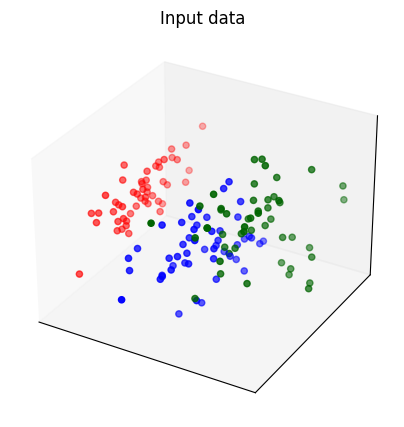

In [ ]:
datasets = [
    make_IRIS_v2(3,3)
]

fig = plt.figure(figsize=(12, 5))

i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    z_min, z_max = X[:, 2].min() - 0.5, X[:, 2].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    clases = set(y)
    color_to_cycle = ["#FF0000", "#0000FF", "#006400"]
    my_colors = [ color_to_cycle[cl] for cl in clases ]
    cm_bright = ListedColormap(my_colors)
    ax = fig.add_subplot(111, projection='3d')
    if ds_cnt == 0:
        ax.set_title("Input data")
    ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train, cmap=cm_bright, marker='o')
    ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_test, cmap=cm_bright, marker='o')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_ylim(z_min, z_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_zticks(())
plt.show()

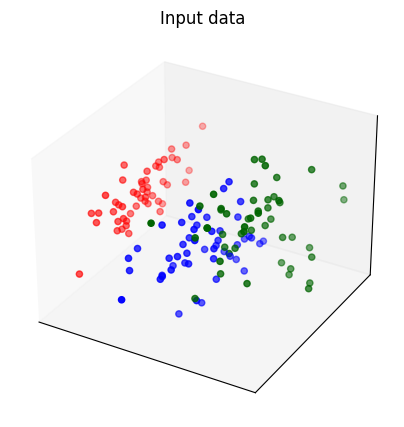

In [ ]:
datasets = [
    make_IRIS_v2(3,3)
]

fig = plt.figure(figsize=(12, 5))

i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    z_min, z_max = X[:, 2].min() - 0.5, X[:, 2].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    clases = set(y)
    color_to_cycle = ["#FF0000", "#0000FF", "#006400"]
    my_colors = [ color_to_cycle[cl] for cl in clases ]
    cm_bright = ListedColormap(my_colors)
    ax = fig.add_subplot(111, projection='3d')
    if ds_cnt == 0:
        ax.set_title("Input data")
    ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train, cmap=cm_bright, marker='o')
    ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_test, cmap=cm_bright, marker='o')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_ylim(z_min, z_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_zticks(())
plt.show()

# 4. Etiquetas para la clasificacion $|y⟩$

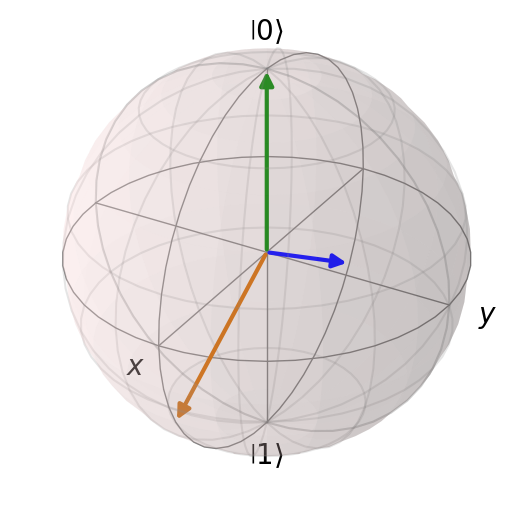

In [ ]:
states = representatives(3, 1)
states_to_bloch = []
for state_class in states:
  alpha = complex(state_class[0])
  beta = complex(state_class[1])
  state_i = (alpha*qutip.basis(2, 0) + beta*qutip.basis(2, 1)).unit()
  states_to_bloch.append(state_i)

b = qutip.Bloch()
b.add_states(states_to_bloch)
b.render()
b.show()

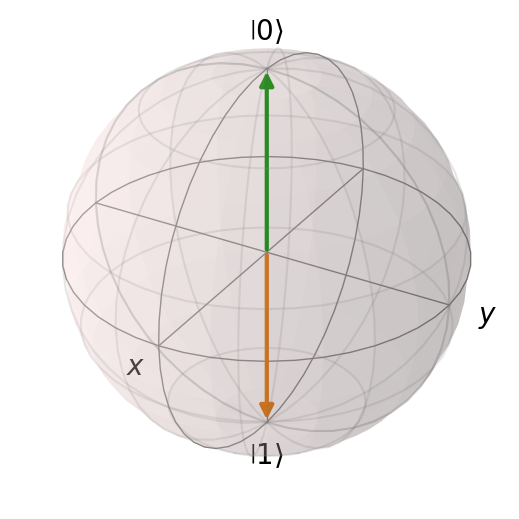

In [ ]:
states = representatives(2, 1)
states_to_bloch = []
for state_class in states:
  alpha = complex(state_class[0])
  beta = complex(state_class[1])
  state_i = (alpha*qutip.basis(2, 0) + beta*qutip.basis(2, 1)).unit()
  states_to_bloch.append(state_i)

b = qutip.Bloch()
b.add_states(states_to_bloch)
b.render()
b.show()

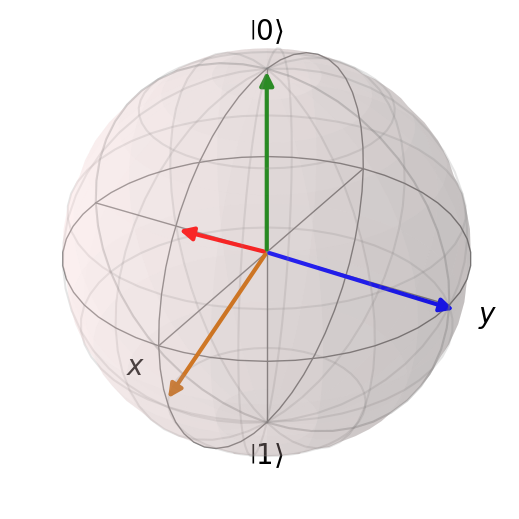

In [ ]:
states = representatives(4, 1)
states_to_bloch = []
for state_class in states:
  alpha = complex(state_class[0])
  beta = complex(state_class[1])
  state_i = (alpha*qutip.basis(2, 0) + beta*qutip.basis(2, 1)).unit()
  states_to_bloch.append(state_i)

b = qutip.Bloch()
b.add_states(states_to_bloch)
b.render()
b.show()

In [ ]:
states = representatives(4, 2)
states

tensor([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]], requires_grad=False)

#5. Modelo de clasificación de 1 qubit

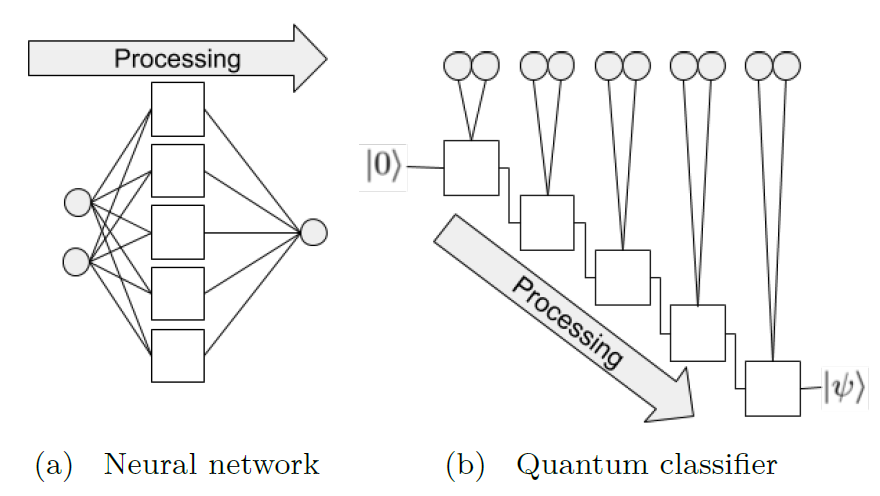

## Modelo 1 Paper inspiración

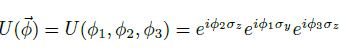

La funcion $U(\overrightarrow{\phi})$ depende del cocinero. Para este caso se especifica un caso particular donde esta se da mediante las rotaciones $R_z(\phi_2)$, $R_y(\phi_1)$, $R_z(\phi_3)$ simulaneas, en el paper [ppl. data reuploading] se demuestra que esta estrategia permite representar un: "non-constant trigonometric polynomial", cual es compatible con el "Universal Approximation Theorem".

Para simular dicha rotación usando las herramienta de pennylane se utiliza qml.rot, esta función tiene el siguiente modelo matemático:

$$\begin{split}R(\phi,\theta,\omega) = RZ(\omega)RY(\theta)RZ(\phi)= \begin{bmatrix}
e^{-i(\phi+\omega)/2}\cos(\theta/2) & -e^{i(\phi-\omega)/2}\sin(\theta/2) \\
e^{-i(\phi-\omega)/2}\sin(\theta/2) & e^{i(\phi+\omega)/2}\cos(\theta/2)
\end{bmatrix}.\end{split}$$

Debido a la propuesta del paper, (2,1,3) y el modelo, se ingresan los parametros en orden: (3,1,2). Nota: Es una multiplicación de matrices, por tanto importa el orden!

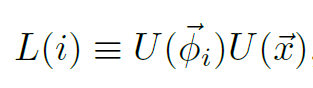

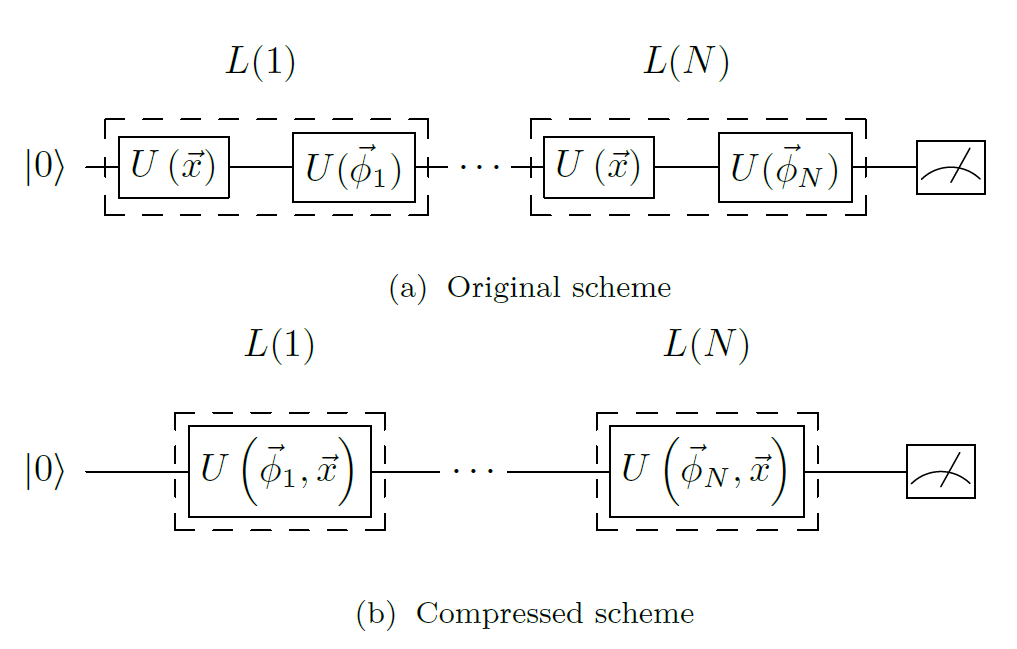

El numero de L(i) se asigna implicitamente en función del numero de parametros. Cada layer tiene sus propios parametros, lo que significa que en funcion del for interno de cada circuito se tendra en cuenta implicidamente el numero de layers que se introduce.

In [ ]:
""" VERSION ANTERIOR
dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev, interface="autograd")
def qcircuit_1_qubit(params, x, bias = None, entanglement=False):
    '''A variational quantum circuit representing the Universal classifier.
    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
    Returns:
        float: qml state
    ''''
    for p in params:
        qml.Rot(*x, wires=0) # RZ * RY * RZ -> data
        qml.Rot(*p, wires=0) # RZ * RY * RZ -> parameters
    return qml.state()
"""

' VERSION ANTERIOR\ndev = qml.device("default.qubit", wires=1)\n@qml.qnode(dev, interface="autograd")\ndef qcircuit_1_qubit(params, x, bias = None, entanglement=False):\n    \'\'\'A variational quantum circuit representing the Universal classifier.\n    Args:\n        params (array[float]): array of parameters\n        x (array[float]): single input vector\n    Returns:\n        float: qml state\n    \'\'\'\'\n    for p in params:\n        qml.Rot(*x, wires=0) # RZ * RY * RZ -> data\n        qml.Rot(*p, wires=0) # RZ * RY * RZ -> parameters\n    return qml.state()\n'

In [ ]:
dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev, interface="autograd")
def qcircuit_1_qubit(params, x, bias = None, entanglement=False):
    """A variational quantum circuit representing the Universal classifier.
    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
    Returns:
        float: qml state
    """
    x1,x2,x3 = x
    for p in params:
      p1,p2,p3 = p
      qml.Rot(x3,x1,x2, wires=0) # RZ * RY * RZ -> data
      qml.Rot(p3,p1,p2, wires=0) # RZ * RY * RZ -> parameters
    return qml.state()

## Modelo 2 Paper inspiracion

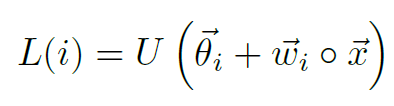

Este modelo plantea ingresar todos los parametros, caracteristicas y bias en una sola capa, donde: $\circ$ es el producto de hadammar, es decir elemento por elemento.

In [ ]:
""" VERSION ANTERIOR
dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev, interface="autograd")
def qcircuit_2_qubit(params, x, bias=None, entanglement=False):
    '''A variational quantum circuit representing the Universal classifier.
    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
    Returns:
        float: qml state
    '''
    for i,p in enumerate(params):
      arg = np.multiply(p,x) + bias[i]
      qml.Rot(*arg , wires=0) # RZ * RY * RZ -> data
    return qml.state()
"""

' VERSION ANTERIOR\ndev = qml.device("default.qubit", wires=1)\n@qml.qnode(dev, interface="autograd")\ndef qcircuit_2_qubit(params, x, bias=None, entanglement=False):\n    \'\'\'A variational quantum circuit representing the Universal classifier.\n    Args:\n        params (array[float]): array of parameters\n        x (array[float]): single input vector\n    Returns:\n        float: qml state\n    \'\'\'\n    for i,p in enumerate(params):\n      arg = np.multiply(p,x) + bias[i]\n      qml.Rot(*arg , wires=0) # RZ * RY * RZ -> data\n    return qml.state()\n'

In [ ]:
dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev, interface="autograd")
def qcircuit_2_qubit(params, x, bias=None, entanglement=False):
    '''A variational quantum circuit representing the Universal classifier.
    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
    Returns:
        float: qml state
    '''
    for i,p in enumerate(params):
      arg = np.multiply(p,x) + bias[i]
      arg1, arg2, arg3 = arg
      qml.Rot(arg3,arg1,arg2 , wires=0) # RZ * RY * RZ -> data
      qml.Snapshot(f"ket_1_qubit_{i}")
    return qml.state()

## Modelo 3 Paper que habla de limitaciones

En el paper donde demuestran formalmente a DRU como un clasificador universal, ellos propinen una capa inicial 0. Esta capa se coloca al final, es decir antes de la medida, aparentemente el orden en este contexto es distinto al orden del paper inspiración.

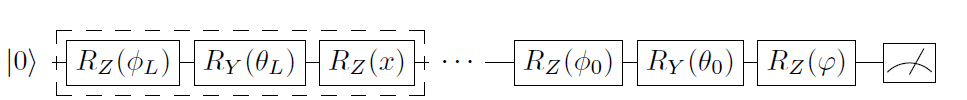

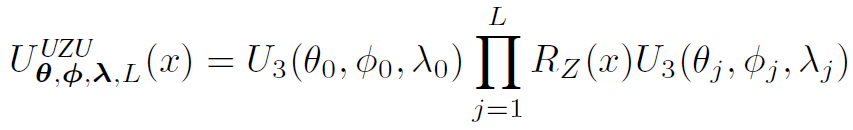

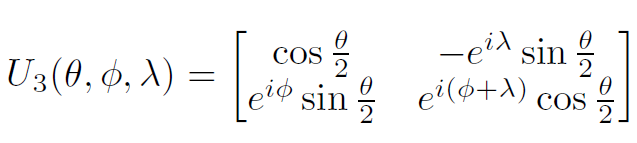

Se encontro una manera de implementar la propuesta del paper usando un bloque de rotacion en qml.

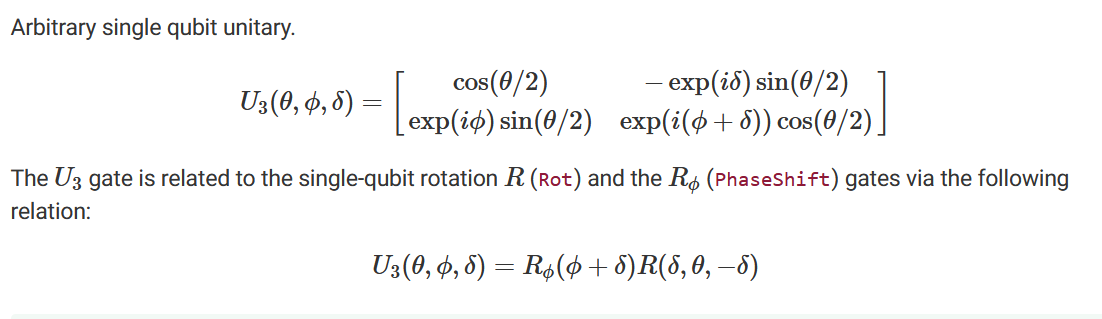

https://docs.pennylane.ai/en/stable/code/api/pennylane.U3.html

En este sección el paper propone un caso de regresion, por tanto, solo se ingresa un $x \in R$, sin embargo todavia no es clara la discución para varios qubits, es un poco confusa ya que ellos proponen un modelo donde una entrada $\textbf{x} \in R^d$  puede representarce de la forma:

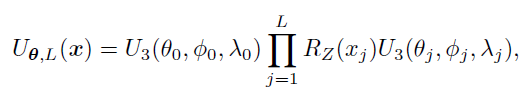

Donde $x_j$ es un dato unidemsional i.e. $\in R$ de $\textbf{x}$, es decir que cada atributo de $\textbf{x}$ se sube $K$ veces. Por tanto $L = dK$. Por ahora se entiende que se ingresa la capa 0, luego una dimension de $\textbf{x}$ luego la j-th capa luego la otra dimension de $\textbf{x}$ etc. tantas K veces como se requiera repedir la subida de la data. Esta seria una version pura de hacerlo y con pesos en la subidad de data seria la parte hybrid, que se ve a continuación.

In [ ]:
# U3(theta, phi, delta)

In [ ]:
dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev, interface="autograd")
def qcircuit_3_qubit(params, x, bias=None, entanglement=False):
    '''A variational quantum circuit representing the Universal classifier.
    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
    Returns:
        float: qml state
    '''
    x1,x2,x3 = x
    for i,p in enumerate(params):
      qml.RZ(phi # ... continuar
      qml.U3(p1, p2, p3)
    U3_i = qml.U3(p1, p2, p3)
    return qml.state()

Todos estos casos funcionan por ahroa con maximo 3 dimenciones, hay que hacer casos con mas dimensiones generalizando el 0 las veces que sea necesario independientemente de las dimenciones.

### Variacio para el embeding

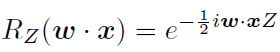

## Metodologia

# 6. Primera visualizacion - modelo con 1 qubit

En esta sección se muestra la primera visualización de el modelo 1, sin entrenamiento.

In [ ]:
num_layers = 8
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

<Figure size 500x500 with 0 Axes>

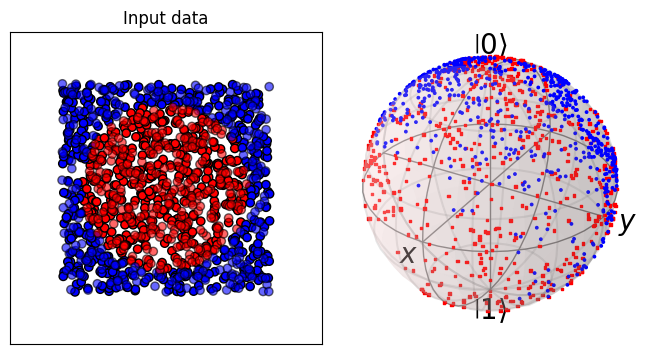

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True)
ax1 = fig.add_subplot(1, 2, 1)
datasets = [circle(1243)]
for ds_cnt, ds in enumerate(datasets):
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    # just plot the dataset first
    cm = plt.cm.RdBu
    clases = set(y)
    color_to_cycle = ["#FF0000", "#0000FF", "#006400"]
    my_colors = [ color_to_cycle[cl] for cl in clases ]
    cm_bright = ListedColormap(my_colors)
    if ds_cnt == 0:
        ax1.set_title("Input data")
    # Plot the training points
    ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax1.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax1.set_xticks(())
    ax1.set_yticks(())
    ax1.set_aspect('equal')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
S = 3*np.ones((len(y)))
visualization_1_qubit(qcircuit_1_qubit, X, y, params, ax2, sz=S)
ax2.set_box_aspect([1, 1, 1])
plt.show()

<Figure size 500x500 with 0 Axes>

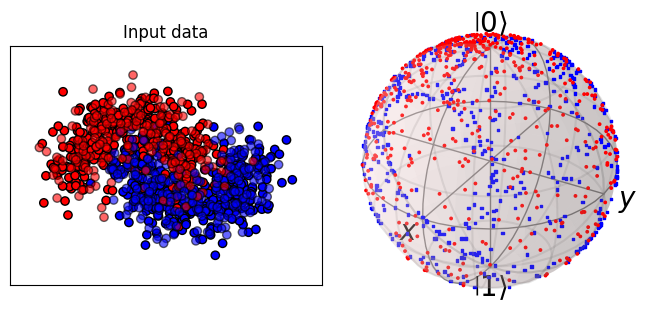

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True)
ax1 = fig.add_subplot(1, 2, 1)
num_training = 1000
datasets = [make_moons(n_samples=num_training, noise=0.3, random_state=0)]
for ds_cnt, ds in enumerate(datasets):
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    # just plot the dataset first
    cm = plt.cm.RdBu
    clases = set(y)
    color_to_cycle = ["#FF0000", "#0000FF", "#006400"]
    my_colors = [ color_to_cycle[cl] for cl in clases ]
    cm_bright = ListedColormap(my_colors)
    if ds_cnt == 0:
        ax1.set_title("Input data")
    # Plot the training points
    ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax1.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax1.set_xticks(())
    ax1.set_yticks(())
    ax1.set_aspect('equal')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
S = 3*np.ones((len(y)))
visualization_1_qubit(qcircuit_1_qubit, X, y, params, ax2, sz=S)
ax2.set_box_aspect([1, 1, 1])
plt.show()

["#FF0000", "#0000FF",  "#006400"] -> ROJO, AZUL, VERDE -> [0,1,2]

explained variance ratio (first two components): [0.92461872 0.05306648]


<Figure size 500x500 with 0 Axes>

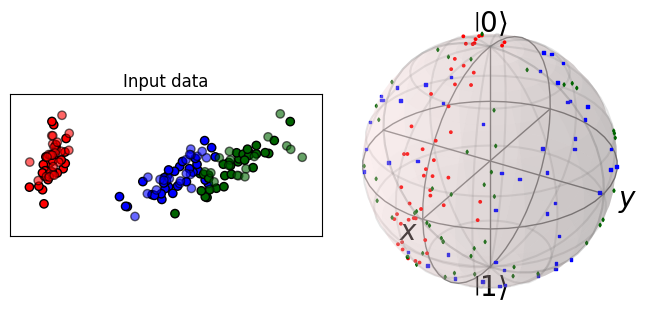

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True)
ax1 = fig.add_subplot(1, 2, 1)
datasets = [make_IRIS(2)]
for ds_cnt, ds in enumerate(datasets):
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    # just plot the dataset first
    cm = plt.cm.RdBu

    clases = set(y)
    color_to_cycle = ["#FF0000", "#0000FF", "#006400"]
    my_colors = [ color_to_cycle[cl] for cl in clases ]
    cm_bright = ListedColormap(my_colors)
    if ds_cnt == 0:
      # poner input data en la primera subplot
        ax1.set_title("Input data")
    # Plot the training points
    ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax1.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax1.set_xticks(())
    ax1.set_yticks(())
    ax1.set_aspect('equal')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
S = 3*np.ones((len(y)))
visualization_1_qubit(qcircuit_1_qubit, X, y, params, ax2, sz = S)
ax2.set_box_aspect([1, 1, 1])
plt.show()

{0, 1}


<Figure size 500x500 with 0 Axes>

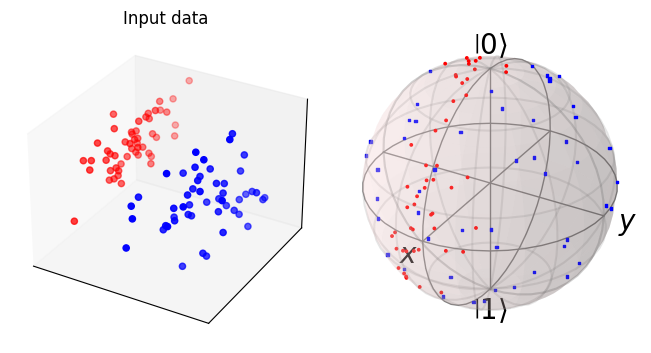

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
datasets = [make_IRIS_v2(3,2)]
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )
    print(set(y_train))
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    z_min, z_max = X[:, 2].min() - 0.5, X[:, 2].max() + 0.5
    # just plot the dataset first
    cm = plt.cm.RdBu
    # "#FF0000", "#0000FF"
    clases = set(y)
    color_to_cycle = ["#FF0000", "#0000FF", "#006400"]
    my_colors = [ color_to_cycle[cl] for cl in clases ]
    cm_bright = ListedColormap(my_colors)

    # ["#FF0000", "#0000FF", "#006400"]
    if ds_cnt == 0:
        ax1.set_title("Input data")
    ax1.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train, cmap=cm_bright, marker='o')
    ax1.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_test, cmap=cm_bright, marker='o')
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax1.set_ylim(z_min, z_max)
    ax1.set_xticks(())
    ax1.set_yticks(())
    ax1.set_zticks(())
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
S = 3*np.ones((len(y)))
visualization_1_qubit(qcircuit_1_qubit, X, y, params, ax2, sz = S)
ax2.set_box_aspect([1, 1, 1])
plt.show()

<Figure size 500x500 with 0 Axes>

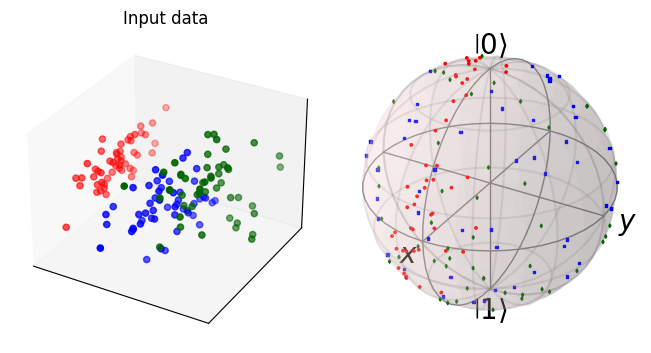

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
datasets = [make_IRIS_v2(3,3)]
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    z_min, z_max = X[:, 2].min() - 0.5, X[:, 2].max() + 0.5
    # just plot the dataset first
    cm = plt.cm.RdBu
    clases = set(y)
    color_to_cycle = ["#FF0000", "#0000FF", "#006400"]
    my_colors = [ color_to_cycle[cl] for cl in clases ]
    cm_bright = ListedColormap(my_colors)
    if ds_cnt == 0:
        ax1.set_title("Input data")
    ax1.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train, cmap=cm_bright, marker='o')
    ax1.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_test, cmap=cm_bright, marker='o')
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax1.set_ylim(z_min, z_max)
    ax1.set_xticks(())
    ax1.set_yticks(())
    ax1.set_zticks(())
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
S = 3*np.ones((len(y)))
visualization_1_qubit(qcircuit_1_qubit, X, y, params, ax2, sz = S)
ax2.set_box_aspect([1, 1, 1])
plt.show()

# 7. Funciones de costo





## Fidelidad

### Fidelidad cuantica

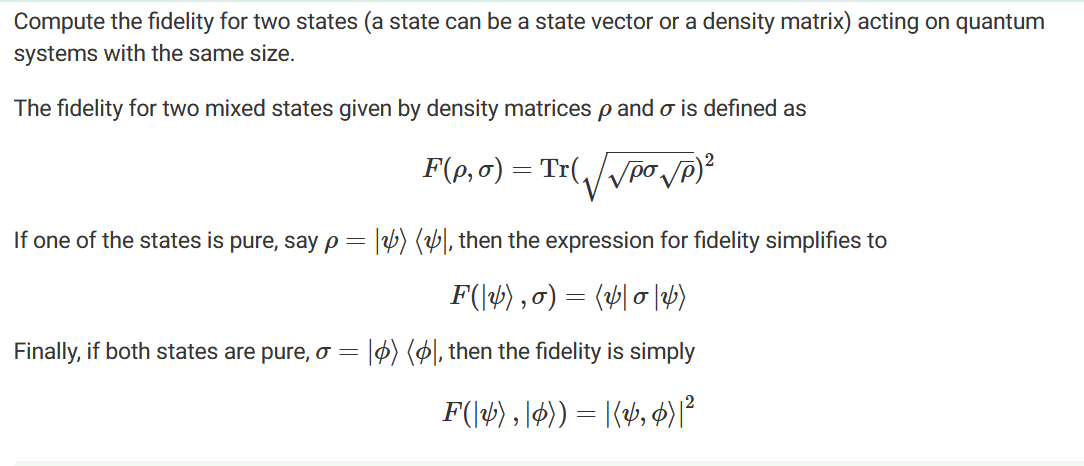

### Funcion de costo basada en fidelidad cuantica

$$\texttt{Cost} = \frac{1}{N} \sum_{k}^{N} (1 - \texttt{fidelity}(\psi_{\texttt{output}}(\vec x, \vec \theta), \psi_{\texttt{label}}))^2$$

In [ ]:
def fidelity_cost(model, params, x, y, state_labels=None, bias = None, entanglement = False):
    """Cost function to be minimized.
    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels
    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    #dm_labels = [density_matrix(s) for s in state_labels]
    dm_labels = [s for s in state_labels]
    for i in range(len(x)):
      state_output = model(params, x[i], bias = bias, entanglement = entanglement)
      f = fidelity(qml.math.dm_from_state_vector(state_output), qml.math.dm_from_state_vector(dm_labels[y[i]]))
      loss = loss + (1 - f)
    #print(type(loss / len(x)))
    return loss/len(x)

# 8. Entrenamiento

## Training to circle dataset

In [ ]:
# Generate training and test data
num_training = 400 # n points to training
num_test = 200 # n points to test
# TRAIN:
Xdata, y_train = circle(num_training)
# zeros es porque entrada es R2 y se necesita R3, pero articulo dice dejar en ceros:
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))
# TEST:
# zeros es porque entrada es R2 y se necesita R3, pero articulo dice dejar en ceros:
Xtest, y_test = circle(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))

In [ ]:
# Train using Adam optimizer and evaluate the classifier
num_layers = 10
learning_rate = 0.1
epochs = 12
batch_size = 32
# clases
n_clases = 2
state_labels = representatives(n_clases, 1)
# optimaz
opt = qml.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.99)
# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)
bias = np.random.uniform(size=(num_layers, 3), requires_grad=True)

In [ ]:
predicted_train, fidel_train = test(qcircuit_2_qubit, params, X_train, y_train, state_labels,bias)
accuracy_train = accuracy_score(y_train, predicted_train)
predicted_test, fidel_test = test(qcircuit_2_qubit, params, X_test, y_test, state_labels,bias)
accuracy_test = accuracy_score(y_test, predicted_test)
# save predictions with random weights for comparison
initial_predictions = predicted_test
loss = fidelity_cost(qcircuit_2_qubit,params, X_train, y_train, state_labels,bias)
print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

Epoch:  0 | Cost: 0.471799 | Train accuracy: 0.552500 | Test Accuracy: 0.530000


In [ ]:
for it in range(epochs):
  for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
    params, bias = opt.step(lambda p,b: fidelity_cost(qcircuit_2_qubit, p, Xbatch, ybatch, state_labels,b), params, bias)
  # Results by Epochs:
  predicted_train, fidel_train = test(qcircuit_2_qubit, params, X_train, y_train, state_labels, bias)
  # test(model, params, x, y, state_labels=None)
  accuracy_train = accuracy_score(y_train, predicted_train)
  loss = fidelity_cost(qcircuit_2_qubit,params, X_train, y_train, state_labels, bias)
  predicted_test, fidel_test = test(qcircuit_2_qubit, params, X_test, y_test, state_labels, bias)
  accuracy_test = accuracy_score(y_test, predicted_test)
  res = [it + 1, loss, accuracy_train, accuracy_test]
  print(
      "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
          *res
      )
  )

Epoch:  1 | Loss: 0.308784 | Train accuracy: 0.740000 | Test accuracy: 0.760000
Epoch:  2 | Loss: 0.271346 | Train accuracy: 0.805000 | Test accuracy: 0.785000
Epoch:  3 | Loss: 0.266211 | Train accuracy: 0.785000 | Test accuracy: 0.760000
Epoch:  4 | Loss: 0.243277 | Train accuracy: 0.837500 | Test accuracy: 0.820000
Epoch:  5 | Loss: 0.242329 | Train accuracy: 0.837500 | Test accuracy: 0.850000
Epoch:  6 | Loss: 0.235131 | Train accuracy: 0.860000 | Test accuracy: 0.865000
Epoch:  7 | Loss: 0.235358 | Train accuracy: 0.847500 | Test accuracy: 0.850000
Epoch:  8 | Loss: 0.225754 | Train accuracy: 0.875000 | Test accuracy: 0.885000
Epoch:  9 | Loss: 0.225001 | Train accuracy: 0.860000 | Test accuracy: 0.845000
Epoch: 10 | Loss: 0.221551 | Train accuracy: 0.875000 | Test accuracy: 0.865000
Epoch: 11 | Loss: 0.224194 | Train accuracy: 0.862500 | Test accuracy: 0.850000
Epoch: 12 | Loss: 0.223987 | Train accuracy: 0.877500 | Test accuracy: 0.870000


Cost: 0.223987 | Train accuracy 0.877500 | Test Accuracy : 0.870000
Learned weights
Layer 0: [ 0.02677899 -0.75673155  0.67835063]
Layer 1: [-0.52778263  2.53896416  0.34539666]
Layer 2: [ 0.83987956 -0.24590823  0.20407306]
Layer 3: [1.01643569 1.07409501 0.39460495]
Layer 4: [0.54811594 0.04006311 0.4550517 ]
Layer 5: [ 0.84572301 -0.27247551  0.73598449]
Layer 6: [0.3569811  0.16473206 0.79376681]
Layer 7: [0.91026444 1.98320293 0.66890011]
Layer 8: [0.67106332 3.02873198 0.34657799]
Layer 9: [1.29735152 0.75844596 0.32125517]


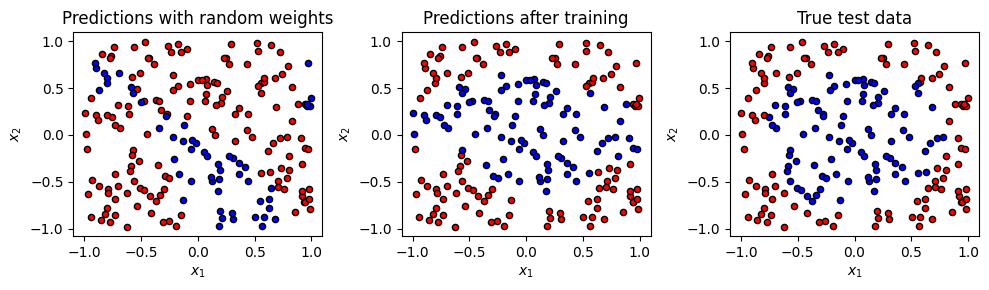

In [ ]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)
print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

### Visualizacion en bloch sphere

<Figure size 500x500 with 0 Axes>

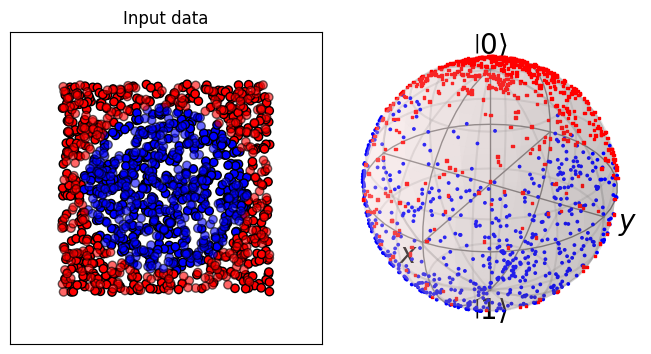

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True)
ax1 = fig.add_subplot(1, 2, 1)
datasets = [circle(1243)]
for ds_cnt, ds in enumerate(datasets):
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    if ds_cnt == 0:
        ax1.set_title("Input data")
    # Plot the training points
    ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax1.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax1.set_xticks(())
    ax1.set_yticks(())
    ax1.set_aspect('equal')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
S = 3*np.ones((len(y)))
visualization_1_qubit(qcircuit_2_qubit, X, y, params, ax2, sz=S, bias=bias)
ax2.set_box_aspect([1, 1, 1])
plt.show()

## Training to moons dataset

In [ ]:
# Generate training and test data
num_training = 400 # n points to training
num_test = 200 # n points to test
# TRAIN:
Xdata, y_train = make_moons(n_samples=num_training, noise=0.3, random_state=0)
# zeros es porque entrada es R2 y se necesita R3, pero articulo dice dejar en ceros:
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))
# TEST:
# zeros es porque entrada es R2 y se necesita R3, pero articulo dice dejar en ceros:
Xtest, y_test = make_moons(n_samples=num_test, noise=0.3, random_state=0)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))

In [ ]:
# Train using Adam optimizer and evaluate the classifier
num_layers = 10
learning_rate = 0.1
epochs = 12
batch_size = 32
# clases
n_clases = 2
state_labels = representatives(n_clases, 1)
# optimaz
opt = qml.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)
bias = np.random.uniform(size=(num_layers, 3), requires_grad=True)

In [ ]:
predicted_train, fidel_train = test(qcircuit_2_qubit, params, X_train, y_train, state_labels,bias)
accuracy_train = accuracy_score(y_train, predicted_train)
predicted_test, fidel_test = test(qcircuit_2_qubit, params, X_test, y_test, state_labels,bias)
accuracy_test = accuracy_score(y_test, predicted_test)
# save predictions with random weights for comparison
initial_predictions = predicted_test
loss = fidelity_cost(qcircuit_2_qubit,params, X_train, y_train, state_labels,bias)
print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

Epoch:  0 | Cost: 0.444789 | Train accuracy: 0.605000 | Test Accuracy: 0.570000


In [ ]:
for it in range(epochs):
  for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
    params, bias = opt.step(lambda p,b: fidelity_cost(qcircuit_2_qubit, p, Xbatch, ybatch, state_labels,b), params, bias)
  # Results by Epochs:
  predicted_train, fidel_train = test(qcircuit_2_qubit, params, X_train, y_train, state_labels, bias)
  # test(model, params, x, y, state_labels=None)
  accuracy_train = accuracy_score(y_train, predicted_train)
  loss = fidelity_cost(qcircuit_2_qubit,params, X_train, y_train, state_labels, bias)
  predicted_test, fidel_test = test(qcircuit_2_qubit, params, X_test, y_test, state_labels, bias)
  accuracy_test = accuracy_score(y_test, predicted_test)
  res = [it + 1, loss, accuracy_train, accuracy_test]
  print(
      "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
          *res
      )
  )

Epoch:  1 | Loss: 0.213714 | Train accuracy: 0.847500 | Test accuracy: 0.830000
Epoch:  2 | Loss: 0.185996 | Train accuracy: 0.882500 | Test accuracy: 0.870000
Epoch:  3 | Loss: 0.182532 | Train accuracy: 0.895000 | Test accuracy: 0.870000
Epoch:  4 | Loss: 0.176353 | Train accuracy: 0.892500 | Test accuracy: 0.865000
Epoch:  5 | Loss: 0.170181 | Train accuracy: 0.897500 | Test accuracy: 0.865000
Epoch:  6 | Loss: 0.163252 | Train accuracy: 0.897500 | Test accuracy: 0.875000
Epoch:  7 | Loss: 0.157906 | Train accuracy: 0.902500 | Test accuracy: 0.880000
Epoch:  8 | Loss: 0.159979 | Train accuracy: 0.900000 | Test accuracy: 0.875000
Epoch:  9 | Loss: 0.162301 | Train accuracy: 0.902500 | Test accuracy: 0.885000
Epoch: 10 | Loss: 0.161627 | Train accuracy: 0.900000 | Test accuracy: 0.905000
Epoch: 11 | Loss: 0.159730 | Train accuracy: 0.895000 | Test accuracy: 0.895000
Epoch: 12 | Loss: 0.152821 | Train accuracy: 0.905000 | Test accuracy: 0.905000


Cost: 0.152821 | Train accuracy 0.905000 | Test Accuracy : 0.905000
Learned weights
Layer 0: [0.24108814 2.9496076  0.93122476]
Layer 1: [0.89515569 1.3126538  0.99338988]
Layer 2: [0.15707124 0.91364534 0.01241609]
Layer 3: [-0.98631949 -0.37924868  0.02163932]
Layer 4: [-0.63979196  0.71528125  0.58611054]
Layer 5: [ 0.72003051 -0.26625436  0.05060139]
Layer 6: [ 1.32693651 -0.67095944  0.55339244]
Layer 7: [ 0.07348137 -1.23258165  0.97623126]
Layer 8: [ 0.1321381  -0.67213265  0.93726204]
Layer 9: [0.01141881 0.6991932  0.52517579]
Bias 0: [ 0.48568244 -0.58012905  0.26837837]
Bias 1: [ 0.54863019 -0.08639368  0.09264416]
Bias 2: [ 1.1978596   0.3501923  -0.15961845]
Bias 3: [0.52487266 1.330625   0.47256484]
Bias 4: [0.16644685 0.85662699 1.11901334]
Bias 5: [-0.22315713  0.79091946  1.27314584]
Bias 6: [0.70836245 0.41553985 1.06746576]
Bias 7: [0.33199707 1.17885955 0.43258171]
Bias 8: [-0.11645997  1.343988    0.30109184]
Bias 9: [0.19054849 0.08240443 1.29995596]


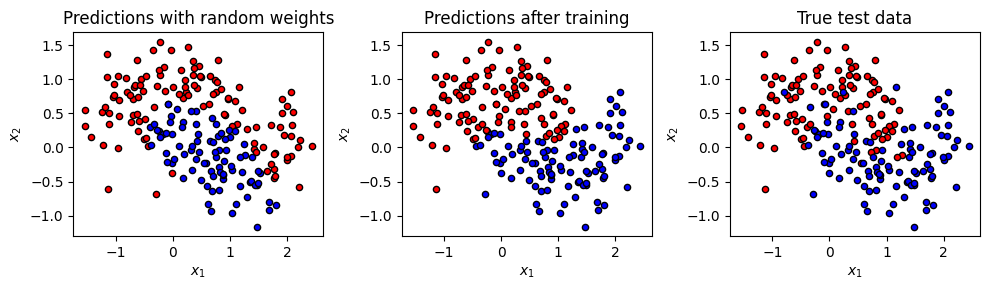

In [ ]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)
print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))

for i in range(num_layers):
    print("Bias {}: {}".format(i, bias[i]))

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

### Visualizacion en bloch sphere

<Figure size 500x500 with 0 Axes>

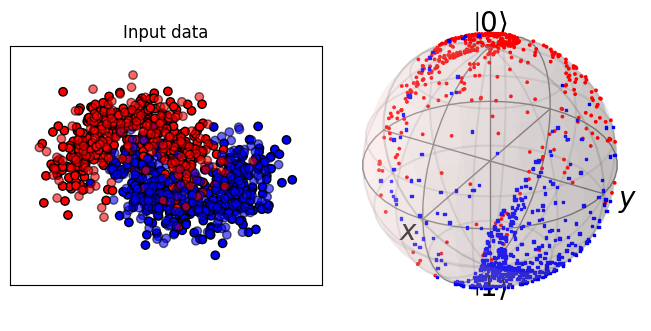

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True)
ax1 = fig.add_subplot(1, 2, 1)
datasets = [make_moons(n_samples=1000, noise=0.3, random_state=0)]
for ds_cnt, ds in enumerate(datasets):
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    if ds_cnt == 0:
        ax1.set_title("Input data")
    # Plot the training points
    ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax1.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax1.set_xticks(())
    ax1.set_yticks(())
    ax1.set_aspect('equal')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
S = 3*np.ones((len(y)))
visualization_1_qubit(qcircuit_2_qubit, X, y, params, ax2, sz=S, bias=bias)
ax2.set_box_aspect([1, 1, 1])
plt.show()

## Training to Iris (2Ftr vs 3clss)

In [ ]:
X, y =  make_IRIS(2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_train = np.hstack((X_train, np.zeros((X_train.shape[0], 1), requires_grad=False)))
X_test = np.hstack((X_test, np.zeros((X_test.shape[0], 1), requires_grad=False)))

explained variance ratio (first two components): [0.92461872 0.05306648]


In [ ]:
# Train using Adam optimizer and evaluate the classifier
num_layers = 10
learning_rate = 0.1
epochs = 12
batch_size = 32
# clases
n_clases = 3
state_labels = representatives(n_clases, 1)
# optimaz
opt = qml.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)
bias = np.random.uniform(size=(num_layers, 3), requires_grad=True)

In [ ]:
predicted_train, fidel_train = test(qcircuit_2_qubit, params, X_train, y_train, state_labels,bias)
accuracy_train = accuracy_score(y_train, predicted_train)
predicted_test, fidel_test = test(qcircuit_2_qubit, params, X_test, y_test, state_labels,bias)
accuracy_test = accuracy_score(y_test, predicted_test)
# save predictions with random weights for comparison
initial_predictions = predicted_test
loss = fidelity_cost(qcircuit_2_qubit,params, X_train, y_train, state_labels,bias)
print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

Epoch:  0 | Cost: 0.525491 | Train accuracy: 0.285714 | Test Accuracy: 0.266667


In [ ]:
for it in range(epochs):
  for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
    params, bias = opt.step(lambda p,b: fidelity_cost(qcircuit_2_qubit, p, Xbatch, ybatch, state_labels,b), params, bias)
  # Results by Epochs:
  predicted_train, fidel_train = test(qcircuit_2_qubit, params, X_train, y_train, state_labels, bias)
  # test(model, params, x, y, state_labels=None)
  accuracy_train = accuracy_score(y_train, predicted_train)
  loss = fidelity_cost(qcircuit_2_qubit,params, X_train, y_train, state_labels, bias)
  predicted_test, fidel_test = test(qcircuit_2_qubit, params, X_test, y_test, state_labels, bias)
  accuracy_test = accuracy_score(y_test, predicted_test)
  res = [it + 1, loss, accuracy_train, accuracy_test]
  print(
      "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
          *res
      )
  )

Epoch:  1 | Loss: 0.281855 | Train accuracy: 0.609524 | Test accuracy: 0.511111
Epoch:  2 | Loss: 0.201914 | Train accuracy: 0.771429 | Test accuracy: 0.688889
Epoch:  3 | Loss: 0.193225 | Train accuracy: 0.761905 | Test accuracy: 0.733333
Epoch:  4 | Loss: 0.106606 | Train accuracy: 0.933333 | Test accuracy: 0.933333
Epoch:  5 | Loss: 0.100322 | Train accuracy: 0.961905 | Test accuracy: 0.933333
Epoch:  6 | Loss: 0.099608 | Train accuracy: 0.942857 | Test accuracy: 0.933333
Epoch:  7 | Loss: 0.074991 | Train accuracy: 0.952381 | Test accuracy: 0.955556
Epoch:  8 | Loss: 0.066645 | Train accuracy: 0.961905 | Test accuracy: 1.000000
Epoch:  9 | Loss: 0.069016 | Train accuracy: 0.952381 | Test accuracy: 0.955556
Epoch: 10 | Loss: 0.059114 | Train accuracy: 0.952381 | Test accuracy: 0.977778
Epoch: 11 | Loss: 0.057562 | Train accuracy: 0.952381 | Test accuracy: 0.977778
Epoch: 12 | Loss: 0.054912 | Train accuracy: 0.942857 | Test accuracy: 0.977778


Cost: 0.054912 | Train accuracy 0.942857 | Test Accuracy : 0.977778
Learned weights
Layer 0: [ 0.57567068 -0.29340493  0.2505016 ]
Layer 1: [0.32530794 0.43187908 0.49423593]
Layer 2: [ 0.05337805 -0.09215608  0.41143624]
Layer 3: [1.34536546 0.874158   0.70897515]
Layer 4: [0.23487691 0.39335635 0.72095531]
Layer 5: [ 0.44835997 -0.00303718  0.4475007 ]
Layer 6: [ 0.51803332 -0.69432885  0.41060407]
Layer 7: [1.14104966 0.2756158  0.98540478]
Layer 8: [-0.87683114  0.86980202  0.58101624]
Layer 9: [0.16963907 0.44647049 0.1296504 ]
Bias 0: [0.81602046 0.27115009 0.25899607]
Bias 1: [0.8864161  0.37158939 0.39413701]
Bias 2: [-0.00488717  0.63939048  0.57892359]
Bias 3: [ 0.32628206  0.62184083 -0.02019558]
Bias 4: [-0.1088895   0.38324006 -0.00580621]
Bias 5: [-0.44554587  0.95837934  0.69450545]
Bias 6: [0.24163371 0.06233098 1.10716851]
Bias 7: [1.48866995 0.19659975 0.69581419]
Bias 8: [0.38276136 1.23279623 0.11597184]
Bias 9: [-0.45721654  0.93179641  1.34218134]


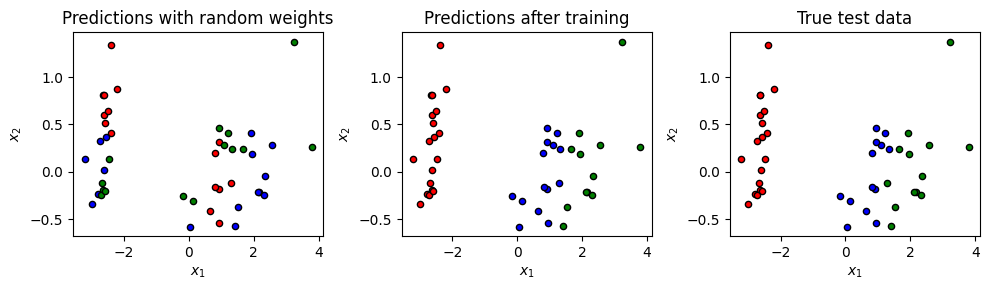

In [ ]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)
print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))

for i in range(num_layers):
    print("Bias {}: {}".format(i, bias[i]))
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data_v2(X_test, initial_predictions, fig, axes[0])
plot_data_v2(X_test, predicted_test, fig, axes[1])
plot_data_v2(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

### Implementacion con spines

In [ ]:
!pip install qutip-qip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 2.6 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import qutip
from qutip_qip.circuit import QubitCircuit
from qutip_qip.device import LinearSpinChain
import numpy as np
import re

In [ ]:
def qQcircuit_2_qubit(params, x, bias=None, entanglement=False):
    processor = LinearSpinChain(1)
    qc = QubitCircuit(N=1)
    '''A variational quantum circuit representing the Universal classifier.
    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
    Returns:
        float: qml state
    '''
    for i,p in enumerate(params):
        arg = np.multiply(p,x) + bias[i]
        arg1, arg2, arg3 = arg
        # Apply the corresponding QuTiP gates
        qc.add_gate("RZ", targets=[0], arg_value=arg1, arg_label=r'\frac{\pi}{1}')
        qc.add_gate("RY", targets=[0], arg_value=arg2, arg_label=r'\frac{\pi}{1}')
        qc.add_gate("RZ", targets=[0], arg_value=arg3, arg_label=r'\frac{\pi}{1}')
    processor.load_circuit(qc)
    psi0 = qutip.basis([2], [0])
    result = processor.run_state(init_state=psi0)
    return result, processor

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
y_test_spin_model = []
for x_test in X_test:
  # params, bias
  final_state, my_processor = qQcircuit_2_qubit(params.tolist(), x_test.tolist(), bias.tolist())
  #my_processor.plot_pulses(title="Control pulse of Spin chain", figsize=(8, 4), dpi=100);
  state_out = final_state.states[-1].full()
  y_test_spin_model.append(state_out.reshape(2))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


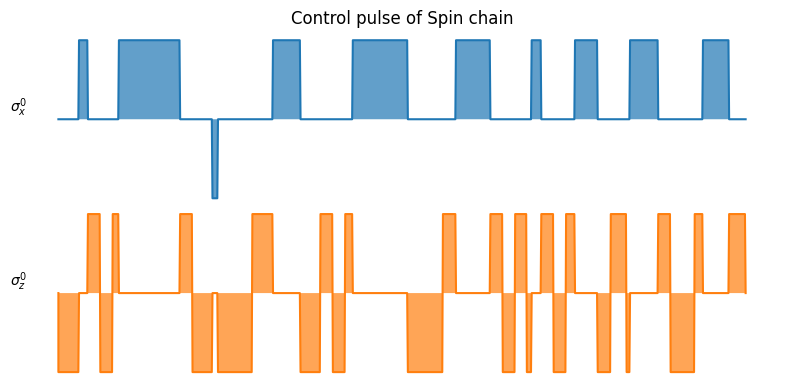

In [ ]:
my_processor.plot_pulses(title="Control pulse of Spin chain", figsize=(8, 4), dpi=100);

In [ ]:
y_test_spin_model[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.20442382+0.29102744j, 0.42195619+0.83394658j])

In [ ]:
def test_pulse(SO, state_labels=None, bias=None, entanglement = False):
  """
  Tests on a given set of data. This function predicts in function of max fidelity.
  Args:
      params (array[float]): array of parameters
      x (array[float]): 2-d array of input vectors
      y (array[float]): 1-d array of targets
      state_labels (array[float]): 1-d array of state representations for labels
  Returns:
      predicted (array([int]): predicted labels for test data
      output_states (array[float]): output quantum states from the circuit
  """
  fidelity_values = []
  dm_labels = [s for s in state_labels]
  #print(f'len labels = {len(dm_labels)}')
  predicted = []
  for state_output in SO:
    #fidel_function = lambda y: qcircuit(params, x[i], y)
    fidelities = []
    for dm in dm_labels:
      # fidelity_cost(model, params, x, y, state_labels=None)
      f = fidelity(qml.math.dm_from_state_vector(state_output.reshape(2)), qml.math.dm_from_state_vector(dm))
      fidelities.append(f)
    best_fidel = np.argmax(fidelities)
    predicted.append(best_fidel)
  return predicted

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
state_labels

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[ 1.       +0.j,  0.       +0.j],
        [ 0.5      +0.j,  0.8660254+0.j],
        [ 0.5      +0.j, -0.8660254+0.j]], requires_grad=False)

In [ ]:
out = y_test_spin_model[0].reshape(2)
out

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.20442382+0.29102744j, 0.42195619+0.83394658j])

In [ ]:
state_labels[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([1.+0.j, 0.+0.j], requires_grad=False)

In [ ]:
#y_test_spin_model
p = test_pulse(y_test_spin_model, state_labels)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
accuracy_test = accuracy_score(y_test, p)
accuracy_test

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.4888888888888889

In [ ]:
p

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 2,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 0,
 0,
 2,
 2,
 1,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [ ]:
predicted_test

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 1,
        0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
        0], requires_grad=True)

### Visualizacion en bloch sphere

explained variance ratio (first two components): [0.92461872 0.05306648]


<Figure size 500x500 with 0 Axes>

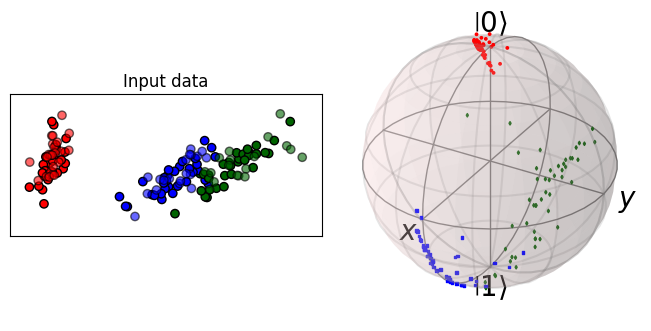

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure(constrained_layout=True)
ax1 = fig.add_subplot(1, 2, 1)
datasets = [make_IRIS(2)]
for ds_cnt, ds in enumerate(datasets):
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF", "#006400"])
    if ds_cnt == 0:
        ax1.set_title("Input data")
    # Plot the training points
    ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax1.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax1.set_xticks(())
    ax1.set_yticks(())
    ax1.set_aspect('equal')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
S = 3*np.ones((len(y)))
visualization_1_qubit(qcircuit_2_qubit, X, y, params, ax2, sz=S, bias=bias)
ax2.set_box_aspect([1, 1, 1])
plt.show()

## Training to Circlr v2 (2Ftr vs 3clss)

In [ ]:
X, y =  circle_v2(1500)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_train = np.hstack((X_train, np.zeros((X_train.shape[0], 1), requires_grad=False)))
X_test = np.hstack((X_test, np.zeros((X_test.shape[0], 1), requires_grad=False)))

In [ ]:
# Train using Adam optimizer and evaluate the classifier
num_layers = 10
learning_rate = 0.1
epochs = 12
batch_size = 32
# clases
n_clases = 3
state_labels = representatives(n_clases, 1)
# optimaz
opt = qml.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)
bias = np.random.uniform(size=(num_layers, 3), requires_grad=True)

In [ ]:
predicted_train, fidel_train = test(qcircuit_2_qubit, params, X_train, y_train, state_labels,bias)
accuracy_train = accuracy_score(y_train, predicted_train)
predicted_test, fidel_test = test(qcircuit_2_qubit, params, X_test, y_test, state_labels,bias)
accuracy_test = accuracy_score(y_test, predicted_test)
# save predictions with random weights for comparison
initial_predictions = predicted_test
loss = fidelity_cost(qcircuit_2_qubit,params, X_train, y_train, state_labels,bias)
print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

Epoch:  0 | Cost: 0.526360 | Train accuracy: 0.267619 | Test Accuracy: 0.293333


In [ ]:
for it in range(epochs):
  for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
    params, bias = opt.step(lambda p,b: fidelity_cost(qcircuit_2_qubit, p, Xbatch, ybatch, state_labels,b), params, bias)
  # Results by Epochs:
  predicted_train, fidel_train = test(qcircuit_2_qubit, params, X_train, y_train, state_labels, bias)
  # test(model, params, x, y, state_labels=None)
  accuracy_train = accuracy_score(y_train, predicted_train)
  loss = fidelity_cost(qcircuit_2_qubit,params, X_train, y_train, state_labels, bias)
  predicted_test, fidel_test = test(qcircuit_2_qubit, params, X_test, y_test, state_labels, bias)
  accuracy_test = accuracy_score(y_test, predicted_test)
  res = [it + 1, loss, accuracy_train, accuracy_test]
  print(
      "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
          *res
      )
  )

Epoch:  1 | Loss: 0.205814 | Train accuracy: 0.716190 | Test accuracy: 0.720000
Epoch:  2 | Loss: 0.188189 | Train accuracy: 0.760952 | Test accuracy: 0.762222
Epoch:  3 | Loss: 0.167578 | Train accuracy: 0.815238 | Test accuracy: 0.820000
Epoch:  4 | Loss: 0.167080 | Train accuracy: 0.811429 | Test accuracy: 0.797778
Epoch:  5 | Loss: 0.172784 | Train accuracy: 0.786667 | Test accuracy: 0.771111
Epoch:  6 | Loss: 0.179487 | Train accuracy: 0.780952 | Test accuracy: 0.773333
Epoch:  7 | Loss: 0.179850 | Train accuracy: 0.784762 | Test accuracy: 0.771111
Epoch:  8 | Loss: 0.178799 | Train accuracy: 0.786667 | Test accuracy: 0.764444
Epoch:  9 | Loss: 0.177590 | Train accuracy: 0.783810 | Test accuracy: 0.768889
Epoch: 10 | Loss: 0.175964 | Train accuracy: 0.788571 | Test accuracy: 0.777778
Epoch: 11 | Loss: 0.173110 | Train accuracy: 0.795238 | Test accuracy: 0.782222
Epoch: 12 | Loss: 0.168831 | Train accuracy: 0.795238 | Test accuracy: 0.780000


Cost: 0.168831 | Train accuracy 0.795238 | Test Accuracy : 0.780000
Learned weights
Layer 0: [-0.29889785  3.44451651  0.37410574]
Layer 1: [0.38438274 2.55998577 0.94074672]
Layer 2: [1.21627462 1.61481001 0.76561328]
Layer 3: [1.08338442 0.70607261 0.3696043 ]
Layer 4: [-0.08545983  1.25514273  0.77798612]
Layer 5: [-1.34346748  1.097719    0.97641562]
Layer 6: [-0.01112123  1.54163512  0.14315631]
Layer 7: [1.06452885 1.41272351 0.192232  ]
Layer 8: [0.03522865 1.29842904 0.55900654]
Layer 9: [ 0.97161438 -0.18748965  0.87113212]
Bias 0: [0.07801892 0.15631439 0.66134984]
Bias 1: [-0.06576121 -0.1955098   0.05910695]
Bias 2: [ 1.38860321  0.17523976 -0.55952335]
Bias 3: [1.00949184 1.06091163 0.12654056]
Bias 4: [-0.18011889  0.81695531  0.4931961 ]
Bias 5: [0.32869811 0.89313263 0.8804454 ]
Bias 6: [-0.0320095   0.88826663  0.62595692]
Bias 7: [1.66538513 0.603517   0.59063848]
Bias 8: [0.04824582 0.53376154 1.33230267]
Bias 9: [2.65853568 0.00354588 0.67425566]


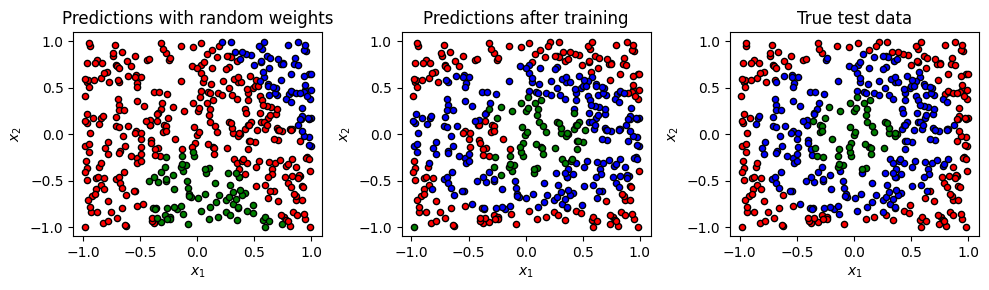

In [ ]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)
print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))

for i in range(num_layers):
    print("Bias {}: {}".format(i, bias[i]))

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data_v2(X_test, initial_predictions, fig, axes[0])
plot_data_v2(X_test, predicted_test, fig, axes[1])
plot_data_v2(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

### Visualizacion en bloch sphere

<Figure size 500x500 with 0 Axes>

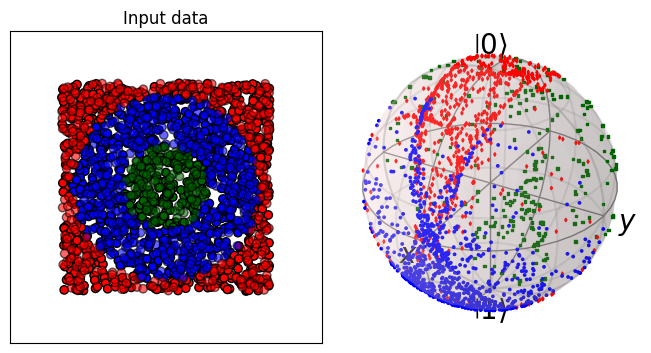

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True)
ax1 = fig.add_subplot(1, 2, 1)
datasets = [circle_v2(2000)]
for ds_cnt, ds in enumerate(datasets):
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF", "#006400"])
    if ds_cnt == 0:
        ax1.set_title("Input data")
    # Plot the training points
    ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax1.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax1.set_xticks(())
    ax1.set_yticks(())
    ax1.set_aspect('equal')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
S = 3*np.ones((len(y)))
visualization_1_qubit(qcircuit_2_qubit, X, y, params, ax2, sz=S, bias=bias)
ax2.set_box_aspect([1, 1, 1])
plt.show()

<Figure size 500x500 with 0 Axes>

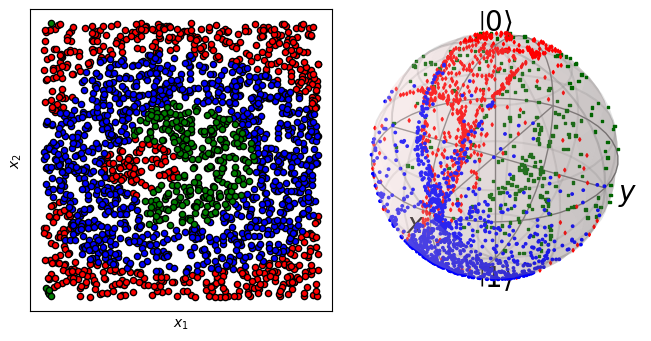

In [ ]:
# Propuesta para mostrar con mas puntos como esta prediciendo la red.
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True)
ax1 = fig.add_subplot(1, 2, 1)
X,y = circle_v2(2000)
X = np.hstack((X, np.zeros((X.shape[0], 1), requires_grad=False)))
predicted_test, fidel_test = test(qcircuit_2_qubit, params, X, y, state_labels, bias)
plot_data_v2(X, predicted_test, fig, ax1)
ax1.set_xticks(())
ax1.set_yticks(())
ax1.set_aspect('equal')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
S = 3*np.ones((len(y)))
visualization_1_qubit(qcircuit_2_qubit, X, y, params, ax2, sz=S, bias=bias)
ax2.set_box_aspect([1, 1, 1])
plt.show()

## Training to Iris (3Fr vs 3clss)

In [ ]:
# En esta sección se no se hace stack con 0 porque es un problema
# con datos en R^3.
X, y =  make_IRIS_v2(3,3)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [ ]:
X_train[0]

array([-0.18962247, -0.68028676, -0.30642056])

In [ ]:
# Train using Adam optimizer and evaluate the classifier
np.random.seed(42)
num_layers = 10
learning_rate = 0.1
epochs = 12
batch_size = 32
# clases
n_clases = 3
state_labels = representatives(n_clases, 1)
# optimaz
opt = qml.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)
bias = np.random.uniform(size=(num_layers, 3), requires_grad=True)

In [ ]:
params[0]

tensor([0.37454012, 0.95071431, 0.73199394], requires_grad=True)

In [ ]:
# ==============================================================
states_2_q_enten_1 = test_intra_states(qcircuit_2_qubit, params, X_train, y_train, state_labels, bias)
w_r_json('w', "/content/drive/MyDrive/Tesis/1_qubit_iris_3_3_before.json", file = states_2_q_enten_1)
# ===============================================================

[-0.18962247 -0.68028676 -0.30642056]


In [ ]:
states_2_q_enten_1[0]

{'ket_1_qubit_0': tensor([0.91596724+0.30124646j, 0.26173364-0.04183407j], requires_grad=True),
 'ket_1_qubit_1': tensor([0.67147391-0.39437603j, 0.55770115+0.28733214j], requires_grad=True),
 'ket_1_qubit_2': tensor([0.61083621-0.46871904j, 0.6094426 +0.18910659j], requires_grad=True),
 'ket_1_qubit_3': tensor([0.43459178-0.58280102j, 0.65656169+0.20099675j], requires_grad=True),
 'ket_1_qubit_4': tensor([0.15564561-0.71603006j, 0.45098113+0.50959926j], requires_grad=True),
 'ket_1_qubit_5': tensor([-0.13066032-0.87057631j,  0.32561532+0.34496294j], requires_grad=True),
 'ket_1_qubit_6': tensor([-0.47394592-0.83995381j,  0.06244842+0.25681327j], requires_grad=True),
 'ket_1_qubit_7': tensor([-0.87963452-0.35570275j, -0.30258097-0.09035164j], requires_grad=True),
 'ket_1_qubit_8': tensor([-0.82428797-0.15264755j, -0.47121037-0.27424232j], requires_grad=True),
 'ket_1_qubit_9': tensor([-0.80203003-0.15127625j, -0.51769131-0.25663014j], requires_grad=True),
 'execution_results': tensor([

In [ ]:
predicted_train, fidel_train = test(qcircuit_2_qubit, params, X_train, y_train, state_labels,bias)
accuracy_train = accuracy_score(y_train, predicted_train)
predicted_test, fidel_test = test(qcircuit_2_qubit, params, X_test, y_test, state_labels,bias)
accuracy_test = accuracy_score(y_test, predicted_test)
# save predictions with random weights for comparison
initial_predictions = predicted_test
loss = fidelity_cost(qcircuit_2_qubit,params, X_train, y_train, state_labels,bias)
print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

Epoch:  0 | Cost: 0.606989 | Train accuracy: 0.323810 | Test Accuracy: 0.288889


In [ ]:
for it in range(epochs):
  for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
    params, bias = opt.step(lambda p,b: fidelity_cost(qcircuit_2_qubit, p, Xbatch, ybatch, state_labels,b), params, bias)
  # Results by Epochs:
  predicted_train, fidel_train = test(qcircuit_2_qubit, params, X_train, y_train, state_labels, bias)
  # test(model, params, x, y, state_labels=None)
  accuracy_train = accuracy_score(y_train, predicted_train)
  loss = fidelity_cost(qcircuit_2_qubit,params, X_train, y_train, state_labels, bias)
  predicted_test, fidel_test = test(qcircuit_2_qubit, params, X_test, y_test, state_labels, bias)
  accuracy_test = accuracy_score(y_test, predicted_test)
  res = [it + 1, loss, accuracy_train, accuracy_test]
  print(
      "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
          *res
      )
  )

Epoch:  1 | Loss: 0.296694 | Train accuracy: 0.676190 | Test accuracy: 0.622222
Epoch:  2 | Loss: 0.196492 | Train accuracy: 0.819048 | Test accuracy: 0.777778
Epoch:  3 | Loss: 0.167490 | Train accuracy: 0.876190 | Test accuracy: 0.822222
Epoch:  4 | Loss: 0.159089 | Train accuracy: 0.847619 | Test accuracy: 0.844444
Epoch:  5 | Loss: 0.107099 | Train accuracy: 0.933333 | Test accuracy: 0.955556
Epoch:  6 | Loss: 0.098374 | Train accuracy: 0.914286 | Test accuracy: 0.888889
Epoch:  7 | Loss: 0.085773 | Train accuracy: 0.952381 | Test accuracy: 0.955556
Epoch:  8 | Loss: 0.073770 | Train accuracy: 0.952381 | Test accuracy: 0.955556
Epoch:  9 | Loss: 0.064120 | Train accuracy: 0.961905 | Test accuracy: 0.955556
Epoch: 10 | Loss: 0.062582 | Train accuracy: 0.942857 | Test accuracy: 0.955556
Epoch: 11 | Loss: 0.060007 | Train accuracy: 0.971429 | Test accuracy: 0.977778
Epoch: 12 | Loss: 0.054144 | Train accuracy: 0.971429 | Test accuracy: 1.000000


In [ ]:
# ==============================================================
states_2_q_enten_1 = test_intra_states(qcircuit_2_qubit, params, X_train, y_train, state_labels, bias)
w_r_json('w', "/content/drive/MyDrive/Tesis/1_qubit_iris_3_3_after.json", file = states_2_q_enten_1)
# ===============================================================

[-0.18962247 -0.68028676 -0.30642056]


Cost: 0.046693 | Train accuracy 0.971429 | Test Accuracy : 1.000000
Learned weights
Layer 0: [0.310953   0.21794019 0.14270036]
Layer 1: [ 0.07267567  0.13542513 -0.33038051]
Layer 2: [ 0.23242866 -0.28869437 -0.21815333]
Layer 3: [-0.40057895 -0.02428822  0.76776544]
Layer 4: [0.13223108 0.98586965 0.50094114]
Layer 5: [ 0.77468914 -0.1610826  -0.38873984]
Layer 6: [-0.08586689 -0.26299807 -0.11479501]
Layer 7: [0.61768457 0.05371959 0.86185972]
Layer 8: [-0.20783164 -0.42250494 -0.46554856]
Layer 9: [0.55829906 0.0305493  0.05192572]
Bias 0: [0.23580312 0.98072166 0.00567511]
Bias 1: [0.55102648 0.96576064 0.82100471]
Bias 2: [0.93418276 1.458817   1.33781182]
Bias 3: [-0.0256993   0.98852148  1.33137494]
Bias 4: [0.77816621 0.75346742 1.45312912]
Bias 5: [1.23785584 0.20466452 0.67955165]
Bias 6: [ 0.9377169   0.95449093 -0.09986652]
Bias 7: [0.82604823 0.44344901 1.16352003]
Bias 8: [ 0.40275535  0.94596109 -0.14459128]
Bias 9: [0.69236341 0.77430326 0.37615988]


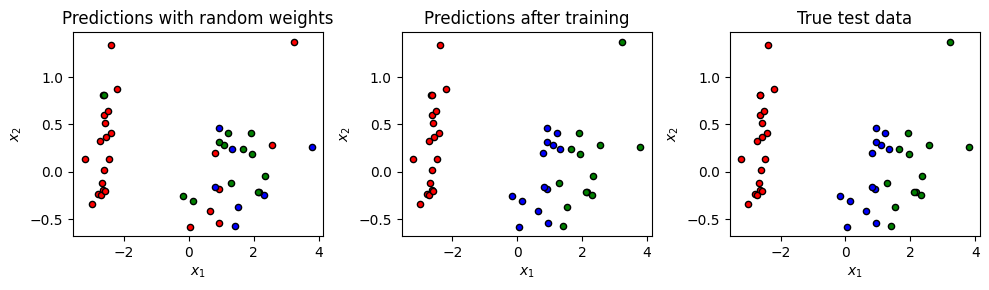

In [ ]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)
print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))

for i in range(num_layers):
    print("Bias {}: {}".format(i, bias[i]))

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data_v2(X_test, initial_predictions, fig, axes[0])
plot_data_v2(X_test, predicted_test, fig, axes[1])
plot_data_v2(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

### Visualizacion en bloch sphere

<Figure size 500x500 with 0 Axes>

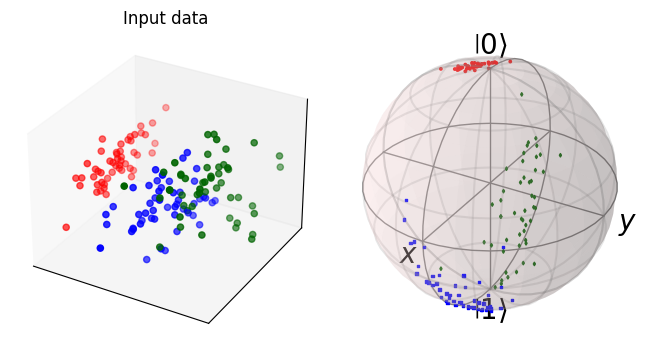

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
datasets = [make_IRIS_v2(3,3)]
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    z_min, z_max = X[:, 2].min() - 0.5, X[:, 2].max() + 0.5
    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF", "#006400"])
    if ds_cnt == 0:
        ax1.set_title("Input data")
    ax1.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train, cmap=cm_bright, marker='o')
    ax1.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_test, cmap=cm_bright, marker='o')
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax1.set_ylim(z_min, z_max)
    ax1.set_xticks(())
    ax1.set_yticks(())
    ax1.set_zticks(())

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
S = 3*np.ones((len(y)))
visualization_1_qubit(qcircuit_2_qubit, X, y, params, ax2, sz = S, bias = bias)
ax2.set_box_aspect([1, 1, 1])
plt.show()

# 9. Pruebas con ruido

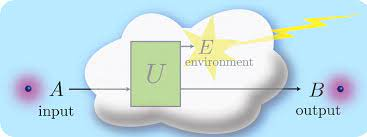

Interaction with the environment can lead to changes in the state populations of a qubit.
This is the phenomenon behind scattering, dissipation, attenuation, and spontaneous emission.
It can be modelled by the amplitude damping channel, with the following Kraus matrices:

 \begin{split}K_0 = \begin{bmatrix}
        1 & 0 \\
        0 & \sqrt{1-\gamma}
        \end{bmatrix}\end{split}
        

\begin{split}K_1 = \begin{bmatrix}
        0 & \sqrt{\gamma}  \\
        0 & 0
        \end{bmatrix}\end{split}

where γ∈[0,1] is the amplitude damping probability.

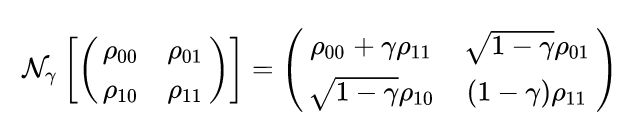

NOTA: cuando el device es "mixed" arroja state como matriz densidad.

## Modelo con ruido

In [ ]:
dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev, interface=None)
def qcircuit_2_qubit_noise(params, x, bias=None):
    global alpha
    """A variational quantum circuit representing the Universal classifier.
    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
    Returns:
        float: qml state
    """
    for i,p in enumerate(params):
      arg = np.multiply(p,x) + bias[i]
      qml.Rot(*arg , wires=0) # RZ * RY * RZ -> data
      qml.AmplitudeDamping(alpha, wires=0)
    return qml.state()

## Pruebas con varios $\gamma$ vs profundidad.

In [ ]:
alpha_dict = {}
def agregar_dato_alpha(key, dato):
      alpha_dict.setdefault(key, []).append(dato)

layers_dict = {}
def agregar_dato_layer(key, dato):
      layers_dict.setdefault(key, []).append(dato)

Para esta prueba se utiliza IRIS con 3 caracteristicas y 3 componentes.

In [ ]:
# En esta sección se no se hace stack con 0 porque es un problema
# con datos en R^3.
X, y =  make_IRIS_v2(3,3)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
# ===============================================================
# Train using Adam optimizer and evaluate the classifier
#num_layers = 10
learning_rate = 0.1
epochs = 8
batch_size = 32
# clases
n_clases = 3
state_labels = representatives(n_clases, 1)
# optimaz
opt = qml.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
# PRUEBA
for num_layers in [3, 5, 7, 8, 10]:
  alpha_dict = {}
  opt = qml.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
  for alpha in [0.05, 0.1, 0.3, 0.6, 0.9]:
    # initialize random weights
    params = np.random.uniform(size=(num_layers, 3), requires_grad=True)
    bias = np.random.uniform(size=(num_layers, 3), requires_grad=True)
    # ===============================================================
    predicted_train, fidel_train = test(qcircuit_2_qubit_noise, params, X_train, y_train, state_labels,bias)
    accuracy_train = accuracy_score(y_train, predicted_train)
    predicted_test, fidel_test = test(qcircuit_2_qubit_noise, params, X_test, y_test, state_labels,bias)
    accuracy_test = accuracy_score(y_test, predicted_test)
    # save predictions with random weights for comparison
    initial_predictions = predicted_test
    loss = fidelity_cost(qcircuit_2_qubit_noise,params, X_train, y_train, state_labels,bias)
    # AGREGAR DATO:
    agregar_dato_alpha(alpha, loss)
    print(
        "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
            0, loss, accuracy_train, accuracy_test
        )
    )
    for it in range(epochs):
      for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, bias = opt.step(lambda p,b: fidelity_cost(qcircuit_2_qubit_noise, p, Xbatch, ybatch, state_labels,b), params, bias)
      # Results by Epochs:
      predicted_train, fidel_train = test(qcircuit_2_qubit_noise, params, X_train, y_train, state_labels, bias)
      # test(model, params, x, y, state_labels=None)
      accuracy_train = accuracy_score(y_train, predicted_train)
      loss = fidelity_cost(qcircuit_2_qubit_noise,params, X_train, y_train, state_labels, bias)
      # AGREGAR DATO:
      agregar_dato_alpha(alpha, loss)
      predicted_test, fidel_test = test(qcircuit_2_qubit_noise, params, X_test, y_test, state_labels, bias)
      accuracy_test = accuracy_score(y_test, predicted_test)
      res = [it + 1, loss, accuracy_train, accuracy_test]
      print(
          "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
              *res
          )
      )
  agregar_dato_layer(num_layers, alpha_dict)



Epoch:  0 | Cost: 0.429907 | Train accuracy: 0.238095 | Test Accuracy: 0.311111
Epoch:  1 | Loss: 0.230058 | Train accuracy: 0.323810 | Test accuracy: 0.400000
Epoch:  2 | Loss: 0.105718 | Train accuracy: 0.695238 | Test accuracy: 0.777778
Epoch:  3 | Loss: 0.068832 | Train accuracy: 0.752381 | Test accuracy: 0.733333
Epoch:  4 | Loss: 0.050757 | Train accuracy: 0.790476 | Test accuracy: 0.711111
Epoch:  5 | Loss: 0.038036 | Train accuracy: 0.923810 | Test accuracy: 0.911111
Epoch:  6 | Loss: 0.043796 | Train accuracy: 0.876190 | Test accuracy: 0.911111
Epoch:  7 | Loss: 0.039739 | Train accuracy: 0.885714 | Test accuracy: 0.933333
Epoch:  8 | Loss: 0.028285 | Train accuracy: 0.923810 | Test accuracy: 0.977778
Epoch:  0 | Cost: 0.403811 | Train accuracy: 0.238095 | Test Accuracy: 0.266667
Epoch:  1 | Loss: 0.346666 | Train accuracy: 0.247619 | Test accuracy: 0.266667
Epoch:  2 | Loss: 0.301014 | Train accuracy: 0.295238 | Test accuracy: 0.288889
Epoch:  3 | Loss: 0.261120 | Train accur

In [ ]:
import json
# Abre el archivo en modo escritura
with open("datos_layer.json", "w") as archivo:
    # Guarda el diccionario en el archivo JSON
    json.dump(layers_dict, archivo)

In [ ]:
import json

# Opening JSON file
with open("datos_layer.json") as json_file:
    data = json.load(json_file)

In [ ]:
data

{'5': [{'0.3': [0.4081230954136605,
    0.24931002509594655,
    0.1517337496892659,
    0.10890103169650135,
    0.10109217297857526],
   '0.6': [0.4115003360847279,
    0.39832670370200307,
    0.3594177645543696,
    0.30771310730388657,
    0.26470248376193106]},
  {'0.05': [0.2612064649251656,
    0.0982160834656794,
    0.051743130708270094,
    0.046481181427315124,
    0.05489185980811353,
    0.05130692139460975,
    0.044288482264095375,
    0.03807626205076923,
    0.03697738529195501],
   '0.1': [0.364426695177709,
    0.250915641974123,
    0.13738004870583065,
    0.09176924818366293,
    0.09482956687583997,
    0.07441931983843099,
    0.05580751592203481,
    0.05944488650330115,
    0.053981549508382375],
   '0.3': [0.3558885060832564,
    0.3001804429715748,
    0.21230155514123233,
    0.15902345175576518,
    0.12350274088590893,
    0.10562638814909296,
    0.10103520436938444,
    0.10110450311261379,
    0.09766619314350988],
   '0.6': [0.3822378943135323,
    0

In [ ]:
import matplotlib.pyplot as plt

5
[{'0.3': [0.4081230954136605, 0.24931002509594655, 0.1517337496892659, 0.10890103169650135, 0.10109217297857526], '0.6': [0.4115003360847279, 0.39832670370200307, 0.3594177645543696, 0.30771310730388657, 0.26470248376193106]}, {'0.05': [0.2612064649251656, 0.0982160834656794, 0.051743130708270094, 0.046481181427315124, 0.05489185980811353, 0.05130692139460975, 0.044288482264095375, 0.03807626205076923, 0.03697738529195501], '0.1': [0.364426695177709, 0.250915641974123, 0.13738004870583065, 0.09176924818366293, 0.09482956687583997, 0.07441931983843099, 0.05580751592203481, 0.05944488650330115, 0.053981549508382375], '0.3': [0.3558885060832564, 0.3001804429715748, 0.21230155514123233, 0.15902345175576518, 0.12350274088590893, 0.10562638814909296, 0.10103520436938444, 0.10110450311261379, 0.09766619314350988], '0.6': [0.3822378943135323, 0.36554154604192607, 0.31730996272593864, 0.2584351470434373, 0.21442555958716805, 0.18761978445698588, 0.1747128314436606, 0.17486502031810305, 0.1785

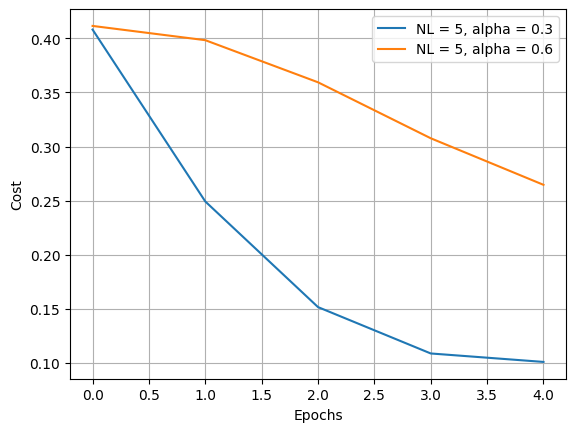

7
[{'0.3': [0.42947240626514793, 0.22211856310675263, 0.16439618710787163, 0.15004391624658225, 0.13028859509475393], '0.6': [0.3618446289263371, 0.346304026392866, 0.3167791362077659, 0.2834721982010543, 0.24616638843525565]}, {'0.05': [0.3341228100860039, 0.10495229822443057, 0.0780568277634236, 0.061471361994640795, 0.050509111290030634, 0.03819756040354918, 0.03726675269675245, 0.03352741347755987, 0.02827023231162908], '0.1': [0.48323023894092587, 0.22412646485705778, 0.082713190469445, 0.07667812418599743, 0.07353869409221228, 0.05963358865863997, 0.05815550725192483, 0.04652686634764027, 0.03309925930708007], '0.3': [0.3741086250855335, 0.3156789590010516, 0.2182267830334164, 0.1419154808583945, 0.12090380793551048, 0.11155399212662469, 0.10394314493333251, 0.10622842632581893, 0.1008658284685569], '0.6': [0.37541456293211045, 0.35949074147842414, 0.32467460500959855, 0.2781591543001998, 0.23766965640662824, 0.21643352422725165, 0.20870279407769968, 0.20526606589628416, 0.202753

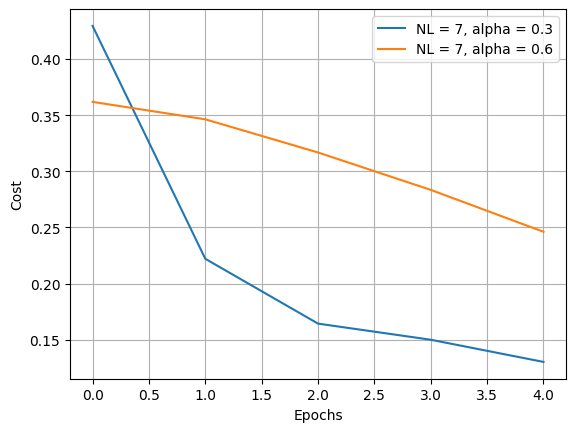

3
[{'0.05': [0.4299065239684199, 0.23005844720720478, 0.10571768237220634, 0.06883150550982718, 0.050757216003402314, 0.038035794870004046, 0.043795631138770184, 0.03973893846007048, 0.02828531132945675], '0.1': [0.40381081732022245, 0.3466655374392983, 0.3010142165913432, 0.26111953525994575, 0.23555668056685772, 0.22483245374732477, 0.2115545352024212, 0.2001073256862676, 0.19570383650313397], '0.3': [0.4311895338566799, 0.387811317983037, 0.3036119533800001, 0.2243953113867658, 0.14609419508804947, 0.10821197067917335, 0.09706702342639176, 0.09897193157226318, 0.09639192213484758], '0.6': [0.38016326413806917, 0.3549801848577651, 0.30052759016689795, 0.2513592761064297, 0.2308128070245132, 0.22534290447294142, 0.2265179413107483, 0.2265664331797783, 0.22054341920556084], '0.9': [0.41386917597024964, 0.4126436003800515, 0.4103263060351727, 0.4071156461802023, 0.40304162919471714, 0.3980339262976306, 0.3919808657608676, 0.38485165598921545, 0.37687904451237314]}]
[0.4299065239684199, 

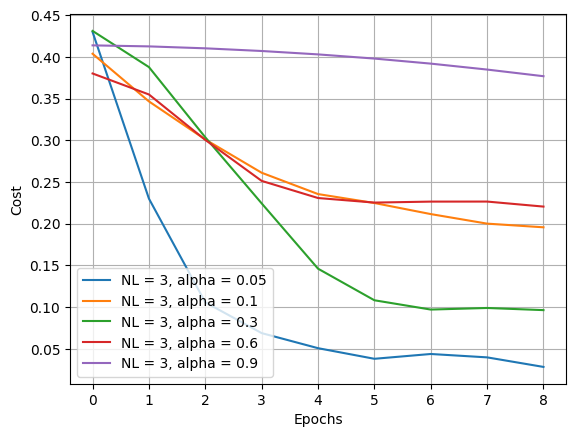

8
[{'0.05': [0.44062630839280237, 0.1718202279431209, 0.13303022132172806, 0.05694832636036291, 0.053269560330392006, 0.05735597746628892, 0.0412695779103024, 0.035299260627632174, 0.03049980074993332], '0.1': [0.48281435277476464, 0.24974021735010643, 0.14732892956025764, 0.09698989219031574, 0.07942226530263698, 0.09211725051792595, 0.06449242627362206, 0.05056080612783032, 0.039089139859702], '0.3': [0.384860437500897, 0.3318293548411022, 0.2392176375653985, 0.17583252324299953, 0.14148359281546447, 0.13775675323535486, 0.13623735803741932, 0.12718193591853177, 0.11335090806783883], '0.6': [0.39631716362013936, 0.36638029964200536, 0.31486807585181864, 0.2577277144682439, 0.21532921471073452, 0.19741565503376637, 0.19253640717247597, 0.18738432581842426, 0.18123733835628902], '0.9': [0.39864063968799307, 0.39612997439497954, 0.3930174752504704, 0.38964928261762993, 0.38611447965826035, 0.38230145024622997, 0.3779903730188799, 0.37298467307766225, 0.3672519243912787]}]
[0.44062630839

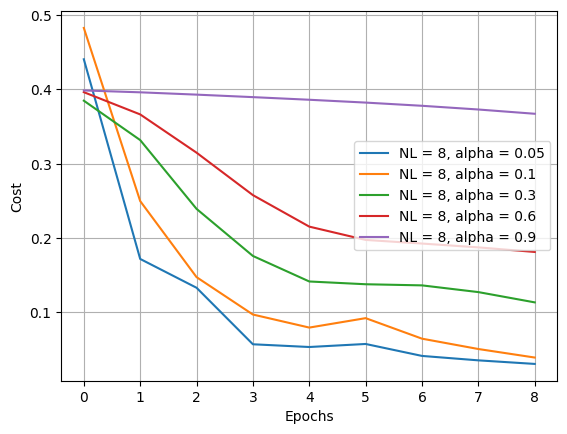

10
[{'0.05': [0.38092573959211323, 0.23266780338131388, 0.1033323671666565, 0.10338628121486965, 0.05069183546378811, 0.0633698840959858, 0.03612239007535041, 0.041223289212840464, 0.027934411960944882], '0.1': [0.3970921865528966, 0.2763144166372272, 0.2001926462227716, 0.1454856414210059, 0.15086455226643702, 0.1083966000005517, 0.0895266457712943, 0.08842763209264519, 0.07564063529036773], '0.3': [0.5064991129006315, 0.4243947588416151, 0.2151254723149586, 0.17905249802405263, 0.18480141006737608, 0.14012092489362094, 0.12587945069254983, 0.12929145674117376, 0.1147578075903685], '0.6': [0.40761489936933987, 0.3984476332821288, 0.3732216748630243, 0.3340318590983591, 0.28872179162631284, 0.25086058489451335, 0.22731367848498746, 0.21342235142659793, 0.20446297286065787], '0.9': [0.3993878034027982, 0.39356610314139395, 0.38682034209446814, 0.3792704690072872, 0.3709534500347561, 0.3621371538553505, 0.35347258885661126, 0.3458050600233803, 0.33976184732191655]}]
[0.38092573959211323,

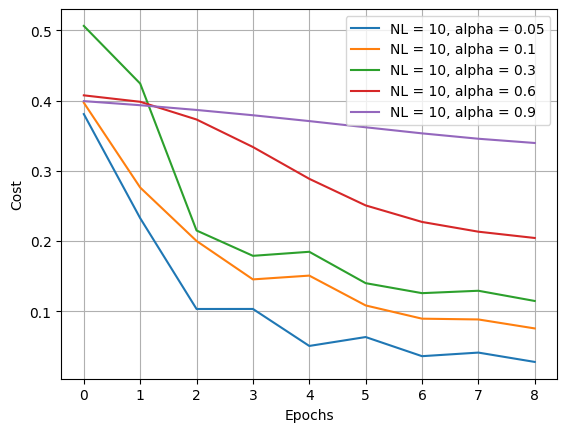

In [ ]:
for key in data:
  print(key)
  print(data[key])
  dict_data = data[key][0]
  plt.figure()
  for alpha in dict_data:
    print(dict_data[alpha])
    list_alpha = dict_data[alpha]
    plt.plot(list_alpha, label = f"NL = {key}, alpha = {alpha}")
    plt.ylabel("Cost")
    plt.xlabel('Epochs')
  plt.legend()
  plt.grid()
  plt.show()


In [ ]:
layers_dict

{}

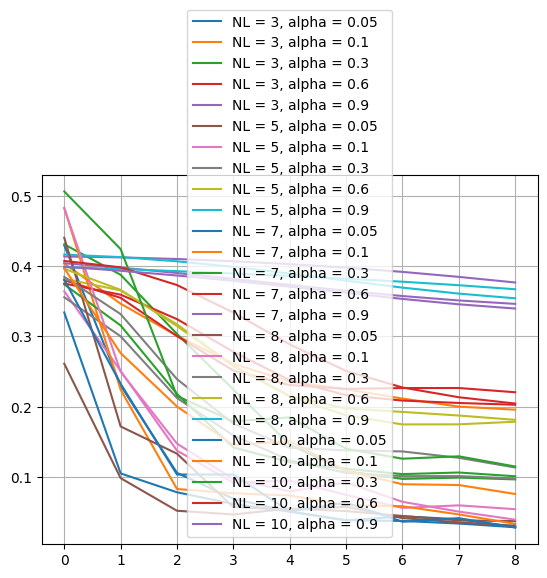

In [ ]:
plt.figure()
for num_layers in [3, 5, 7, 8, 10]:
  dict_alpha = data[str(num_layers)]
  for alpha in [0.05, 0.1, 0.3, 0.6, 0.9]:
    try:
      list_alpha = dict_alpha[1][str(alpha)]
    except:
      list_alpha = dict_alpha[0][str(alpha)]
    plt.plot(list_alpha, label = f"NL = {num_layers}, alpha = {alpha}")
   #plt.text(0.5, 0.5, f"NL = {num_layers}, alpha = {alpha}")
plt.legend()
plt.grid()
plt.show()


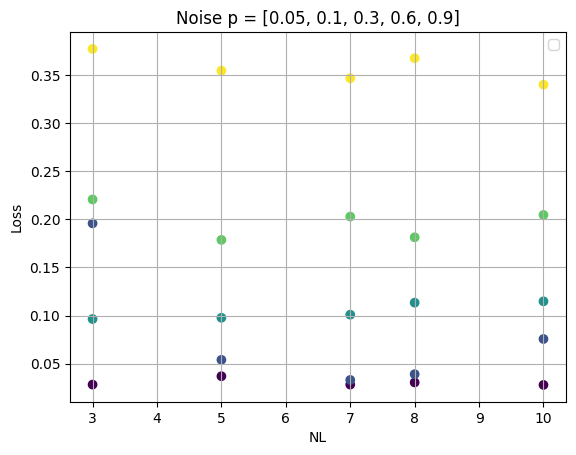

In [ ]:
plt.figure()
X = []
Y = []
Color = []
for num_layers in [3, 5, 7, 8, 10]:
  dict_alpha = data[str(num_layers)]
  for alpha in [0.05, 0.1, 0.3, 0.6, 0.9]:
    try:
      list_alpha =  dict_alpha[1][str(alpha)]
    except:
      list_alpha =  dict_alpha[0][str(alpha)]
    end_loss = list_alpha[-1]
    X.append(num_layers)
    Y.append(end_loss)
  Color.extend([1,2,3,4,5])

plt.scatter(X,Y, c=Color)
plt.legend()
plt.xlabel("NL")
plt.ylabel("Loss")
plt.title("Noise p = [0.05, 0.1, 0.3, 0.6, 0.9]")
plt.grid()
plt.show()

# 10. Multiple qubits

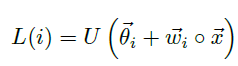

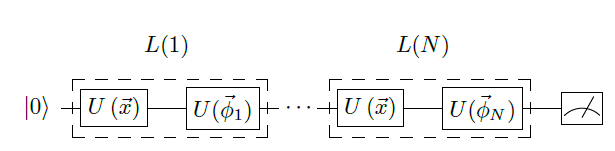

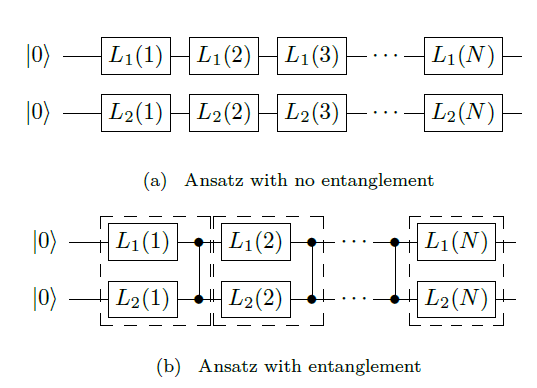

## Measure

Para un caso en el cual se utilizan 2 qubits por ejemplo, existen 4 estados bases que se pueden usar para representar las etiquetas de maximo, 4 clases en los estados bases $|00⟩$, $|01⟩$, $|10⟩$ y $|11⟩$.

In [ ]:
from qutip import *

In [ ]:
up = basis(2,0)
down = basis(2,0)

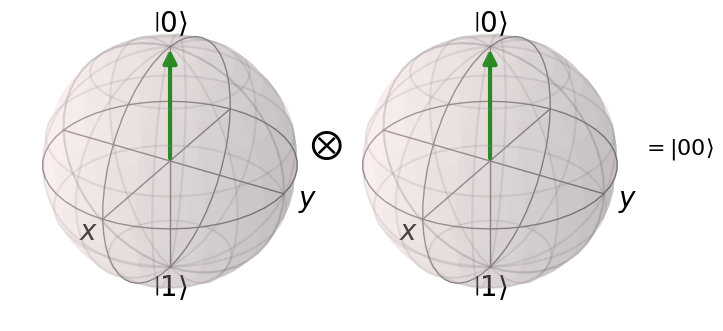

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True)

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
b = Bloch()
b.axes = ax1
b.fig = fig
b.add_states(up)
b.render()
ax1.set_box_aspect([1, 1, 1])

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
b = Bloch()
b.axes = ax2
b.fig = fig
b.add_states(down)
b.render()
ax2.set_box_aspect([1, 1, 1])

# Agregar símbolo de LaTeX entre las dos gráficas
text_pos = ((ax1.get_position().x1 + ax2.get_position().x0) / 2, (ax1.get_position().y1 + ax2.get_position().y1) / 2)
fig.text(text_pos[0], text_pos[1]-0.3, r'$\bigotimes $', fontsize=16, ha='center')

# Agregar símbolo de LaTeX entre las dos gráficas
text_pos = ((ax1.get_position().x1 + ax2.get_position().x0) / 2, (ax1.get_position().y1 + ax2.get_position().y1) / 2)
fig.text(text_pos[0]+0.55, text_pos[1]-0.3, r'$=  |00 \rangle$', fontsize=16, ha='center')

plt.show()

## Modelo con 2 qubits

In [ ]:
dev = qml.device("default.qubit", wires=2)
@qml.qnode(dev, interface="autograd")
def qcircuit_2_qubit_entanglement(params, x, bias = None, entanglement = False):
    """A variational quantum circuit representing the Universal classifier.
    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
    Returns:
        float: qml state
    """
    n_layer = len(params) // 2
    print(f"N_layers = {n_layer}")
    for i in range(n_layer):
      arg_1 = np.multiply(params[i],x) + bias[i]
      arg_2 = np.multiply(params[i + n_layer],x) + bias[i + n_layer]
      qml.Rot(*arg_1 , wires=0) # RZ * RY * RZ -> data
      qml.Rot(*arg_2 , wires=1) # RZ * RY * RZ -> data
      qml.Snapshot(f"ket_2_qubits_{i}")
      if entanglement == True:
        qml.CZ(wires=[0,1])
        qml.Snapshot(f"ket_2_qubits_entanglement_{i}")
    return qml.state()

## Modelo con 4 qubits

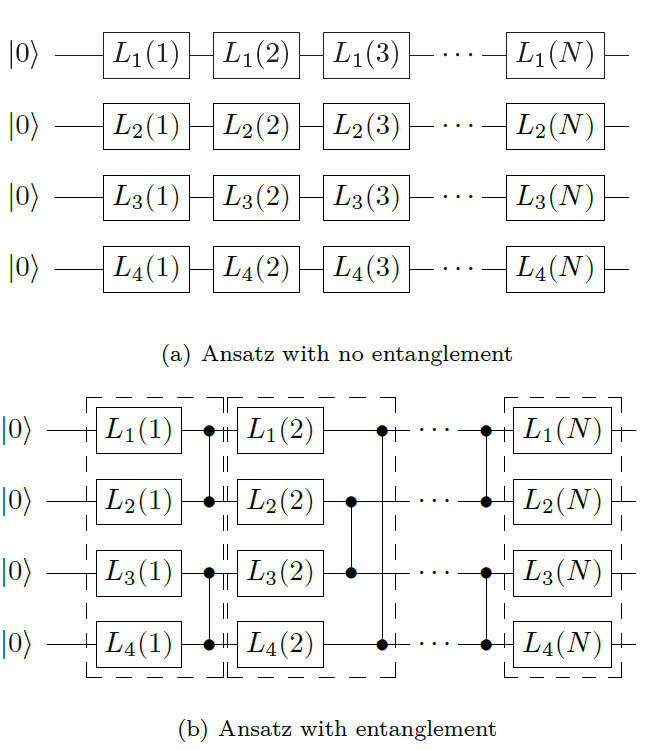

In [ ]:
dev = qml.device("default.qubit", wires=4)
@qml.qnode(dev, interface="autograd")
def qcircuit_4_qubit_entanglement(params, x, bias = None, entanglement = False):
    """A variational quantum circuit representing the Universal classifier.
    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
    Returns:
        float: qml state
    """
    n_layer = len(params) // 4
    print(f"N_layers = {n_layer}")
    #n_entenglaments = 0
    for i in range(n_layer):
      arg_1 = np.multiply(params[i],x) + bias[i]
      arg_2 = np.multiply(params[i + n_layer],x) + bias[i + n_layer]
      arg_3 = np.multiply(params[i + 2*n_layer],x) + bias[i + 2*n_layer]
      arg_4 = np.multiply(params[i + 3*n_layer],x) + bias[i + 3*n_layer]
      qml.Rot(*arg_1 , wires=0) # RZ * RY * RZ -> data
      qml.Rot(*arg_2 , wires=1) # RZ * RY * RZ -> data
      qml.Rot(*arg_3 , wires=2) # RZ * RY * RZ -> data
      qml.Rot(*arg_4 , wires=3) # RZ * RY * RZ -> data
      qml.Snapshot(f"ket_4_qubits_{i}")
      if entanglement == True:
        if i % 2 == 0 and i < n_layer-1:
          # par:
          qml.CZ(wires=[0,1])
          qml.CZ(wires=[2,3])
          qml.Snapshot(f"ket_4_qubits_entanglement_par{i}")
          #n_entenglaments += 1
        elif i < n_layer-1:
          # impar:
          qml.CZ(wires=[1,2])
          qml.CZ(wires=[0,3])
          qml.Snapshot(f"ket_4_qubits_entanglement_impar{i}")
          #n_entenglaments += 1
    #verb = 1
    #if verb == 1:
    #  print(f"n_entenglaments = {n_entenglaments}")
    #  verb = 0
    return qml.state()

## Prueba con IRIS 3clases vs 3features - Sin entrelazamiento

In [ ]:
_# En esta sección se no se hace stack con 0 porque es un problema
# con datos en R^3.
X, y =  make_IRIS_v2(3,3)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [ ]:
X_train[0]

array([-0.18962247, -0.68028676, -0.30642056])

In [ ]:
# ===============================================================
# Train using Adam optimizer and evaluate the classifier
np.random.seed(42)
num_layers = 10
learning_rate = 0.1
epochs = 12
batch_size = 32
# clases
n_clases = 3
state_labels = representatives(n_clases, 2)
# optimaz
opt = qml.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
# initialize random weights
params = np.random.uniform(size=(2*num_layers, 3), requires_grad=True)
bias = np.random.uniform(size=(2*num_layers, 3), requires_grad=True)

In [ ]:
params[0]

tensor([0.37454012, 0.95071431, 0.73199394], requires_grad=True)

In [ ]:
/content/drive/MyDrive/Tesis/

In [ ]:
states_2_q_wo_enten_1 = test_intra_states(qcircuit_2_qubit_entanglement, params, X_train, y_train, state_labels, bias, False)
w_r_json('w', "/content/drive/MyDrive/Tesis/2_qubits_sin_entrelazamiento_3_3_iris.json", file = states_2_q_wo_enten_1)

[-0.18962247 -0.68028676 -0.30642056]
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers =

In [ ]:
# Borrar con la nueva version embebida
list_new = []
for dict_i in states_2_q_wo_enten_1:
  json_errors = {k: [v.numpy().real.tolist(), v.numpy().imag.tolist()] for k, v in dict_i.items()}
  list_new.append(json_errors)
w_r_json('w', "states_2_q_wo_enten_1_before.json", file = list_new)

In [ ]:
# ===============================================================
predicted_train, fidel_train = test(qcircuit_2_qubit_entanglement, params, X_train, y_train, state_labels, bias)
accuracy_train = accuracy_score(y_train, predicted_train)
predicted_test, fidel_test = test(qcircuit_2_qubit_entanglement, params, X_test, y_test, state_labels, bias)
accuracy_test = accuracy_score(y_test, predicted_test)
# save predictions with random weights for comparison
initial_predictions = predicted_test
loss = fidelity_cost(qcircuit_2_qubit_entanglement,params, X_train, y_train, state_labels,bias)
print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_laye

Se han truncado las últimas 5000 líneas del flujo de salida.
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N

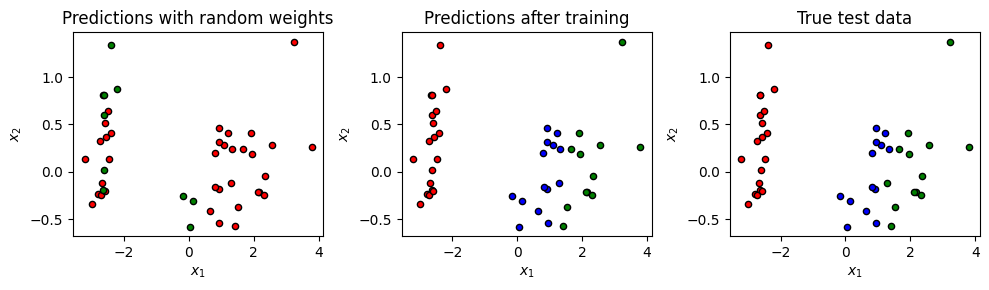

In [ ]:
# ===============================================================
for it in range(epochs):
  for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
    params, bias = opt.step(lambda p,b: fidelity_cost(qcircuit_2_qubit_entanglement, p, Xbatch, ybatch, state_labels,b), params, bias)
  # Results by Epochs:
  predicted_train, fidel_train = test(qcircuit_2_qubit_entanglement, params, X_train, y_train, state_labels, bias)
  # test(model, params, x, y, state_labels=None)
  accuracy_train = accuracy_score(y_train, predicted_train)
  loss = fidelity_cost(qcircuit_2_qubit_entanglement,params, X_train, y_train, state_labels, bias)
  predicted_test, fidel_test = test(qcircuit_2_qubit_entanglement, params, X_test, y_test, state_labels, bias)
  accuracy_test = accuracy_score(y_test, predicted_test)
  res = [it + 1, loss, accuracy_train, accuracy_test]
  print(
      "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
          *res
      )
  )
# ==============================================================
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)
print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data_v2(X_test, initial_predictions, fig, axes[0])
plot_data_v2(X_test, predicted_test, fig, axes[1])
plot_data_v2(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()


In [ ]:
states_2_q_wo_enten_1_after = test_intra_states(qcircuit_2_qubit_entanglement, params, X_train, y_train, state_labels, bias, False)

[-0.18962247 -0.68028676 -0.30642056]
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers =

In [ ]:
"""
list_new = []
for dict_i in states_2_q_wo_enten_1_after:
  json_errors = {k: [v.numpy().real.tolist(), v.numpy().imag.tolist()] for k, v in dict_i.items()}
  list_new.append(json_errors)
w_r_json('w', "states_2_q_wo_enten_1_after.json", file = list_new)
"""

In [ ]:
states_2_q_wo_enten_1_after = test_intra_states(qcircuit_2_qubit_entanglement, params, X_train, y_train, state_labels, bias, False)
w_r_json('w', "/content/drive/MyDrive/Tesis/2_qubits_sin_entrelazamiento_3_3_iris_after.json", file = states_2_q_wo_enten_1_after)

## Prueba circulo 3 clases vs 2 features - Con entrelazamiento

Se han truncado las últimas 5000 líneas del flujo de salida.
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N

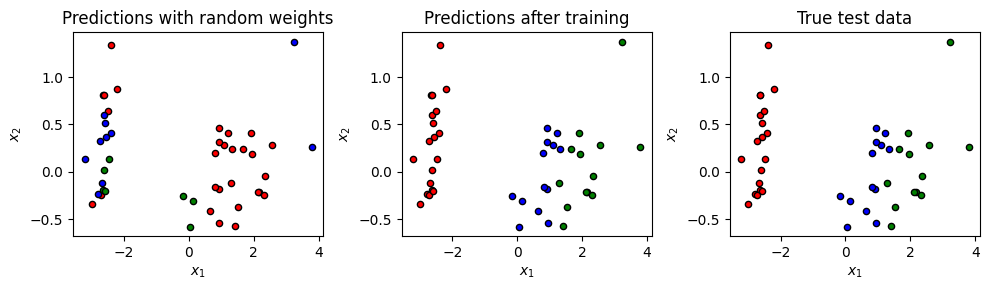

In [ ]:
# En esta sección se no se hace stack con 0 porque es un problema
# con datos en R^3.
_# En esta sección se no se hace stack con 0 porque es un problema
# con datos en R^3.
X, y =  make_IRIS_v2(3,3)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
# ===============================================================
# Train using Adam optimizer and evaluate the classifier
np.random.seed(42)
num_layers = 10
learning_rate = 0.1
epochs = 12
batch_size = 32
# clases
n_clases = 3
state_labels = representatives(n_clases, 2)
# optimaz
opt = qml.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
# initialize random weights
params = np.random.uniform(size=(2*num_layers, 3), requires_grad=True)
bias = np.random.uniform(size=(2*num_layers, 3), requires_grad=True)

# ==============================================================
states_2_q_wo_enten_1_after = test_intra_states(qcircuit_2_qubit_entanglement, params, X_train, y_train, state_labels, bias, True)
w_r_json('w', "/content/drive/MyDrive/Tesis/2_qubits_con_entrelazamiento_3_3_iris_before.json", file = states_2_q_wo_enten_1_after)
# ===============================================================

predicted_train, fidel_train = test(qcircuit_2_qubit_entanglement, params, X_train, y_train, state_labels,bias, True)
accuracy_train = accuracy_score(y_train, predicted_train)
predicted_test, fidel_test = test(qcircuit_2_qubit_entanglement, params, X_test, y_test, state_labels, bias, True)
accuracy_test = accuracy_score(y_test, predicted_test)
# save predictions with random weights for comparison
initial_predictions = predicted_test
loss = fidelity_cost(qcircuit_2_qubit_entanglement,params, X_train, y_train, state_labels, bias, True)
print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

# ===============================================================
for it in range(epochs):
  for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
    params, bias = opt.step(lambda p,b: fidelity_cost(qcircuit_2_qubit_entanglement, p, Xbatch, ybatch, state_labels,b, True), params, bias)
  # Results by Epochs:
  predicted_train, fidel_train = test(qcircuit_2_qubit_entanglement, params, X_train, y_train, state_labels, bias, True)
  # test(model, params, x, y, state_labels=None)
  accuracy_train = accuracy_score(y_train, predicted_train)
  loss = fidelity_cost(qcircuit_2_qubit_entanglement,params, X_train, y_train, state_labels, bias, True)
  predicted_test, fidel_test = test(qcircuit_2_qubit_entanglement, params, X_test, y_test, state_labels, bias, True)
  accuracy_test = accuracy_score(y_test, predicted_test)
  res = [it + 1, loss, accuracy_train, accuracy_test]
  print(
      "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
          *res
      )
  )
# ==============================================================
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)
# ===============================================================
states_2_q_wo_enten_1_after = test_intra_states(qcircuit_2_qubit_entanglement, params, X_train, y_train, state_labels, bias, True)
w_r_json('w', "/content/drive/MyDrive/Tesis/2_qubits_con_entrelazamiento_3_3_iris_after.json", file = states_2_q_wo_enten_1_after)
# ===============================================================
print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data_v2(X_test, initial_predictions, fig, axes[0])
plot_data_v2(X_test, predicted_test, fig, axes[1])
plot_data_v2(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()


## Train con 4 qubits

Se han truncado las últimas 5000 líneas del flujo de salida.
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N

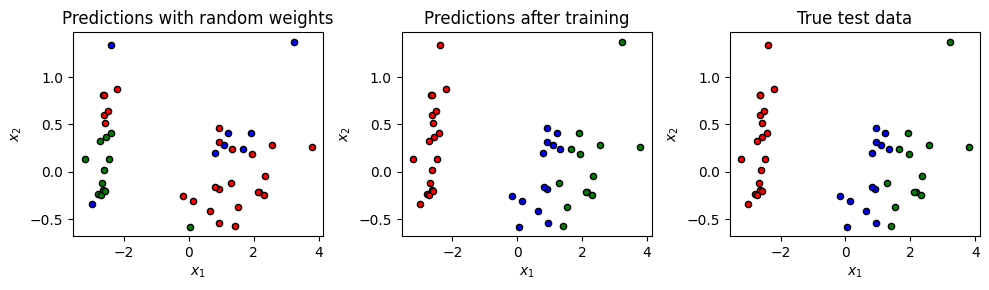

In [ ]:
X, y =  make_IRIS_v2(3,3)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# ===============================================================
# Train using Adam optimizer and evaluate the classifier
np.random.seed(42)
num_layers = 10
learning_rate = 0.1
epochs = 12
batch_size = 32
# clases
n_clases = 3
state_labels = representatives(n_clases, 4)
# optimaz
opt = qml.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.95)
# initialize random weights
params = np.random.uniform(size=(4*num_layers, 3), requires_grad=True)
bias = np.random.uniform(size=(4*num_layers, 3), requires_grad=True)




# ==============================================================
states_4_q_enten_1 = test_intra_states(qcircuit_4_qubit_entanglement, params, X_train, y_train, state_labels, bias, False)
w_r_json('w', "/content/drive/MyDrive/Tesis/4_qubits_sin_entrelazamiento_3_3_iris_before.json", file = states_4_q_enten_1)
# ===============================================================


# ===============================================================

predicted_train, fidel_train = test(qcircuit_4_qubit_entanglement, params, X_train, y_train, state_labels,bias, False)
accuracy_train = accuracy_score(y_train, predicted_train)
predicted_test, fidel_test = test(qcircuit_4_qubit_entanglement, params, X_test, y_test, state_labels, bias, False)
accuracy_test = accuracy_score(y_test, predicted_test)
# save predictions with random weights for comparison
initial_predictions = predicted_test
loss = fidelity_cost(qcircuit_4_qubit_entanglement,params, X_train, y_train, state_labels, bias, False)
print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

# ===============================================================
for it in range(epochs):
  for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
    params, bias = opt.step(lambda p,b: fidelity_cost(qcircuit_4_qubit_entanglement, p, Xbatch, ybatch, state_labels,b, False), params, bias)
  # Results by Epochs:
  predicted_train, fidel_train = test(qcircuit_4_qubit_entanglement, params, X_train, y_train, state_labels, bias, False)
  # test(model, params, x, y, state_labels=None)
  accuracy_train = accuracy_score(y_train, predicted_train)
  loss = fidelity_cost(qcircuit_4_qubit_entanglement,params, X_train, y_train, state_labels, bias, False)
  predicted_test, fidel_test = test(qcircuit_4_qubit_entanglement, params, X_test, y_test, state_labels, bias, False)
  accuracy_test = accuracy_score(y_test, predicted_test)
  res = [it + 1, loss, accuracy_train, accuracy_test]
  print(
      "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
          *res
      )
  )

# ==============================================================
states_4_q_enten_1 = test_intra_states(qcircuit_4_qubit_entanglement, params, X_train, y_train, state_labels, bias, False)
w_r_json('w', "/content/drive/MyDrive/Tesis/4_qubits_sin_entrelazamiento_3_3_iris_after.json", file = states_4_q_enten_1)
# ===============================================================

# ==============================================================
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)
print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data_v2(X_test, initial_predictions, fig, axes[0])
plot_data_v2(X_test, predicted_test, fig, axes[1])
plot_data_v2(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

Epoch:  0 | Cost: 0.843297 | Train accuracy: 0.465714 | Test Accuracy: 0.413333
Epoch:  1 | Loss: 0.443648 | Train accuracy: 0.694286 | Test accuracy: 0.733333
Epoch:  2 | Loss: 0.457898 | Train accuracy: 0.674286 | Test accuracy: 0.666667
Epoch:  3 | Loss: 0.416089 | Train accuracy: 0.757143 | Test accuracy: 0.773333
Epoch:  4 | Loss: 0.409619 | Train accuracy: 0.642857 | Test accuracy: 0.740000
Epoch:  5 | Loss: 0.391490 | Train accuracy: 0.720000 | Test accuracy: 0.753333
Epoch:  6 | Loss: 0.379647 | Train accuracy: 0.717143 | Test accuracy: 0.746667
Epoch:  7 | Loss: 0.371801 | Train accuracy: 0.708571 | Test accuracy: 0.780000
Epoch:  8 | Loss: 0.361781 | Train accuracy: 0.717143 | Test accuracy: 0.773333
Epoch:  9 | Loss: 0.345048 | Train accuracy: 0.748571 | Test accuracy: 0.780000
Epoch: 10 | Loss: 0.333432 | Train accuracy: 0.808571 | Test accuracy: 0.853333
Epoch: 11 | Loss: 0.327480 | Train accuracy: 0.805714 | Test accuracy: 0.853333
Epoch: 12 | Loss: 0.324899 | Train accur

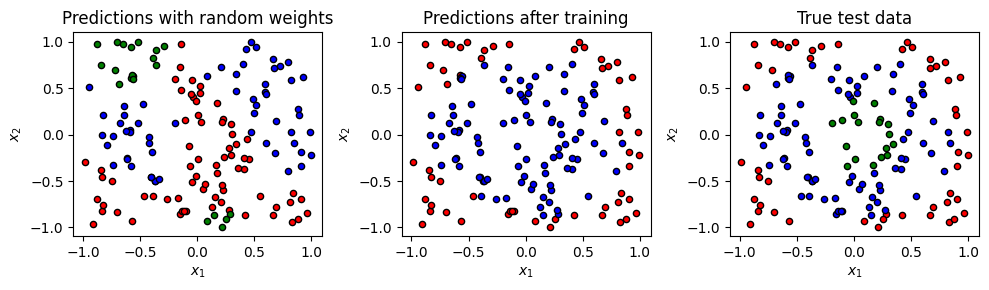

In [ ]:
# con datos en R^3.
X, y =  circle_v2(500)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_train = np.hstack((X_train, np.zeros((X_train.shape[0], 1), requires_grad=False)))
X_test = np.hstack((X_test, np.zeros((X_test.shape[0], 1), requires_grad=False)))

# ===============================================================
# Train using Adam optimizer and evaluate the classifier
num_layers = 10
learning_rate = 0.1
epochs = 12
batch_size = 32
# clases
n_clases = 3
state_labels = representatives(n_clases, 4)
# optimaz
opt = qml.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.95)
# initialize random weights
params = np.random.uniform(size=(4*num_layers, 3), requires_grad=True)
bias = np.random.uniform(size=(4*num_layers, 3), requires_grad=True)

entanglement = False
# ===============================================================

predicted_train, fidel_train = test(qcircuit_4_qubit_entanglement, params, X_train, y_train, state_labels,bias, entanglement)
accuracy_train = accuracy_score(y_train, predicted_train)
predicted_test, fidel_test = test(qcircuit_4_qubit_entanglement, params, X_test, y_test, state_labels, bias, entanglement)
accuracy_test = accuracy_score(y_test, predicted_test)
# save predictions with random weights for comparison
initial_predictions = predicted_test
loss = fidelity_cost(qcircuit_4_qubit_entanglement,params, X_train, y_train, state_labels, bias, entanglement)
print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

# ===============================================================
for it in range(epochs):
  for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
    params, bias = opt.step(lambda p,b: fidelity_cost(qcircuit_4_qubit_entanglement, p, Xbatch, ybatch, state_labels,b, entanglement), params, bias)
  # Results by Epochs:
  predicted_train, fidel_train = test(qcircuit_4_qubit_entanglement, params, X_train, y_train, state_labels, bias, entanglement)
  # test(model, params, x, y, state_labels=None)
  accuracy_train = accuracy_score(y_train, predicted_train)
  loss = fidelity_cost(qcircuit_4_qubit_entanglement,params, X_train, y_train, state_labels, bias, entanglement)
  predicted_test, fidel_test = test(qcircuit_4_qubit_entanglement, params, X_test, y_test, state_labels, bias, entanglement)
  accuracy_test = accuracy_score(y_test, predicted_test)
  res = [it + 1, loss, accuracy_train, accuracy_test]
  print(
      "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
          *res
      )
  )
# ==============================================================
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)
print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data_v2(X_test, initial_predictions, fig, axes[0])
plot_data_v2(X_test, predicted_test, fig, axes[1])
plot_data_v2(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

Se han truncado las últimas 5000 líneas del flujo de salida.
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N_layers = 10
N

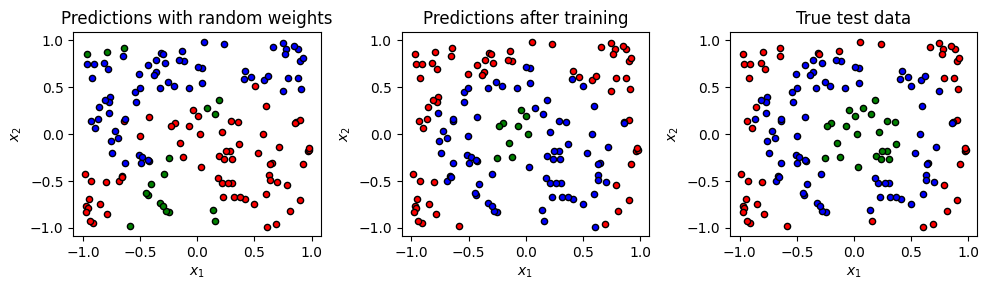

In [ ]:
# con datos en R^3.
X, y =  circle_v2(500)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_train = np.hstack((X_train, np.zeros((X_train.shape[0], 1), requires_grad=False)))
X_test = np.hstack((X_test, np.zeros((X_test.shape[0], 1), requires_grad=False)))

# ===============================================================
# Train using Adam optimizer and evaluate the classifier
np.random.seed(42)
num_layers = 10
learning_rate = 0.1
epochs = 12
batch_size = 32
# clases
n_clases = 3
state_labels = representatives(n_clases, 4)
# optimaz
opt = qml.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.95)
# initialize random weights
params = np.random.uniform(size=(4*num_layers, 3), requires_grad=True)
bias = np.random.uniform(size=(4*num_layers, 3), requires_grad=True)

entanglement = True
# ===============================================================


# ==============================================================
states_4_q_enten_1 = test_intra_states(qcircuit_4_qubit_entanglement, params, X_train, y_train, state_labels, bias, entanglement)
w_r_json('w', "/content/drive/MyDrive/Tesis/4_qubits_con_entrelazamiento_3_circulos_before.json", file = states_4_q_enten_1)
# ===============================================================


predicted_train, fidel_train = test(qcircuit_4_qubit_entanglement, params, X_train, y_train, state_labels,bias, entanglement)
accuracy_train = accuracy_score(y_train, predicted_train)
predicted_test, fidel_test = test(qcircuit_4_qubit_entanglement, params, X_test, y_test, state_labels, bias, entanglement)
accuracy_test = accuracy_score(y_test, predicted_test)
# save predictions with random weights for comparison
initial_predictions = predicted_test
loss = fidelity_cost(qcircuit_4_qubit_entanglement,params, X_train, y_train, state_labels, bias, entanglement)
print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

# ===============================================================
for it in range(epochs):
  for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
    params, bias = opt.step(lambda p,b: fidelity_cost(qcircuit_4_qubit_entanglement, p, Xbatch, ybatch, state_labels,b, entanglement), params, bias)
  # Results by Epochs:
  predicted_train, fidel_train = test(qcircuit_4_qubit_entanglement, params, X_train, y_train, state_labels, bias, entanglement)
  # test(model, params, x, y, state_labels=None)
  accuracy_train = accuracy_score(y_train, predicted_train)
  loss = fidelity_cost(qcircuit_4_qubit_entanglement,params, X_train, y_train, state_labels, bias, entanglement)
  predicted_test, fidel_test = test(qcircuit_4_qubit_entanglement, params, X_test, y_test, state_labels, bias, entanglement)
  accuracy_test = accuracy_score(y_test, predicted_test)
  res = [it + 1, loss, accuracy_train, accuracy_test]
  print(
      "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
          *res
      )
  )

# ==============================================================
states_4_q_enten_1 = test_intra_states(qcircuit_4_qubit_entanglement, params, X_train, y_train, state_labels, bias, entanglement)
w_r_json('w', "/content/drive/MyDrive/Tesis/4_qubits_con_entrelazamiento_3_circulos_after.json", file = states_4_q_enten_1)
# ===============================================================

# ==============================================================
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)
print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data_v2(X_test, initial_predictions, fig, axes[0])
plot_data_v2(X_test, predicted_test, fig, axes[1])
plot_data_v2(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

Epoch:  0 | Cost: 0.867375 | Train accuracy: 0.365714 | Test Accuracy: 0.433333
Epoch:  1 | Loss: 0.541274 | Train accuracy: 0.642857 | Test accuracy: 0.573333
Epoch:  2 | Loss: 0.466044 | Train accuracy: 0.637143 | Test accuracy: 0.620000
Epoch:  3 | Loss: 0.398477 | Train accuracy: 0.685714 | Test accuracy: 0.673333
Epoch:  4 | Loss: 0.364042 | Train accuracy: 0.702857 | Test accuracy: 0.673333
Epoch:  5 | Loss: 0.349945 | Train accuracy: 0.725714 | Test accuracy: 0.700000
Epoch:  6 | Loss: 0.353266 | Train accuracy: 0.717143 | Test accuracy: 0.700000
Epoch:  7 | Loss: 0.361062 | Train accuracy: 0.694286 | Test accuracy: 0.673333
Epoch:  8 | Loss: 0.341535 | Train accuracy: 0.728571 | Test accuracy: 0.720000
Epoch:  9 | Loss: 0.337934 | Train accuracy: 0.734286 | Test accuracy: 0.706667
Epoch: 10 | Loss: 0.342132 | Train accuracy: 0.714286 | Test accuracy: 0.693333
Epoch: 11 | Loss: 0.347308 | Train accuracy: 0.697143 | Test accuracy: 0.686667
Epoch: 12 | Loss: 0.325985 | Train accur

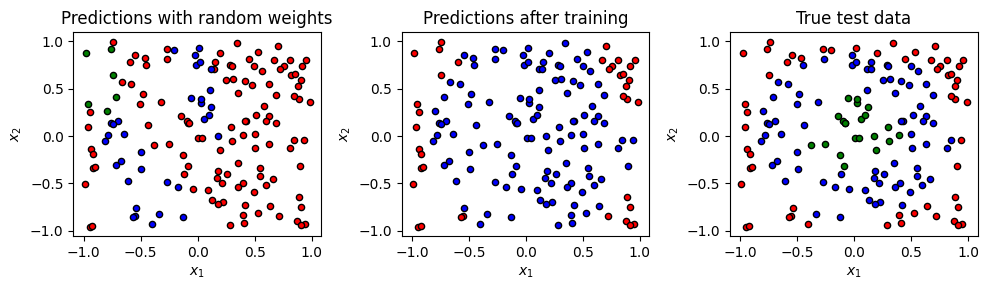

In [ ]:
# con datos en R^3.
X, y =  circle_v2(500)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_train = np.hstack((X_train, np.zeros((X_train.shape[0], 1), requires_grad=False)))
X_test = np.hstack((X_test, np.zeros((X_test.shape[0], 1), requires_grad=False)))

# ===============================================================
# Train using Adam optimizer and evaluate the classifier
num_layers = 10
learning_rate = 0.1
epochs = 12
batch_size = 32
# clases
n_clases = 3
state_labels = representatives_v2(n_clases, 4)
# optimaz
opt = qml.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.95)
# initialize random weights
params = np.random.uniform(size=(4*num_layers, 3), requires_grad=True)
bias = np.random.uniform(size=(4*num_layers, 3), requires_grad=True)

entanglement = True
# ===============================================================

predicted_train, fidel_train = test(qcircuit_4_qubit_entanglement, params, X_train, y_train, state_labels,bias, entanglement)
accuracy_train = accuracy_score(y_train, predicted_train)
predicted_test, fidel_test = test(qcircuit_4_qubit_entanglement, params, X_test, y_test, state_labels, bias, entanglement)
accuracy_test = accuracy_score(y_test, predicted_test)
# save predictions with random weights for comparison
initial_predictions = predicted_test
loss = fidelity_cost(qcircuit_4_qubit_entanglement,params, X_train, y_train, state_labels, bias, entanglement)
print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

# ===============================================================
for it in range(epochs):
  for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
    params, bias = opt.step(lambda p,b: fidelity_cost(qcircuit_4_qubit_entanglement, p, Xbatch, ybatch, state_labels,b, entanglement), params, bias)
  # Results by Epochs:
  predicted_train, fidel_train = test(qcircuit_4_qubit_entanglement, params, X_train, y_train, state_labels, bias, entanglement)
  # test(model, params, x, y, state_labels=None)
  accuracy_train = accuracy_score(y_train, predicted_train)
  loss = fidelity_cost(qcircuit_4_qubit_entanglement,params, X_train, y_train, state_labels, bias, entanglement)
  predicted_test, fidel_test = test(qcircuit_4_qubit_entanglement, params, X_test, y_test, state_labels, bias, entanglement)
  accuracy_test = accuracy_score(y_test, predicted_test)
  res = [it + 1, loss, accuracy_train, accuracy_test]
  print(
      "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
          *res
      )
  )
# ==============================================================
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)
print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data_v2(X_test, initial_predictions, fig, axes[0])
plot_data_v2(X_test, predicted_test, fig, axes[1])
plot_data_v2(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

# 11. Training with another loss function




*   Definir con clasidad supp p y ver las condiciones.
*   Pensar la forma de testear de tal manera que se pueda comparar una fidelidad normal entre un ket con ruido y otro sin ruido.
* Pensar en que pasa cuando el espacio C no esta sujeto a los labels iniciales sino que tambien mute como lo hacer el SVM.



## Funciones auxiliares

### Funcion para calcular matriz de densidad

In [ ]:
"""
# Define output labels as quantum state vectors
def density_matrix(state):
    '''Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    '''
    state = np.reshape(state, (2, 1))
    #print(f"State = {state}")
    #print(f"conj state = {np.conj(state).T}")
    return state @ (np.conj(state).T) # Outer product
"""

In [ ]:
# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    nf, = state.shape
    state = np.reshape(state, (nf, 1))
    #print(f"State = {state}")
    #print(f"conj state = {np.conj(state).T}")
    return state @ (np.conj(state).T) # Outer product

### Modelos con ruido

In [ ]:
# alpha : parametros gobal que controla el ruido de amplitude damping
dev = qml.device("default.mixed", wires=1)
@qml.qnode(dev, interface=None)
def qcircuit_1_qubit_mixed(params, x, bias=None, entanglement=False, alpha_noise = 0.0):
  #global alpha_noise
  '''A variational quantum circuit representing the Universal classifier.
  Args:
      params (array[float]): array of parameters
      x (array[float]): single input vector
  Returns:
      float: qml state
  '''
  for i,p in enumerate(params):
    arg = np.multiply(p,x) + bias[i]
    arg1, arg2, arg3 = arg
    qml.Rot(arg3,arg1,arg2 , wires=0) # RZ * RY * RZ -> data
    qml.AmplitudeDamping(alpha_noise, wires=0)
    qml.Snapshot(f"ket_1_qubit_{i}")
  return qml.state()
# ====================================================================
dev = qml.device("default.mixed", wires=2)
@qml.qnode(dev, interface=None)
def qcircuit_2_qubit_mixed(params, x, bias = None, entanglement = False, alpha_noise = 0.0):
  #global alpha_noise
  """A variational quantum circuit representing the Universal classifier.
  Args:
      params (array[float]): array of parameters
      x (array[float]): single input vector
  Returns:
      float: qml state
  """
  n_layer = len(params) // 2
  #print(f"N_layers = {n_layer}")
  for i in range(n_layer):
    arg_1 = np.multiply(params[i],x) + bias[i]
    arg_2 = np.multiply(params[i + n_layer],x) + bias[i + n_layer]
    qml.Rot(*arg_1 , wires=0) # RZ * RY * RZ -> data
    qml.AmplitudeDamping(alpha_noise, wires=0)
    qml.Rot(*arg_2 , wires=1) # RZ * RY * RZ -> data
    qml.AmplitudeDamping(alpha_noise, wires=1)
    qml.Snapshot(f"ket_2_qubits_{i}")
    if entanglement == True:
      qml.CZ(wires=[0,1])
      qml.Snapshot(f"ket_2_qubits_entanglement_{i}")
  return qml.state()
# =============================================================================
dev = qml.device("default.mixed", wires=4)
@qml.qnode(dev, interface=None)
def qcircuit_4_qubit_mixed(params, x, bias = None, entanglement = False, alpha_noise = 0.0):
  #global alpha_noise
  """A variational quantum circuit representing the Universal classifier.
  Args:
      params (array[float]): array of parameters
      x (array[float]): single input vector
  Returns:
      float: qml state
  """
  n_layer = len(params) // 4
  #print(f"N_layers = {n_layer}")
  #n_entenglaments = 0
  for i in range(n_layer):
    arg_1 = np.multiply(params[i],x) + bias[i]
    arg_2 = np.multiply(params[i + n_layer],x) + bias[i + n_layer]
    arg_3 = np.multiply(params[i + 2*n_layer],x) + bias[i + 2*n_layer]
    arg_4 = np.multiply(params[i + 3*n_layer],x) + bias[i + 3*n_layer]
    qml.Rot(*arg_1 , wires=0) # RZ * RY * RZ -> data
    qml.AmplitudeDamping(alpha_noise, wires=0)
    qml.Rot(*arg_2 , wires=1) # RZ * RY * RZ -> data
    qml.AmplitudeDamping(alpha_noise, wires=1)
    qml.Rot(*arg_3 , wires=2) # RZ * RY * RZ -> data
    qml.AmplitudeDamping(alpha_noise, wires=2)
    qml.Rot(*arg_4 , wires=3) # RZ * RY * RZ -> data
    qml.AmplitudeDamping(alpha_noise, wires=3)
    qml.Snapshot(f"ket_4_qubits_{i}")
    if entanglement == True:
      if i % 2 == 0 and i < n_layer-1:
        # par:
        qml.CZ(wires=[0,1])
        qml.CZ(wires=[2,3])
        qml.Snapshot(f"ket_4_qubits_entanglement_par{i}")
        #n_entenglaments += 1
      elif i < n_layer-1:
        # impar:
        qml.CZ(wires=[1,2])
        qml.CZ(wires=[0,3])
        qml.Snapshot(f"ket_4_qubits_entanglement_impar{i}")
        #n_entenglaments += 1
  #verb = 1
  #if verb == 1:
  #  print(f"n_entenglaments = {n_entenglaments}")
  #  verb = 0
  return qml.state()

### Fidelidad cost

In [ ]:
def fidelity_cost(state0, state1):
  F  = 1 - qml.math.fidelity(state0, state1)
  return F

### Distancia de traza

4aa39bcb8dbccea3f421aec0ee576cfef518c8b2.svg

In [ ]:
# Distancia de traza:
verbose_trace_dist = 0

Proceso = '''
Entrada prediccion:
=======================
{}
Entrada true:
=======================
{}
=======================
=======================
Resta:
=======================
{}
Resta trasnpuesta conjugada:
=======================
{}
Producto:
=======================
{}
SQRT:
=======================
{}
Traza:
========================
{}
'''

def Trace_Distance(dm_pred, dm_true):
  global verbose_trace_dist
  diff = dm_pred - dm_true
  diff_t = np.transpose(diff)
  diff_t = np.conjugate(diff_t)
  diff_m = np.dot(diff_t, diff)
  #sqrt_diff = fractional_matrix_power(diff_t @ diff,0.5)
  eigenvalues, eigenvectors = np.linalg.eig(diff_m)
  inverted_sqrt_eigenvalues = np.sqrt(eigenvalues)
  sqrt_diff = np.dot(np.dot(eigenvectors, np.diag(inverted_sqrt_eigenvalues)), np.linalg.inv(eigenvectors))
  trac_sqrt = 0.5*np.real(np.trace(sqrt_diff))
  my_salida = trac_sqrt
  if verbose_trace_dist == 1:
    print(Proceso.format(dm_pred,
                         dm_true,
                         diff,
                         diff_t,
                         diff_m,
                         sqrt_diff,
                         np.trace(sqrt_diff)))
    verbose_trace_dist = 0
  return trac_sqrt

In [ ]:
# Distancia de traza:
verbose_trace_dist = 0

Proceso = '''
Entrada prediccion:
=======================
{}
Entrada true:
=======================
{}
=======================
=======================
Resta:
=======================
{}
Resta trasnpuesta conjugada:
=======================
{}
Producto:
=======================
{}
SQRT:
=======================
{}
Traza:
========================
{}
'''

def Trace_Distance_v2(dm_pred, dm_true):
  print(f"Pred=========")
  print(dm_pred)
  print(f"True=========")
  print(dm_true)
  global verbose_trace_dist
  diff = dm_pred - dm_true
  diff_t = np.transpose(diff)
  diff_t = np.conjugate(diff_t)
  diff_m = np.dot(diff_t, diff)

  # corregir:
  indice = np.where(np.diag(diff_m) == 0)[0]
  if len(indice) > 0:
    nf,nc = diff_m.shape
    diff_m = diff_m + 1e-6*np.eye(nf)

  #sqrt_diff = fractional_matrix_power(diff_t @ diff,0.5)
  #print("==========================")
  #print(diff_m)

  eigenvalues, eigenvectors = np.linalg.eig(diff_m)
  inverted_sqrt_eigenvalues = np.sqrt(eigenvalues)
  sqrt_diff = np.dot(np.dot(eigenvectors, np.diag(inverted_sqrt_eigenvalues)), np.linalg.inv(eigenvectors))
  trac_sqrt = 0.5*np.real(np.trace(sqrt_diff))
  my_salida = trac_sqrt
  if verbose_trace_dist == 1:
    print(Proceso.format(dm_pred,
                         dm_true,
                         diff,
                         diff_t,
                         diff_m,
                         sqrt_diff,
                         np.trace(sqrt_diff)))
    verbose_trace_dist = 0
  return trac_sqrt

In [ ]:
# Distancia de traza:
verbose_trace_dist = 0

Proceso = '''
Entrada prediccion:
=======================
{}
Entrada true:
=======================
{}
=======================
=======================
Resta:
=======================
{}
Resta trasnpuesta conjugada:
=======================
{}
Producto:
=======================
{}
SQRT:
=======================
{}
Traza:
========================
{}
'''

def Trace_Distance_v3(dm_pred, dm_true):
  global verbose_trace_dist

  condicion_1 = np.count_nonzero(dm_true) == 1
  condicion_2 = np.array_equal(np.diag(np.diag(dm_true)), dm_true)
  if condicion_1 and condicion_2:
    #dm_true = dm_true.astype(np.float64)
    indice = np.where(np.diag(dm_true) == 1)[0][0]
    const = 0.999
    e = dm_true[indice,indice] - const
    nf,nc = dm_true.shape
    res = e/nf
    dm_true[np.diag_indices_from(dm_true)] = res
    dm_true[indice,indice] = const



  diff = dm_pred - dm_true
  diff_t = np.transpose(diff)
  diff_t = np.conjugate(diff_t)
  diff_m = np.dot(diff_t, diff)

  #sqrt_diff = fractional_matrix_power(diff_t @ diff,0.5)
  #print("==========================")
  #print(diff_m)

  eigenvalues, eigenvectors = np.linalg.eig(diff_m)
  inverted_sqrt_eigenvalues = np.sqrt(eigenvalues)
  sqrt_diff = np.dot(np.dot(eigenvectors, np.diag(inverted_sqrt_eigenvalues)), np.linalg.inv(eigenvectors))
  trac_sqrt = 0.5*np.real(np.trace(sqrt_diff))
  my_salida = trac_sqrt
  if verbose_trace_dist == 1:
    print(Proceso.format(dm_pred,
                         dm_true,
                         diff,
                         diff_t,
                         diff_m,
                         sqrt_diff,
                         np.trace(sqrt_diff)))
    verbose_trace_dist = 0
  return trac_sqrt

### Divergencia cuantica

609076da6a64c7580b80e0ef494273f32f9c1c1f.svg

In [ ]:
# Entropia de von newman
verbose_trace_dist = 0
Proceso_2 = '''
Entrada prediccion:
=======================
{}
Entrada true:
=======================
{}
=======================
=======================
Log prediccion:
=======================
{}
Log True:
=======================
{}
Producto:
=======================
{}
Divergencia:
=======================
{}
'''

def Von_Neumman_Divergence(dm_pred, dm_true):
  # Imprimir un paso:
  global verbose_trace_dist
  # Condiciones para operar matrices:
  condicion_1 = np.count_nonzero(dm_true) == 1
  condicion_2 = np.array_equal(np.diag(np.diag(dm_true)), dm_true)
  if condicion_1 and condicion_2:
    p = 0.001
    nf,nc = dm_true.shape
    if nf == 2:
      X = np.array([[0,1],[1,0]])
    elif nf == 4:
      X = np.array([
          [0, 0, 0, 1],
          [0, 0, 1, 0],
          [0, 1, 0, 0],
          [1, 0, 0, 0]
      ])
    elif nf == 8:
      # Definir la matriz X de 2x2
      X_1q = np.array([[0, 1], [1, 0]])
      # Calcular el producto tensorial de dos compuertas X
      X_4qubits = np.kron(X_1q, X_1q)
      X_4qubits = np.kron(X_4qubits, X_1q)
      X = np.kron(X_4qubits, X_1q)
    dm_true = (1 - p)*dm_true + p*np.dot(np.dot(X,dm_true),X)
  # continuar:
  eigenvalues, eigenvectors = np.linalg.eig(dm_pred)
  inverted_sqrt_eigenvalues = np.log(eigenvalues)
  log_p = np.dot(np.dot(eigenvectors, np.diag(inverted_sqrt_eigenvalues)), np.linalg.inv(eigenvectors))
  #log_rho = logm(dm_true)
  eigenvalues, eigenvectors = np.linalg.eig(dm_true)
  inverted_sqrt_eigenvalues = np.log(eigenvalues)
  log_rho = np.dot(np.dot(eigenvectors, np.diag(inverted_sqrt_eigenvalues)), np.linalg.inv(eigenvectors))
  diff = log_p - log_rho
  prod = np.dot(dm_pred, diff)
  vkld = np.real(np.trace(prod))

  if verbose_trace_dist == 1:
    print(Proceso_2.format(dm_pred,
                         dm_true,
                         log_p,
                         log_rho,
                         prod,
                         vkld))
    print("=========================")
    print(f"nf = {nf}")
  return vkld

In [ ]:
# Entropia de von newman
verbose_trace_dist = 1
Proceso_2 = '''
Entrada prediccion:
=======================
{}
Entrada true:
=======================
{}
=======================
=======================
Log prediccion:
=======================
{}
Log True:
=======================
{}
Producto:
=======================
{}
Divergencia:
=======================
{}
'''

def Von_Neumman_Divergence_v2(dm_pred, dm_true):
  # Imprimir un paso:
  global verbose_trace_dist
  # Condiciones para operar matrices:
  condicion_1 = np.count_nonzero(dm_true) == 1
  condicion_2 = np.array_equal(np.diag(np.diag(dm_true)), dm_true)
  if condicion_1 and condicion_2:
    #dm_true = dm_true.astype(np.float64)
    indice = np.where(np.diag(dm_true) == 1)[0][0]
    const = 0.999
    e = dm_true[indice,indice] - const
    nf,nc = dm_true.shape
    res = e/nf
    dm_true[np.diag_indices_from(dm_true)] = res
    dm_true[indice,indice] = const
  # continuar:
  eigenvalues, eigenvectors = np.linalg.eig(dm_pred)
  inverted_sqrt_eigenvalues = np.log(eigenvalues)
  log_p = np.dot(np.dot(eigenvectors, np.diag(inverted_sqrt_eigenvalues)), np.linalg.inv(eigenvectors))
  #log_rho = logm(dm_true)
  eigenvalues, eigenvectors = np.linalg.eig(dm_true)
  inverted_sqrt_eigenvalues = np.log(eigenvalues)
  log_rho = np.dot(np.dot(eigenvectors, np.diag(inverted_sqrt_eigenvalues)), np.linalg.inv(eigenvectors))
  diff = log_p - log_rho
  prod = np.dot(dm_pred, diff)
  vkld = np.real(np.trace(prod))

  if verbose_trace_dist == 1:
    print(Proceso_2.format(dm_pred,
                         dm_true,
                         log_p,
                         log_rho,
                         prod,
                         vkld))
    print("=========================")
    print(f"nf = {nf}")
  return vkld

### Divergencia de Renyi

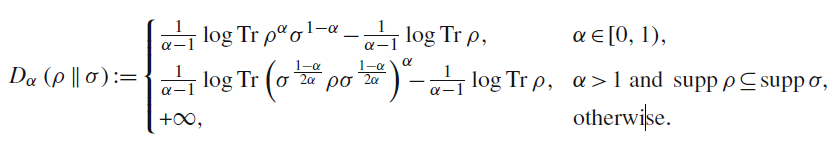

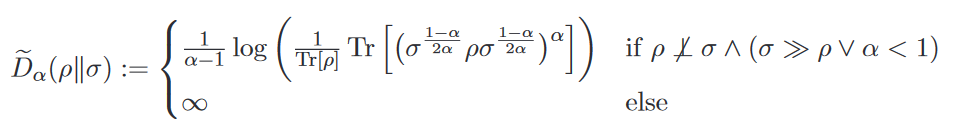

In [ ]:
"""
import numpy as np
mi_arreglo = np.array([-0.3, 5.37228132])
c = np.sign(mi_arreglo) * (np.abs(mi_arreglo)) ** (-0.5)
c
"""

'\nimport numpy as np\nmi_arreglo = np.array([-0.3, 5.37228132])\nc = np.sign(mi_arreglo) * (np.abs(mi_arreglo)) ** (-0.5)\nc\n'

In [ ]:
# Entropia de renyi

verbose_trace_dist = 0

Proceso_3 = '''
Entrada prediccion:
=======================
{}
Entrada true:
=======================
{}
=======================
=======================
Potencia:
=======================
{}
dm_true_elevada:
=======================
{}
Arg 1 (RHO * P * RHO):
=======================
{}
Traza 1:
=======================
{}
Arg 2 LOG(*):
=======================
{}
log:
=======================
{}
Divergencia:
=======================
{}
'''

def matrix_pow(p, power):
  eigenvalues, eigenvectors = np.linalg.eig(p)
  inverted_sqrt_eigenvalues = np.sign(eigenvalues) * (np.abs(eigenvalues)) ** (power)
  p_powered = np.dot(np.dot(eigenvectors, np.diag(inverted_sqrt_eigenvalues)), np.linalg.inv(eigenvectors))
  return p_powered

def Renyi_Divergence(dm_pred, dm_true):
  global verbose_trace_dist, alpha_R
  # check si la matriz tiene solo un 1 en su diagonal
  condicion_1 = np.count_nonzero(dm_true) == 1
  condicion_2 = np.array_equal(np.diag(np.diag(dm_true)), dm_true)
  if condicion_1 and condicion_2:
    #print("Hola entre")
    #print(dm_true)
    p = 0.001
    nf,nc = dm_true.shape
    if nf == 2:
      X = np.array([[0,1],[1,0]])
    elif nf == 4:
      X = np.array([
          [0, 0, 0, 1],
          [0, 0, 1, 0],
          [0, 1, 0, 0],
          [1, 0, 0, 0]
      ])
    elif nf == 8:
      # Definir la matriz X de 2x2
      X_1q = np.array([[0, 1], [1, 0]])
      # Calcular el producto tensorial de dos compuertas X
      X_4qubits = np.kron(X_1q, X_1q)
      X_4qubits = np.kron(X_4qubits, X_1q)
      X = np.kron(X_4qubits, X_1q)
    dm_true = (1 - p)*dm_true + p*np.dot(np.dot(X,dm_true),X)
  # sigma:
  power_a = (1-alpha_R)/(2*alpha_R)
  dm_true_powered = matrix_pow(dm_true, power_a)
  # product:
  arg_1 = np.dot(np.dot(dm_true_powered, dm_pred), dm_true_powered)
  # trace:
  tra = np.real(np.trace( matrix_pow(arg_1, alpha_R) ))
  # arg of log:
  arg_2 = (1/(np.real(np.trace(dm_pred)))) * tra
  # log:
  arg_3 = np.log(arg_2)
  # Divergece:
  D = (1/(alpha_R - 1)) * arg_3

  if verbose_trace_dist == 1:
    print(Proceso_3.format(dm_pred,
                         dm_true,
                         power_a,
                         dm_true_powered,
                         arg_1,
                         tra,
                         arg_2,
                         arg_3,
                        D))
    verbose_trace_dist = 0
  return D

In [ ]:
# Entropia de renyi

verbose_trace_dist = 0

Proceso_3 = '''
Entrada prediccion:
=======================
{}
Entrada true:
=======================
{}
=======================
=======================
Potencia:
=======================
{}
dm_true_elevada:
=======================
{}
Arg 1 (RHO * P * RHO):
=======================
{}
Traza 1:
=======================
{}
Arg 2 LOG(*):
=======================
{}
log:
=======================
{}
Divergencia:
=======================
{}
'''

def matrix_pow(p, power):
  eigenvalues, eigenvectors = np.linalg.eig(p)
  inverted_sqrt_eigenvalues = np.sign(eigenvalues) * (np.abs(eigenvalues)) ** (power)
  p_powered = np.dot(np.dot(eigenvectors, np.diag(inverted_sqrt_eigenvalues)), np.linalg.inv(eigenvectors))
  return p_powered

def Renyi_Divergence_v2(dm_pred, dm_true):
  global verbose_trace_dist, alpha_R
  # check si la matriz tiene solo un 1 en su diagonal
  condicion_1 = np.count_nonzero(dm_true) == 1
  condicion_2 = np.array_equal(np.diag(np.diag(dm_true)), dm_true)
  if condicion_1 and condicion_2:
    #dm_true = dm_true.astype(np.float64)
    indice = np.where(np.diag(dm_true) == 1)[0][0]
    const = 0.999
    e = dm_true[indice,indice] - const
    nf,nc = dm_true.shape
    res = e/nf
    dm_true[np.diag_indices_from(dm_true)] = res
    dm_true[indice,indice] = const
  # sigma:
  power_a = (1-alpha_R)/(2*alpha_R)
  dm_true_powered = matrix_pow(dm_true, power_a)
  # product:
  arg_1 = np.dot(np.dot(dm_true_powered, dm_pred), dm_true_powered)
  # trace:
  tra = np.real(np.trace( matrix_pow(arg_1, alpha_R) ))
  # arg of log:
  arg_2 = (1/(np.real(np.trace(dm_pred)))) * tra
  # log:
  arg_3 = np.log(arg_2)
  # Divergece:
  D = (1/(alpha_R - 1)) * arg_3

  if verbose_trace_dist == 1:
    print(Proceso_3.format(dm_pred,
                         dm_true,
                         power_a,
                         dm_true_powered,
                         arg_1,
                         tra,
                         arg_2,
                         arg_3,
                        D))
    verbose_trace_dist = 0
  return D

### Funciones de costo y test modificadas

In [ ]:
def _cost(model, params, x, y, state_labels=None, bias = None, f_cost = None, entanglement = False):
    """Cost function to be minimized.
    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels
    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    #dm_labels = [s for s in state_labels]
    for i in range(len(x)):
      state_output = model(params, x[i], bias = bias, entanglement = entanglement)
      f =  f_cost(state_output, dm_labels[y[i]])
      loss = loss + f
    return loss / len(x)

def _test(model, params, x, y, state_labels=None, bias=None, entanglement = False):
  """
  Tests on a given set of data.
  Args:
      params (array[float]): array of parameters
      x (array[float]): 2-d array of input vectors
      y (array[float]): 1-d array of targets
      state_labels (array[float]): 1-d array of state representations for labels
  Returns:
      predicted (array([int]): predicted labels for test data
      output_states (array[float]): output quantum states from the circuit
  """
  fidelity_values = []
  #dm_labels = [s for s in state_labels]
  dm_labels = [density_matrix(s) for s in state_labels]
  #print(f'len labels = {len(dm_labels)}')
  predicted = []
  for i in range(len(x)):
    #fidel_function = lambda y: qcircuit(params, x[i], y)
    fidelities = []
    for dm in dm_labels:
      state_output = model(params, x[i], bias=bias, entanglement = entanglement)
      # fidelity_cost(model, params, x, y, state_labels=None)
      f = fidelity(state_output, dm)
      fidelities.append(f)
    best_fidel = np.argmax(fidelities)
    #print(fidelities, best_fidel, y[i])
    predicted.append(best_fidel)
    fidelity_values.append(fidelities)
  return np.array(predicted), np.array(fidelity_values)

## Prueba con Diferencia de IRIS

## Prueba con 1 qubit

In [ ]:
def prueba_iris(f_loss, Epocas):
  X, y =  make_IRIS_v2(3,3)
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.3, random_state=42
  )

  # Train using Adam optimizer and evaluate the classifier
  num_layers = 10
  learning_rate = 0.1
  epochs = Epocas
  batch_size = 32
  # clases
  n_clases = 3
  state_labels = representatives(n_clases, 1)
  # optimaz
  opt = qml.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
  # initialize random weights
  params = np.random.uniform(size=(num_layers, 3), requires_grad=True)
  bias = np.random.uniform(size=(num_layers, 3), requires_grad=True)

  predicted_train, fidel_train = _test(qcircuit_1_qubit_mixed, params, X_train, y_train, state_labels, bias)
  accuracy_train = accuracy_score(y_train, predicted_train)
  predicted_test, fidel_test = _test(qcircuit_1_qubit_mixed, params, X_test, y_test, state_labels, bias)
  accuracy_test = accuracy_score(y_test, predicted_test)
  # save predictions with random weights for comparison
  initial_predictions = predicted_test
  loss = _cost(qcircuit_1_qubit_mixed,params, X_train, y_train, state_labels, bias, f_cost = f_loss)
  print(
      "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
          0, loss, accuracy_train, accuracy_test
      )
  )
  for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
      params, bias = opt.step(lambda p,b: _cost(qcircuit_1_qubit_mixed, p, Xbatch, ybatch, state_labels,b,f_cost = f_loss), params, bias)
      # _cost(qcircuit_2_qubit,params, X_train, y_train, state_labels, bias, f_cost = Trace_Distance)
    # Results by Epochs:
    predicted_train, fidel_train = _test(qcircuit_1_qubit_mixed, params, X_train, y_train, state_labels,bias)
    # test(model, params, x, y, state_labels=None)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss =  _cost(qcircuit_1_qubit_mixed,params, X_train, y_train, state_labels, bias, f_cost = f_loss)
    predicted_test, fidel_test = _test(qcircuit_1_qubit_mixed, params, X_test, y_test, state_labels,bias)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

In [ ]:
alpha = 0.0
prueba_iris(Trace_Distance, 10)

Epoch:  0 | Cost: 0.587974 | Train accuracy: 0.466667 | Test Accuracy: 0.533333
Epoch:  1 | Loss: 0.440427 | Train accuracy: 0.790476 | Test accuracy: 0.644444
Epoch:  2 | Loss: 0.424604 | Train accuracy: 0.685714 | Test accuracy: 0.666667
Epoch:  3 | Loss: 0.393045 | Train accuracy: 0.790476 | Test accuracy: 0.688889
Epoch:  4 | Loss: 0.340326 | Train accuracy: 0.819048 | Test accuracy: 0.777778
Epoch:  5 | Loss: 0.359646 | Train accuracy: 0.809524 | Test accuracy: 0.688889
Epoch:  6 | Loss: 0.336344 | Train accuracy: 0.828571 | Test accuracy: 0.666667
Epoch:  7 | Loss: 0.306696 | Train accuracy: 0.876190 | Test accuracy: 0.822222
Epoch:  8 | Loss: 0.286372 | Train accuracy: 0.866667 | Test accuracy: 0.777778
Epoch:  9 | Loss: 0.264318 | Train accuracy: 0.952381 | Test accuracy: 0.888889
Epoch: 10 | Loss: 0.242502 | Train accuracy: 0.952381 | Test accuracy: 0.955556


In [ ]:
alpha = 0.3
prueba_iris(Trace_Distance, 10)

Epoch:  0 | Cost: 0.609149 | Train accuracy: 0.295238 | Test Accuracy: 0.422222
Epoch:  1 | Loss: 0.537406 | Train accuracy: 0.295238 | Test accuracy: 0.422222
Epoch:  2 | Loss: 0.484771 | Train accuracy: 0.314286 | Test accuracy: 0.422222
Epoch:  3 | Loss: 0.426276 | Train accuracy: 0.400000 | Test accuracy: 0.488889
Epoch:  4 | Loss: 0.410121 | Train accuracy: 0.390476 | Test accuracy: 0.466667
Epoch:  5 | Loss: 0.374036 | Train accuracy: 0.476190 | Test accuracy: 0.533333
Epoch:  6 | Loss: 0.362147 | Train accuracy: 0.590476 | Test accuracy: 0.688889
Epoch:  7 | Loss: 0.339844 | Train accuracy: 0.800000 | Test accuracy: 0.777778
Epoch:  8 | Loss: 0.331205 | Train accuracy: 0.838095 | Test accuracy: 0.866667
Epoch:  9 | Loss: 0.323622 | Train accuracy: 0.866667 | Test accuracy: 0.955556
Epoch: 10 | Loss: 0.303520 | Train accuracy: 0.885714 | Test accuracy: 0.955556


In [ ]:
alpha = 0.0
prueba_iris(fidelity_cost, 10)

Epoch:  0 | Cost: 0.523230 | Train accuracy: 0.171429 | Test Accuracy: 0.288889
Epoch:  1 | Loss: 0.260356 | Train accuracy: 0.666667 | Test accuracy: 0.666667
Epoch:  2 | Loss: 0.168084 | Train accuracy: 0.847619 | Test accuracy: 0.822222
Epoch:  3 | Loss: 0.134461 | Train accuracy: 0.866667 | Test accuracy: 0.955556
Epoch:  4 | Loss: 0.079445 | Train accuracy: 0.933333 | Test accuracy: 0.955556
Epoch:  5 | Loss: 0.071255 | Train accuracy: 0.942857 | Test accuracy: 0.977778
Epoch:  6 | Loss: 0.074525 | Train accuracy: 0.952381 | Test accuracy: 0.977778
Epoch:  7 | Loss: 0.052058 | Train accuracy: 0.961905 | Test accuracy: 1.000000
Epoch:  8 | Loss: 0.057536 | Train accuracy: 0.952381 | Test accuracy: 1.000000
Epoch:  9 | Loss: 0.048683 | Train accuracy: 0.961905 | Test accuracy: 0.977778
Epoch: 10 | Loss: 0.043254 | Train accuracy: 0.971429 | Test accuracy: 1.000000


In [ ]:
alpha = 0.3
prueba_iris(fidelity_cost,10)

Epoch:  0 | Cost: 0.463041 | Train accuracy: 0.295238 | Test Accuracy: 0.422222
Epoch:  1 | Loss: 0.320398 | Train accuracy: 0.542857 | Test accuracy: 0.600000
Epoch:  2 | Loss: 0.303410 | Train accuracy: 0.580952 | Test accuracy: 0.711111
Epoch:  3 | Loss: 0.264853 | Train accuracy: 0.857143 | Test accuracy: 0.911111
Epoch:  4 | Loss: 0.227899 | Train accuracy: 0.923810 | Test accuracy: 0.955556
Epoch:  5 | Loss: 0.203586 | Train accuracy: 0.923810 | Test accuracy: 0.977778
Epoch:  6 | Loss: 0.191267 | Train accuracy: 0.923810 | Test accuracy: 0.955556
Epoch:  7 | Loss: 0.189074 | Train accuracy: 0.952381 | Test accuracy: 0.977778
Epoch:  8 | Loss: 0.188870 | Train accuracy: 0.952381 | Test accuracy: 0.977778
Epoch:  9 | Loss: 0.186200 | Train accuracy: 0.942857 | Test accuracy: 0.977778
Epoch: 10 | Loss: 0.183997 | Train accuracy: 0.942857 | Test accuracy: 1.000000


In [ ]:
alpha = 0.0
alpha_R = 0.5
prueba_iris(Von_Neumman_Divergence, 10)

Epoch:  0 | Cost: 18.188559 | Train accuracy: 0.114286 | Test Accuracy: 0.222222
Epoch:  1 | Loss: 11.339631 | Train accuracy: 0.428571 | Test accuracy: 0.355556
Epoch:  2 | Loss: 10.705167 | Train accuracy: 0.409524 | Test accuracy: 0.266667
Epoch:  3 | Loss: 8.862529 | Train accuracy: 0.685714 | Test accuracy: 0.622222
Epoch:  4 | Loss: 8.223137 | Train accuracy: 0.685714 | Test accuracy: 0.600000
Epoch:  5 | Loss: 6.952026 | Train accuracy: 0.695238 | Test accuracy: 0.644444
Epoch:  6 | Loss: 5.228823 | Train accuracy: 0.733333 | Test accuracy: 0.733333
Epoch:  7 | Loss: 4.943877 | Train accuracy: 0.876190 | Test accuracy: 0.844444
Epoch:  8 | Loss: 3.828066 | Train accuracy: 0.876190 | Test accuracy: 0.866667
Epoch:  9 | Loss: 3.136265 | Train accuracy: 0.904762 | Test accuracy: 0.866667
Epoch: 10 | Loss: 3.013165 | Train accuracy: 0.904762 | Test accuracy: 0.911111


In [ ]:
alpha = 0.0
alpha_R = 0.5
prueba_iris(Von_Neumman_Divergence_v2, 6)

Epoch:  0 | Cost: 17.618112 | Train accuracy: 0.123810 | Test Accuracy: 0.044444
Epoch:  1 | Loss: 7.490803 | Train accuracy: 0.476190 | Test accuracy: 0.444444
Epoch:  2 | Loss: 6.973667 | Train accuracy: 0.542857 | Test accuracy: 0.555556
Epoch:  3 | Loss: 5.760174 | Train accuracy: 0.733333 | Test accuracy: 0.688889
Epoch:  4 | Loss: 6.526306 | Train accuracy: 0.666667 | Test accuracy: 0.666667
Epoch:  5 | Loss: 4.277024 | Train accuracy: 0.847619 | Test accuracy: 0.844444
Epoch:  6 | Loss: 3.274870 | Train accuracy: 0.866667 | Test accuracy: 0.933333


In [ ]:
alpha = 0.0
alpha_R = 0.5
prueba_iris(Von_Neumman_Divergence, 10)

Epoch:  0 | Cost: 13.329261 | Train accuracy: 0.190476 | Test Accuracy: 0.200000
Epoch:  1 | Loss: 5.327940 | Train accuracy: 0.266667 | Test accuracy: 0.400000
Epoch:  2 | Loss: 3.590395 | Train accuracy: 0.257143 | Test accuracy: 0.377778
Epoch:  3 | Loss: 3.552465 | Train accuracy: 0.171429 | Test accuracy: 0.266667
Epoch:  4 | Loss: 2.592587 | Train accuracy: 0.257143 | Test accuracy: 0.333333
Epoch:  5 | Loss: 2.167832 | Train accuracy: 0.257143 | Test accuracy: 0.311111
Epoch:  6 | Loss: 2.024555 | Train accuracy: 0.285714 | Test accuracy: 0.400000
Epoch:  7 | Loss: 1.716093 | Train accuracy: 0.295238 | Test accuracy: 0.422222
Epoch:  8 | Loss: 1.542823 | Train accuracy: 0.295238 | Test accuracy: 0.422222
Epoch:  9 | Loss: 1.664425 | Train accuracy: 0.295238 | Test accuracy: 0.422222
Epoch: 10 | Loss: 1.466863 | Train accuracy: 0.295238 | Test accuracy: 0.422222


In [ ]:
alpha = 0.3
alpha_R = 0.5
prueba_iris(Renyi_Divergence, 8)

Epoch:  0 | Cost: 0.980945 | Train accuracy: 0.342857 | Test Accuracy: 0.311111
Epoch:  1 | Loss: 0.425260 | Train accuracy: 0.542857 | Test accuracy: 0.577778
Epoch:  2 | Loss: 0.470008 | Train accuracy: 0.638095 | Test accuracy: 0.555556
Epoch:  3 | Loss: 0.208403 | Train accuracy: 0.857143 | Test accuracy: 0.755556
Epoch:  4 | Loss: 0.234475 | Train accuracy: 0.809524 | Test accuracy: 0.777778
Epoch:  5 | Loss: 0.138331 | Train accuracy: 0.914286 | Test accuracy: 0.955556
Epoch:  6 | Loss: 0.122465 | Train accuracy: 0.942857 | Test accuracy: 0.955556
Epoch:  7 | Loss: 0.113868 | Train accuracy: 0.942857 | Test accuracy: 0.955556
Epoch:  8 | Loss: 0.107337 | Train accuracy: 0.952381 | Test accuracy: 0.955556


In [ ]:
alpha = 0.3
alpha_R = 0.5
prueba_iris(Renyi_Divergence_v2, 8)

Epoch:  0 | Cost: 0.754989 | Train accuracy: 0.409524 | Test Accuracy: 0.511111
Epoch:  1 | Loss: 0.321819 | Train accuracy: 0.752381 | Test accuracy: 0.644444
Epoch:  2 | Loss: 0.210559 | Train accuracy: 0.885714 | Test accuracy: 0.977778
Epoch:  3 | Loss: 0.151605 | Train accuracy: 0.904762 | Test accuracy: 0.955556
Epoch:  4 | Loss: 0.132134 | Train accuracy: 0.933333 | Test accuracy: 1.000000
Epoch:  5 | Loss: 0.122539 | Train accuracy: 0.942857 | Test accuracy: 0.955556
Epoch:  6 | Loss: 0.089787 | Train accuracy: 0.942857 | Test accuracy: 1.000000
Epoch:  7 | Loss: 0.082195 | Train accuracy: 0.942857 | Test accuracy: 0.977778
Epoch:  8 | Loss: 0.069734 | Train accuracy: 0.933333 | Test accuracy: 0.955556


In [ ]:
alpha = 0.0
alpha_R = 0.2
prueba_iris(Renyi_Divergence, 10)

Epoch:  0 | Cost: 1.010137 | Train accuracy: 0.371429 | Test Accuracy: 0.377778
Epoch:  1 | Loss: 0.538268 | Train accuracy: 0.628571 | Test accuracy: 0.555556
Epoch:  2 | Loss: 0.524900 | Train accuracy: 0.666667 | Test accuracy: 0.511111
Epoch:  3 | Loss: 0.357942 | Train accuracy: 0.847619 | Test accuracy: 0.822222
Epoch:  4 | Loss: 0.301132 | Train accuracy: 0.828571 | Test accuracy: 0.844444
Epoch:  5 | Loss: 0.252492 | Train accuracy: 0.828571 | Test accuracy: 0.844444
Epoch:  6 | Loss: 0.159048 | Train accuracy: 0.923810 | Test accuracy: 0.888889
Epoch:  7 | Loss: 0.176635 | Train accuracy: 0.914286 | Test accuracy: 0.888889
Epoch:  8 | Loss: 0.136634 | Train accuracy: 0.895238 | Test accuracy: 0.955556
Epoch:  9 | Loss: 0.129421 | Train accuracy: 0.904762 | Test accuracy: 1.000000
Epoch: 10 | Loss: 0.098046 | Train accuracy: 0.952381 | Test accuracy: 0.977778


In [ ]:
alpha = 0.0
alpha_R = 0.2
prueba_iris(Renyi_Divergence, 10)

Epoch:  0 | Cost: 0.212615 | Train accuracy: 0.304762 | Test Accuracy: 0.355556
Epoch:  1 | Loss: 0.132472 | Train accuracy: 0.209524 | Test accuracy: 0.244444
Epoch:  2 | Loss: 0.082681 | Train accuracy: 0.276190 | Test accuracy: 0.400000
Epoch:  3 | Loss: 0.091988 | Train accuracy: 0.171429 | Test accuracy: 0.311111
Epoch:  4 | Loss: 0.075530 | Train accuracy: 0.276190 | Test accuracy: 0.400000
Epoch:  5 | Loss: 0.061795 | Train accuracy: 0.285714 | Test accuracy: 0.400000
Epoch:  6 | Loss: 0.053423 | Train accuracy: 0.295238 | Test accuracy: 0.377778
Epoch:  7 | Loss: 0.049658 | Train accuracy: 0.295238 | Test accuracy: 0.377778
Epoch:  8 | Loss: 0.044639 | Train accuracy: 0.285714 | Test accuracy: 0.377778
Epoch:  9 | Loss: 0.038121 | Train accuracy: 0.295238 | Test accuracy: 0.377778
Epoch: 10 | Loss: 0.034634 | Train accuracy: 0.295238 | Test accuracy: 0.422222


In [ ]:
alpha = 0.3
alpha_R = 2
prueba_iris(Renyi_Divergence, 10)

## Prueba con 2 qubits

In [ ]:
def prueba_iris(f_loss, Epocas, entanglement):
  X, y =  make_IRIS_v2(3,3)
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.3, random_state=42
  )

  # Train using Adam optimizer and evaluate the classifier
  num_layers = 10
  learning_rate = 0.1
  epochs = Epocas
  batch_size = 32
  # clases
  n_clases = 3
  state_labels = representatives(n_clases, 2)
  # optimaz
  opt = qml.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
  # initialize random weights
  params = np.random.uniform(size=(num_layers, 3), requires_grad=True)
  bias = np.random.uniform(size=(num_layers, 3), requires_grad=True)

  predicted_train, fidel_train = _test(qcircuit_2_qubit_mixed, params, X_train, y_train, state_labels, bias,entanglement =entanglement )
  accuracy_train = accuracy_score(y_train, predicted_train)
  predicted_test, fidel_test = _test(qcircuit_2_qubit_mixed, params, X_test, y_test, state_labels, bias,entanglement =entanglement )
  accuracy_test = accuracy_score(y_test, predicted_test)
  # save predictions with random weights for comparison
  initial_predictions = predicted_test
  loss = _cost(qcircuit_2_qubit_mixed,params, X_train, y_train, state_labels, bias, f_cost = f_loss,entanglement =entanglement )
  print(
      "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
          0, loss, accuracy_train, accuracy_test
      )
  )
  for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
      params, bias = opt.step(lambda p,b: _cost(qcircuit_2_qubit_mixed, p, Xbatch, ybatch, state_labels,b,f_cost = f_loss,entanglement =entanglement), params, bias )
      # _cost(qcircuit_2_qubit,params, X_train, y_train, state_labels, bias, f_cost = Trace_Distance)
    # Results by Epochs:
    predicted_train, fidel_train = _test(qcircuit_2_qubit_mixed, params, X_train, y_train, state_labels,bias,entanglement = entanglement )
    # test(model, params, x, y, state_labels=None)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss =  _cost(qcircuit_2_qubit_mixed,params, X_train, y_train, state_labels, bias, f_cost = f_loss)
    predicted_test, fidel_test = _test(qcircuit_2_qubit_mixed, params, X_test, y_test, state_labels,bias,entanglement =entanglement )
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

In [ ]:
alpha = 0.0
alpha_R = 0.5
prueba_iris(Von_Neumman_Divergence_v2, 10, False)

Epoch:  0 | Cost: 6.922151 | Train accuracy: 0.095238 | Test Accuracy: 0.155556
Epoch:  1 | Loss: 4.773781 | Train accuracy: 0.419048 | Test accuracy: 0.488889
Epoch:  2 | Loss: 3.451533 | Train accuracy: 0.676190 | Test accuracy: 0.577778
Epoch:  3 | Loss: 2.502412 | Train accuracy: 0.828571 | Test accuracy: 0.733333
Epoch:  4 | Loss: 2.366241 | Train accuracy: 0.828571 | Test accuracy: 0.800000
Epoch:  5 | Loss: 2.154373 | Train accuracy: 0.904762 | Test accuracy: 0.822222
Epoch:  6 | Loss: 1.974312 | Train accuracy: 0.895238 | Test accuracy: 0.911111
Epoch:  7 | Loss: 1.827565 | Train accuracy: 0.876190 | Test accuracy: 0.955556
Epoch:  8 | Loss: 1.643520 | Train accuracy: 0.885714 | Test accuracy: 0.977778
Epoch:  9 | Loss: 1.543148 | Train accuracy: 0.942857 | Test accuracy: 1.000000
Epoch: 10 | Loss: 1.459473 | Train accuracy: 0.942857 | Test accuracy: 1.000000


In [ ]:
alpha = 0.0
alpha_R = 0.5
prueba_iris(Von_Neumman_Divergence_v2, 6, True)

Epoch:  0 | Cost: 6.802533 | Train accuracy: 0.076190 | Test Accuracy: 0.133333
Epoch:  1 | Loss: 4.409711 | Train accuracy: 0.514286 | Test accuracy: 0.688889
Epoch:  2 | Loss: 3.707306 | Train accuracy: 0.704762 | Test accuracy: 0.711111
Epoch:  3 | Loss: 2.606644 | Train accuracy: 0.866667 | Test accuracy: 0.844444
Epoch:  4 | Loss: 2.534057 | Train accuracy: 0.904762 | Test accuracy: 0.844444
Epoch:  5 | Loss: 2.674403 | Train accuracy: 0.895238 | Test accuracy: 0.866667
Epoch:  6 | Loss: 2.632869 | Train accuracy: 0.885714 | Test accuracy: 0.844444


In [ ]:
alpha = 0.0
alpha_R = 0.5
prueba_iris(Renyi_Divergence_v2, 10)

Epoch:  0 | Cost: 1.789826 | Train accuracy: 0.285714 | Test Accuracy: 0.422222
Epoch:  1 | Loss: 0.991758 | Train accuracy: 0.647619 | Test accuracy: 0.555556
Epoch:  2 | Loss: 0.712771 | Train accuracy: 0.771429 | Test accuracy: 0.666667
Epoch:  3 | Loss: 0.531165 | Train accuracy: 0.847619 | Test accuracy: 0.844444
Epoch:  4 | Loss: 0.425609 | Train accuracy: 0.866667 | Test accuracy: 0.822222
Epoch:  5 | Loss: 0.353636 | Train accuracy: 0.904762 | Test accuracy: 0.933333
Epoch:  6 | Loss: 0.323061 | Train accuracy: 0.933333 | Test accuracy: 0.977778
Epoch:  7 | Loss: 0.304086 | Train accuracy: 0.933333 | Test accuracy: 0.977778
Epoch:  8 | Loss: 0.288852 | Train accuracy: 0.942857 | Test accuracy: 0.955556
Epoch:  9 | Loss: 0.274832 | Train accuracy: 0.933333 | Test accuracy: 0.955556
Epoch: 10 | Loss: 0.274417 | Train accuracy: 0.923810 | Test accuracy: 0.933333


In [ ]:
alpha = 0.0
alpha_R = 0.5
prueba_iris(Renyi_Divergence_v2, 10, True)

Epoch:  0 | Cost: 2.576971 | Train accuracy: 0.066667 | Test Accuracy: 0.088889
Epoch:  1 | Loss: 0.916117 | Train accuracy: 0.476190 | Test accuracy: 0.533333
Epoch:  2 | Loss: 0.835832 | Train accuracy: 0.885714 | Test accuracy: 0.844444
Epoch:  3 | Loss: 1.015951 | Train accuracy: 0.914286 | Test accuracy: 0.866667
Epoch:  4 | Loss: 1.120349 | Train accuracy: 0.942857 | Test accuracy: 1.000000
Epoch:  5 | Loss: 1.008721 | Train accuracy: 0.933333 | Test accuracy: 1.000000
Epoch:  6 | Loss: 1.000808 | Train accuracy: 0.952381 | Test accuracy: 1.000000
Epoch:  7 | Loss: 1.138961 | Train accuracy: 0.961905 | Test accuracy: 1.000000
Epoch:  8 | Loss: 1.260362 | Train accuracy: 0.952381 | Test accuracy: 1.000000
Epoch:  9 | Loss: 1.347665 | Train accuracy: 0.961905 | Test accuracy: 1.000000
Epoch: 10 | Loss: 1.340596 | Train accuracy: 0.961905 | Test accuracy: 1.000000


## Prueba con 4 qubits

In [ ]:
def prueba_iris(f_loss, Epocas, entanglement):
  X, y =  make_IRIS_v2(3,3)
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.3, random_state=42
  )

  # Train using Adam optimizer and evaluate the classifier
  num_layers = 10
  learning_rate = 0.1
  epochs = Epocas
  batch_size = 32
  # clases
  n_clases = 3
  state_labels = representatives(n_clases, 4)
  # optimaz
  opt = qml.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
  # initialize random weights
  params = np.random.uniform(size=(num_layers, 3), requires_grad=True)
  bias = np.random.uniform(size=(num_layers, 3), requires_grad=True)

  predicted_train, fidel_train = _test(qcircuit_4_qubit_mixed, params, X_train, y_train, state_labels, bias,entanglement =entanglement )
  accuracy_train = accuracy_score(y_train, predicted_train)
  predicted_test, fidel_test = _test(qcircuit_4_qubit_mixed, params, X_test, y_test, state_labels, bias,entanglement =entanglement )
  accuracy_test = accuracy_score(y_test, predicted_test)
  # save predictions with random weights for comparison
  initial_predictions = predicted_test
  loss = _cost(qcircuit_4_qubit_mixed,params, X_train, y_train, state_labels, bias, f_cost = f_loss,entanglement =entanglement )
  print(
      "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
          0, loss, accuracy_train, accuracy_test
      )
  )
  for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
      params, bias = opt.step(lambda p,b: _cost(qcircuit_4_qubit_mixed, p, Xbatch, ybatch, state_labels,b,f_cost = f_loss,entanglement =entanglement), params, bias )
      # _cost(qcircuit_2_qubit,params, X_train, y_train, state_labels, bias, f_cost = Trace_Distance)
    # Results by Epochs:
    predicted_train, fidel_train = _test(qcircuit_4_qubit_mixed, params, X_train, y_train, state_labels,bias,entanglement = entanglement )
    # test(model, params, x, y, state_labels=None)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss =  _cost(qcircuit_4_qubit_mixed,params, X_train, y_train, state_labels, bias, f_cost = f_loss)
    predicted_test, fidel_test = _test(qcircuit_4_qubit_mixed, params, X_test, y_test, state_labels,bias,entanglement =entanglement )
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

In [ ]:
alpha = 0.0
alpha_R = 0.5
prueba_iris(Renyi_Divergence_v2, 10, True)

Epoch:  0 | Cost: 2.752712 | Train accuracy: 0.276190 | Test Accuracy: 0.377778
Epoch:  1 | Loss: 1.420215 | Train accuracy: 0.295238 | Test accuracy: 0.422222
Epoch:  2 | Loss: 1.098846 | Train accuracy: 0.638095 | Test accuracy: 0.466667
Epoch:  3 | Loss: 1.019428 | Train accuracy: 0.666667 | Test accuracy: 0.488889
Epoch:  4 | Loss: 0.889013 | Train accuracy: 0.676190 | Test accuracy: 0.511111
Epoch:  5 | Loss: 0.775046 | Train accuracy: 0.723810 | Test accuracy: 0.511111
Epoch:  6 | Loss: 0.692151 | Train accuracy: 0.771429 | Test accuracy: 0.622222
Epoch:  7 | Loss: 0.634181 | Train accuracy: 0.780952 | Test accuracy: 0.711111
Epoch:  8 | Loss: 0.602195 | Train accuracy: 0.838095 | Test accuracy: 0.777778
Epoch:  9 | Loss: 0.603963 | Train accuracy: 0.847619 | Test accuracy: 0.866667
Epoch: 10 | Loss: 0.623766 | Train accuracy: 0.828571 | Test accuracy: 0.822222


In [ ]:
alpha = 0.0
alpha_R = 0.5
prueba_iris(Renyi_Divergence_v2, 10, False)

Epoch:  0 | Cost: 1.902780 | Train accuracy: 0.238095 | Test Accuracy: 0.266667
Epoch:  1 | Loss: 1.370905 | Train accuracy: 0.314286 | Test accuracy: 0.311111
Epoch:  2 | Loss: 1.282793 | Train accuracy: 0.304762 | Test accuracy: 0.422222
Epoch:  3 | Loss: 1.222318 | Train accuracy: 0.580952 | Test accuracy: 0.600000
Epoch:  4 | Loss: 1.044506 | Train accuracy: 0.723810 | Test accuracy: 0.688889
Epoch:  5 | Loss: 0.878600 | Train accuracy: 0.790476 | Test accuracy: 0.822222
Epoch:  6 | Loss: 0.769980 | Train accuracy: 0.828571 | Test accuracy: 0.822222
Epoch:  7 | Loss: 0.682211 | Train accuracy: 0.790476 | Test accuracy: 0.822222
Epoch:  8 | Loss: 0.584490 | Train accuracy: 0.809524 | Test accuracy: 0.800000
Epoch:  9 | Loss: 0.529175 | Train accuracy: 0.866667 | Test accuracy: 0.844444
Epoch: 10 | Loss: 0.524922 | Train accuracy: 0.933333 | Test accuracy: 0.866667


# Clase definitiva

In [24]:
!pip install tqdm

In [25]:
from tqdm import tqdm

In [26]:
# alpha : parametros gobal que controla el ruido de amplitude damping
dev = qml.device("default.mixed", wires=1)
@qml.qnode(dev, interface=None)
def qcircuit_1_qubit_mixed(params, x, bias=None, entanglement=False, alpha_noise = 0.0):
  #global alpha_noise
  '''A variational quantum circuit representing the Universal classifier.
  Args:
      params (array[float]): array of parameters
      x (array[float]): single input vector
  Returns:
      float: qml state
  '''
  for i,p in enumerate(params):
    arg = np.multiply(p,x) + bias[i]
    arg1, arg2, arg3 = arg
    qml.Rot(arg3,arg1,arg2 , wires=0) # RZ * RY * RZ -> data
    qml.AmplitudeDamping(alpha_noise, wires=0)
    qml.Snapshot(f"ket_1_qubit_{i}")
  return qml.state()
# ====================================================================
dev = qml.device("default.mixed", wires=2)
@qml.qnode(dev, interface=None)
def qcircuit_2_qubit_mixed(params, x, bias = None, entanglement = False, alpha_noise = 0.0):
  #global alpha_noise
  """A variational quantum circuit representing the Universal classifier.
  Args:
      params (array[float]): array of parameters
      x (array[float]): single input vector
  Returns:
      float: qml state
  """
  n_layer = len(params) // 2
  #print(f"N_layers = {n_layer}")
  for i in range(n_layer):
    arg_1 = np.multiply(params[i],x) + bias[i]
    arg_2 = np.multiply(params[i + n_layer],x) + bias[i + n_layer]
    qml.Rot(*arg_1 , wires=0) # RZ * RY * RZ -> data
    qml.AmplitudeDamping(alpha_noise, wires=0)
    qml.Rot(*arg_2 , wires=1) # RZ * RY * RZ -> data
    qml.AmplitudeDamping(alpha_noise, wires=1)
    qml.Snapshot(f"ket_2_qubits_{i}")
    if entanglement == True:
      qml.CZ(wires=[0,1])
      qml.Snapshot(f"ket_2_qubits_entanglement_{i}")
  return qml.state()
# =============================================================================
dev = qml.device("default.mixed", wires=4)
@qml.qnode(dev, interface=None)
def qcircuit_4_qubit_mixed(params, x, bias = None, entanglement = False, alpha_noise = 0.0):
  #global alpha_noise
  """A variational quantum circuit representing the Universal classifier.
  Args:
      params (array[float]): array of parameters
      x (array[float]): single input vector
  Returns:
      float: qml state
  """
  n_layer = len(params) // 4
  #print(f"N_layers = {n_layer}")
  #n_entenglaments = 0
  for i in range(n_layer):
    arg_1 = np.multiply(params[i],x) + bias[i]
    arg_2 = np.multiply(params[i + n_layer],x) + bias[i + n_layer]
    arg_3 = np.multiply(params[i + 2*n_layer],x) + bias[i + 2*n_layer]
    arg_4 = np.multiply(params[i + 3*n_layer],x) + bias[i + 3*n_layer]
    qml.Rot(*arg_1 , wires=0) # RZ * RY * RZ -> data
    qml.AmplitudeDamping(alpha_noise, wires=0)
    qml.Rot(*arg_2 , wires=1) # RZ * RY * RZ -> data
    qml.AmplitudeDamping(alpha_noise, wires=1)
    qml.Rot(*arg_3 , wires=2) # RZ * RY * RZ -> data
    qml.AmplitudeDamping(alpha_noise, wires=2)
    qml.Rot(*arg_4 , wires=3) # RZ * RY * RZ -> data
    qml.AmplitudeDamping(alpha_noise, wires=3)
    qml.Snapshot(f"ket_4_qubits_{i}")
    if entanglement == True:
      if i % 2 == 0 and i < n_layer-1:
        # par:
        qml.CZ(wires=[0,1])
        qml.CZ(wires=[2,3])
        qml.Snapshot(f"ket_4_qubits_entanglement_par{i}")
        #n_entenglaments += 1
      elif i < n_layer-1:
        # impar:
        qml.CZ(wires=[1,2])
        qml.CZ(wires=[0,3])
        qml.Snapshot(f"ket_4_qubits_entanglement_impar{i}")
        #n_entenglaments += 1
  #verb = 1
  #if verb == 1:
  #  print(f"n_entenglaments = {n_entenglaments}")
  #  verb = 0
  return qml.state()

In [27]:
# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    nf, = state.shape
    state = np.reshape(state, (nf, 1))
    #print(f"State = {state}")
    #print(f"conj state = {np.conj(state).T}")
    return state @ (np.conj(state).T) # Outer product

In [28]:
def _cost(model, params, x, y, state_labels=None, bias = None, f_cost = None, entanglement = False, alpha_noise = 0.0):
    """Cost function to be minimized.
    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels
    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    #dm_labels = [s for s in state_labels]
    for i in range(len(x)):
      state_output = model(params, x[i], bias = bias, entanglement = entanglement, alpha_noise = alpha_noise)
      f =  f_cost(state_output, dm_labels[y[i]])
      loss = loss + f
    return loss / len(x)

def _test(model, params, x, y, state_labels=None, bias=None, entanglement = False, alpha_noise = 0.0):
  """
  Tests on a given set of data.
  Args:
      params (array[float]): array of parameters
      x (array[float]): 2-d array of input vectors
      y (array[float]): 1-d array of targets
      state_labels (array[float]): 1-d array of state representations for labels
  Returns:
      predicted (array([int]): predicted labels for test data
      output_states (array[float]): output quantum states from the circuit
  """
  fidelity_values = []
  #dm_labels = [s for s in state_labels]
  dm_labels = [density_matrix(s) for s in state_labels]
  #print(f'len labels = {len(dm_labels)}')
  predicted = []
  for i in range(len(x)):
    #fidel_function = lambda y: qcircuit(params, x[i], y)
    fidelities = []
    for dm in dm_labels:
      state_output = model(params, x[i], bias=bias, entanglement = entanglement, alpha_noise = alpha_noise)
      # fidelity_cost(model, params, x, y, state_labels=None)
      f = fidelity(state_output, dm)
      fidelities.append(f)
    best_fidel = np.argmax(fidelities)
    #print(fidelities, best_fidel, y[i])
    predicted.append(best_fidel)
    fidelity_values.append(fidelities)
  return np.array(predicted), np.array(fidelity_values)

In [29]:
def fidelity_cost(dm_pred, dm_true):
  f = fidelity(dm_pred, dm_true)
  return 1 - f

In [30]:
from sklearn.metrics import classification_report

In [31]:
class Modelo_DRU:

  def __init__(self, modelo, f_loss, num_layers = 10, learning_rate = 0.1,
               epochs = 10, batch_size = 32, n_clases = 3, n_qubits = 1,
               random_state = 42, save_process = True, entanglement = False,
               path_save_w0 = "", path_save_states_0="", file_name_w = "test_w",
               file_name_state = "test_states", val_prc = 0.2, features = 2,
               alpha_noise = 0.0, excel_file_experimente = 'resultados_clasificacion.xlsx'):

        self.modelo = modelo
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.n_clases = n_clases
        self.state_labels = representatives(n_clases, n_qubits)
        self.n_qubits = n_qubits

        self.ramdom_state = random_state
        np.random.seed(self.ramdom_state)
        # initialize random weights
        self.params = np.random.uniform(size=(self.n_qubits*self.num_layers, 3), requires_grad=True)
        self.bias = np.random.uniform(size=(self.n_qubits*self.num_layers, 3), requires_grad=True)
        # save states
        # funcion de costo:
        self.f_loss = f_loss
        self.save_process = save_process
        self.entanglement = entanglement
        self.alpha_noise = alpha_noise
        # save list:
        self.acc_train = []
        self.acc_test = []
        self.loss_list_train = []
        self.loss_list_test = []
        # porcentaje validadion
        self.prc_val = val_prc
        # paths to save:
        self.file_name_state = file_name_state
        self.file_name_w = file_name_w
        self.path_save_states_0 = path_save_states_0
        self.path_save_w0 = path_save_w0
        # self.features
        self.features = features
        # excel_file
        self.excel_file_experimente = excel_file_experimente


  def fit(self, X, y):
    # dividir train and validacion:
    # train and val
    X_train, X_test, y_train, y_test = train_test_split(
                     X, y, test_size = self.prc_val, random_state=self.ramdom_state)
    # aumentar con zeros:
    if self.features < 3:
      X_train = np.hstack((X_train, np.zeros((X_train.shape[0], 1), requires_grad=False)))
      X_test = np.hstack((X_test, np.zeros((X_test.shape[0], 1), requires_grad=False)))
    # guardar pesos y estados antes del entrenamiento
    self.write_params(self.path_save_w0 + self.file_name_w + "_before_parameters.json")
    self.save_states(X_train, y_train, self.path_save_states_0 + self.file_name_state + "_before_states.json")
    # Entrenamiento por epocas:
    self.opt = qml.AdamOptimizer(self.learning_rate, beta1=0.9, beta2=0.999)
    for it in tqdm(range(self.epochs), desc="Epoch"):
      for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=self.batch_size):
          self.params, self.bias = self.opt.step(
              lambda p, b: _cost(self.modelo,
                                p, Xbatch, ybatch, self.state_labels, b,
                                f_cost = self.f_loss, entanglement = self.entanglement, alpha_noise = self.alpha_noise),
              self.params, self.bias)
          if self.save_process == True:
            predicted_train = self.test(X_train, y_train)
            accuracy_train = self.score(y_train, predicted_train)
            predicted_test = self.test(X_test, y_test)
            accuracy_test = self.score(y_test, predicted_test)
            loss_train =  _cost(self.modelo, self.params, X_train, y_train, self.state_labels, self.bias,
                          f_cost = self.f_loss, entanglement = self.entanglement, alpha_noise = self.alpha_noise)
            loss_test =  _cost(self.modelo, self.params, X_test, y_test, self.state_labels, self.bias,
                          f_cost = self.f_loss, entanglement = self.entanglement, alpha_noise = self.alpha_noise)
            self.acc_train.append(accuracy_train)
            self.acc_test.append(accuracy_test)
            self.loss_list_train.append(loss_train)
            self.loss_list_test.append(loss_train)
            #print(loss_train, loss_test, accuracy_train, accuracy_test)


    # Imprimir reporte final
    predicted_test = self.test(X_test, y_test)
    print(classification_report(y_test, predicted_test))

    # Escribir resultado en excel:
    report_dict = classification_report(y_test, predicted_test, output_dict=True)
    mi_diccionario = self.report_to_dict(report_dict)

    if len(self.acc_train) == 0:
      predicted_train = self.test(X_train, y_train)
      accuracy_train = self.score(y_train, predicted_train)
      predicted_test = self.test(X_test, y_test)
      accuracy_test = self.score(y_test, predicted_test)
      loss_train =  _cost(self.modelo, self.params, X_train, y_train, self.state_labels, self.bias,
                    f_cost = self.f_loss, entanglement = self.entanglement, alpha_noise = self.alpha_noise)
      loss_test =  _cost(self.modelo, self.params, X_test, y_test, self.state_labels, self.bias,
                    f_cost = self.f_loss, entanglement = self.entanglement, alpha_noise = self.alpha_noise)
      self.acc_train.append(accuracy_train)
      self.acc_test.append(accuracy_test)
      self.loss_list_train.append(loss_train)
      self.loss_list_test.append(loss_train)

    acc_train_end = self.acc_train[-1]
    loss_train_end = self.loss_list_train[-1]
    loss_test_end = self.loss_list_test[-1]
    self.dict_to_excel(mi_diccionario,
                       acc_train_end, loss_train_end, loss_test_end,
                       self.excel_file_experimente)

    # guardar pesos y estados despues del entrenamiento
    self.save_states(X_train, y_train, self.path_save_states_0 + self.file_name_state+ "_after_states.json")
    self.write_params(self.path_save_w0 + self.file_name_w + "_after_parameters.json")
    return self.params, self.bias


  def test(self, X, y):
    predicted_train, fidel_train = _test(self.modelo, self.params, X, y,
                                         self.state_labels, self.bias,
                                         self.entanglement, alpha_noise = self.alpha_noise)
    return  predicted_train

  def score(self, y, predicted):
    accuracy_train = accuracy_score(y, predicted)
    return accuracy_train

  def save_states(self, X, y, path):
    states_4_q_enten_1 = test_intra_states(self.modelo, self.params, X, y,
                                           self.state_labels, self.bias,
                                           self.entanglement, alpha_noise = self.alpha_noise)
    w_r_json('w', path, file = states_4_q_enten_1)

  def write_params(self, path):
    # Crear un diccionario con los parámetros y sesgos
    params_dict = {"params": self.params.tolist(), "bias": self.bias.tolist()}
    # Escribir el diccionario en un archivo JSON
    with open(path, "w") as json_file:
        json.dump(params_dict, json_file)

  def report_to_dict(self, report):
    # Inicializa un diccionario para almacenar los resultados
    resultados_diccionario = {}

    # Agrega la métrica de accuracy al diccionario
    resultados_diccionario['accuracy'] = report['accuracy']

    # Itera a través de las claves del informe y guárdalas en el diccionario
    for clase, metricas in report.items():
        # Ignora la clave 'accuracy' que ya hemos agregado por separado
        if clase != 'accuracy':
            # Crea un diccionario para almacenar las métricas por clase
            metricas_clase = {}

            # Itera a través de las métricas para la clase actual
            for metrica, valor in metricas.items():
                # Crea una clave compuesta usando el nombre de la clase y el nombre de la métrica
                clave = f"{clase}_{metrica}"
                # Guarda el valor en el diccionario
                metricas_clase[clave] = valor

            # Guarda las métricas por clase en el diccionario general
            resultados_diccionario[clase] = metricas_clase

    return resultados_diccionario

  def dict_to_excel(self, mi_diccionario, acc_train_end, loss_train_end, loss_test_end, name_excel_file):
    # Supongamos que ya tienes el diccionario llamado 'mi_diccionario'
    # Puedes utilizar la función from_dict de pandas para convertir el diccionario en un DataFrame
    df_nuevo = pd.DataFrame.from_dict(mi_diccionario, orient='index')

    # Transpone el DataFrame para intercambiar filas y columnas
    df_nuevo_transpuesto = df_nuevo.transpose()

    # Expande los subdiccionarios y crea nuevas columnas para cada clave de los subdiccionarios
    df_nuevo_expandido = pd.json_normalize(df_nuevo_transpuesto.to_dict(), sep='_')

    # Colocar idenficador de prueba
    # self.idd = f"N_layers = {num_layers} + Noise = {alpha_noise} + f_cost = {f_loss.__name__}"
    df_nuevo_expandido["f_loss"] = self.f_loss.__name__
    df_nuevo_expandido["N_layers"] = self.num_layers
    df_nuevo_expandido["Noise"] = self.alpha_noise
    df_nuevo_expandido["end_train_accuracy"] = acc_train_end
    df_nuevo_expandido["end_train_loss"] =  loss_train_end
    df_nuevo_expandido["end_test_loss"] = loss_test_end

    # Nombre del archivo de Excel existente
    nombre_archivo_excel = name_excel_file

    try:
        # Intenta cargar el archivo Excel existente
        df_existente = pd.read_excel(nombre_archivo_excel)
    except FileNotFoundError:
        # Si el archivo no existe, crea un DataFrame vacío
        df_existente = pd.DataFrame()

    # Concatena el DataFrame existente con el nuevo DataFrame
    df_final = pd.concat([df_existente, df_nuevo_expandido], ignore_index=True)

    # Guarda el DataFrame combinado en el archivo de Excel
    df_final.to_excel(nombre_archivo_excel, index=False)

In [32]:
X, y =  make_IRIS_v2(2,3)
model = Modelo_DRU(qcircuit_1_qubit_mixed, fidelity_cost,
                   epochs = 8, n_clases = 3, n_qubits = 1,
                   features = 2, alpha_noise = 0.0)
paramters_1q, bias_1q = model.fit(X, y)
plt.figure()
plt.plot(model.acc_train, label = 'accurasy train')
plt.plot(model.acc_test, label = 'accurasy test')
plt.plot(model.loss_list, label = 'train loss')
plt.grid()
plt.legend()

[-3.21593942  0.13346807  0.        ]


Epoch: 100%|██████████| 8/8 [05:59<00:00, 44.90s/it]


              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.89      0.94         9
           2       0.91      0.91      0.91        11

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



NameError: name 'pd' is not defined

[-3.21593942  0.13346807  0.        ]


Epoch: 100%|██████████| 8/8 [07:05<00:00, 53.20s/it]


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       1.00      1.00      1.00         9
           2       1.00      0.73      0.84        11

    accuracy                           0.90        30
   macro avg       0.92      0.91      0.90        30
weighted avg       0.92      0.90      0.90        30

[-3.21593942  0.13346807  0.        ]


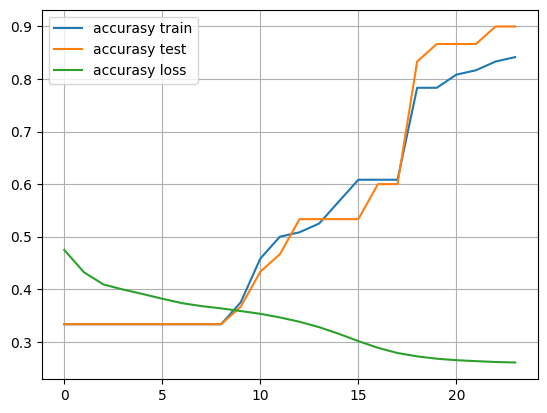

In [ ]:
X, y =  make_IRIS_v2(2,3)
alpha_noise = 0.5
model = Modelo_DRU(qcircuit_1_qubit_mixed, fidelity_cost,
                   epochs = 8, n_clases = 3, n_qubits = 1,
                   features = 2)
paramters_1q, bias_1q = model.fit(X, y)
plt.figure()
plt.plot(model.acc_train, label = 'accurasy train')
plt.plot(model.acc_test, label = 'accurasy test')
plt.plot(model.loss_list, label = 'accurasy loss')
plt.grid()
plt.legend()

[-3.21593942  0.13346807  0.        ]


Epoch: 100%|██████████| 8/8 [06:13<00:00, 46.74s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.        ]


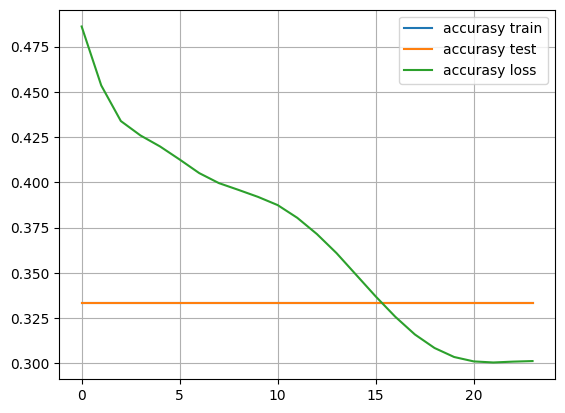

In [ ]:
X, y =  make_IRIS_v2(2,3)
alpha_noise = 0.6
model = Modelo_DRU(qcircuit_1_qubit_mixed, fidelity_cost,
                   epochs = 8, n_clases = 3, n_qubits = 1,
                   features = 2)
paramters_1q, bias_1q = model.fit(X, y)
plt.figure()
plt.plot(model.acc_train, label = 'accurasy train')
plt.plot(model.acc_test, label = 'accurasy test')
plt.plot(model.loss_list, label = 'accurasy loss')
plt.grid()
plt.legend()

[-3.21593942  0.13346807  0.        ]


Epoch: 100%|██████████| 8/8 [06:13<00:00, 46.64s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.        ]


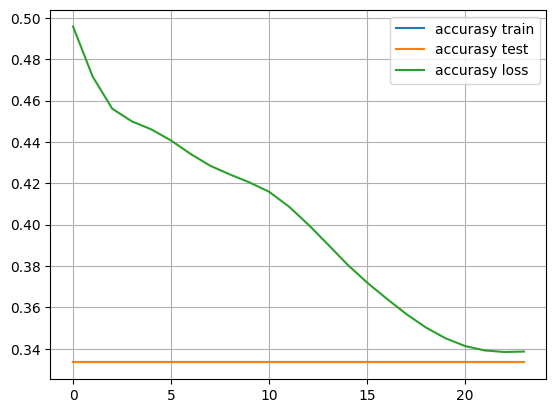

In [ ]:
X, y =  make_IRIS_v2(2,3)
alpha_noise = 0.7
model = Modelo_DRU(qcircuit_1_qubit_mixed, fidelity_cost,
                   epochs = 8, n_clases = 3, n_qubits = 1,
                   features = 2)
paramters_1q, bias_1q = model.fit(X, y)
plt.figure()
plt.plot(model.acc_train, label = 'accurasy train')
plt.plot(model.acc_test, label = 'accurasy test')
plt.plot(model.loss_list, label = 'accurasy loss')
plt.grid()
plt.legend()

[-3.21593942  0.13346807  0.        ]


Epoch: 100%|██████████| 8/8 [06:07<00:00, 45.97s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.        ]


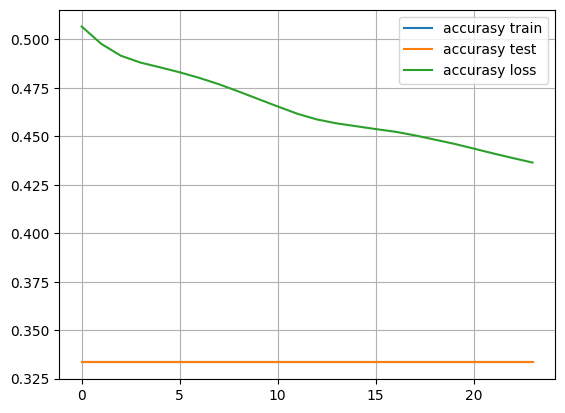

In [ ]:
X, y =  make_IRIS_v2(2,3)
alpha_noise = 0.9
model = Modelo_DRU(qcircuit_1_qubit_mixed, fidelity_cost,
                   epochs = 8, n_clases = 3, n_qubits = 1,
                   features = 2)
paramters_1q, bias_1q = model.fit(X, y)
plt.figure()
plt.plot(model.acc_train, label = 'accurasy train')
plt.plot(model.acc_test, label = 'accurasy test')
plt.plot(model.loss_list, label = 'accurasy loss')
plt.grid()
plt.legend()

## Prueba 1 qubit - cost fidelity - noise = 0

[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [09:08<00:00, 45.71s/it]


[-3.21593942  0.13346807  0.29239675]


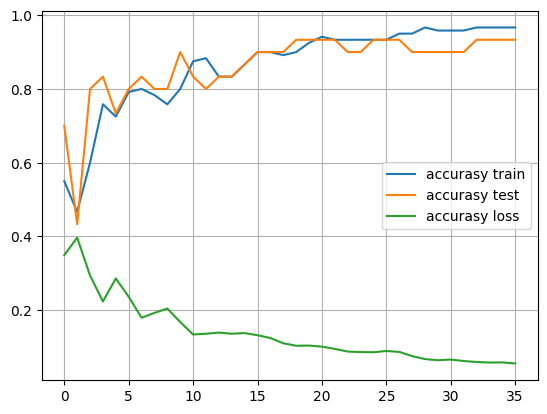

In [ ]:
X, y =  make_IRIS_v2(3,3)
alpha_noise = 0.0
model = Modelo_DRU(qcircuit_1_qubit_mixed, fidelity_cost,
                   epochs = 12, n_clases = 3, n_qubits = 1,
                   features = 3)
paramters_1q, bias_1q = model.fit(X, y)
plt.figure()
plt.plot(model.acc_train, label = 'accurasy train')
plt.plot(model.acc_test, label = 'accurasy test')
plt.plot(model.loss_list, label = 'accurasy loss')
plt.grid()
plt.legend()

[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [09:26<00:00, 47.18s/it]


[-3.21593942  0.13346807  0.29239675]


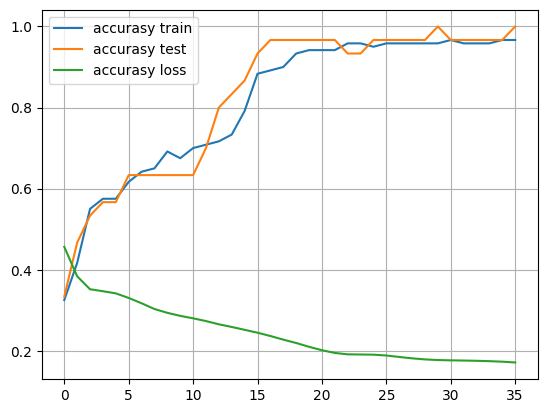

In [ ]:
X, y =  make_IRIS_v2(3,3)
alpha_noise = 0.3
model = Modelo_DRU(qcircuit_1_qubit_mixed, fidelity_cost,
                   epochs = 12, n_clases = 3, n_qubits = 1,
                   features = 3)
paramters_1q, bias_1q = model.fit(X, y)
plt.figure()
plt.plot(model.acc_train, label = 'accurasy train')
plt.plot(model.acc_test, label = 'accurasy test')
plt.plot(model.loss_list, label = 'accurasy loss')
plt.grid()
plt.legend()

## Prueba 1 qubit - cost trace distance - noise = 0

[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [10:53<00:00, 54.47s/it]


[-3.21593942  0.13346807  0.29239675]


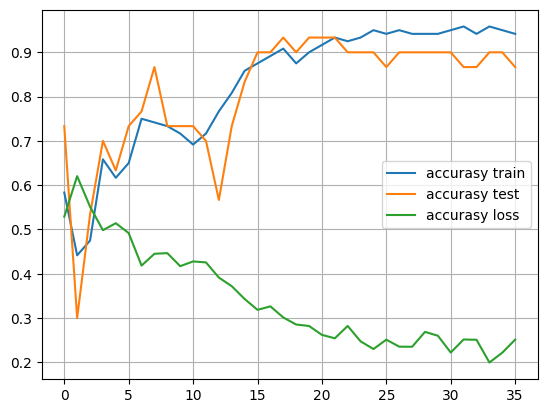

In [ ]:
X, y =  make_IRIS_v2(3,3)
alpha_noise = 0.0
model = Modelo_DRU(qcircuit_1_qubit_mixed, Trace_Distance,
                   epochs = 12, n_clases = 3, n_qubits = 1,
                   features = 3)
paramters_1q, bias_1q = model.fit(X, y)
plt.figure()
plt.plot(model.acc_train, label = 'accurasy train')
plt.plot(model.acc_test, label = 'accurasy test')
plt.plot(model.loss_list, label = 'accurasy loss')
plt.grid()
plt.legend()

[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [10:09<00:00, 50.78s/it]


[-3.21593942  0.13346807  0.29239675]


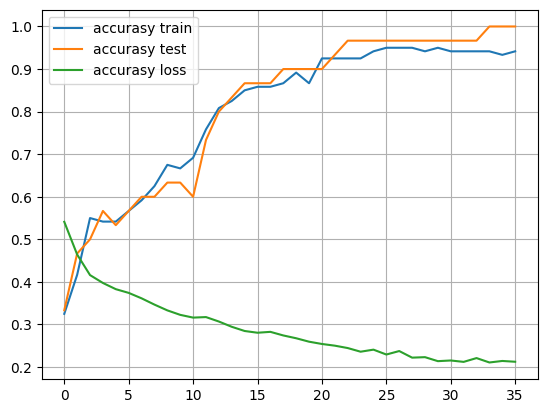

In [ ]:
X, y =  make_IRIS_v2(3,3)
alpha_noise = 0.3
model = Modelo_DRU(qcircuit_1_qubit_mixed, Trace_Distance,
                   epochs = 12, n_clases = 3, n_qubits = 1,
                   features = 3)
paramters_1q, bias_1q = model.fit(X, y)
plt.figure()
plt.plot(model.acc_train, label = 'accurasy train')
plt.plot(model.acc_test, label = 'accurasy test')
plt.plot(model.loss_list, label = 'accurasy loss')
plt.grid()
plt.legend()

[-3.21593942  0.13346807  0.29239675]


Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:   8%|▊         | 1/12 [00:59<10:57, 59.76s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  17%|█▋        | 2/12 [01:52<09:15, 55.55s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  25%|██▌       | 3/12 [02:51<08:35, 57.24s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  33%|███▎      | 4/12 [03:44<07:22, 55.36s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  42%|████▏     | 5/12 [04:41<06:31, 55.98s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  50%|█████     | 6/12 [05:33<05:29, 54.89s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  58%|█████▊    | 7/12 [06:29<04:36, 55.25s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  67%|██████▋   | 8/12 [07:25<03:41, 55.30s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  75%|███████▌  | 9/12 [08:24<02:49, 56.37s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  83%|████████▎ | 10/12 [09:20<01:52, 56.47s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  92%|█████████▏| 11/12 [10:14<00:55, 55.62s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch: 100%|██████████| 12/12 [11:12<00:00, 56.01s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
[-3.21593942  0.13346807  0.29239675]


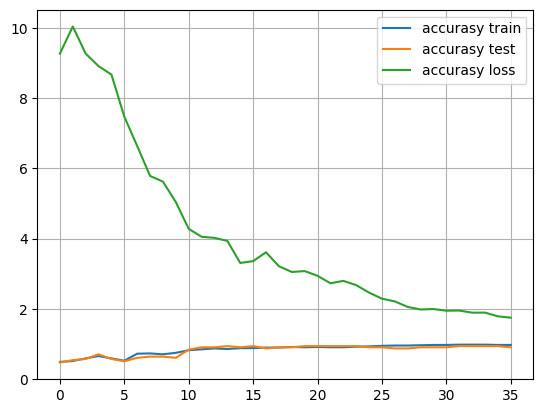

In [ ]:
X, y =  make_IRIS_v2(3,3)
alpha_noise = 0.0
alpha_R = 0.2
model = Modelo_DRU(qcircuit_1_qubit_mixed, Von_Neumman_Divergence,
                   epochs = 12, n_clases = 3, n_qubits = 1,
                   features = 3)
paramters_1q, bias_1q = model.fit(X, y)
plt.figure()
plt.plot(model.acc_train, label = 'accurasy train')
plt.plot(model.acc_test, label = 'accurasy test')
plt.plot(model.loss_list, label = 'accurasy loss')
plt.grid()
plt.legend()

[-3.21593942  0.13346807  0.29239675]


Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:   8%|▊         | 1/12 [00:52<09:41, 52.86s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  17%|█▋        | 2/12 [01:46<08:53, 53.40s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  25%|██▌       | 3/12 [02:36<07:45, 51.75s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  33%|███▎      | 4/12 [03:28<06:55, 51.99s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  42%|████▏     | 5/12 [04:18<05:59, 51.29s/it]


[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]

Epoch:  50%|█████     | 6/12 [05:11<05:10, 51.75s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  58%|█████▊    | 7/12 [06:01<04:16, 51.24s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  67%|██████▋   | 8/12 [06:54<03:27, 51.75s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  75%|███████▌  | 9/12 [07:47<02:36, 52.06s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  83%|████████▎ | 10/12 [08:41<01:45, 52.66s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  92%|█████████▏| 11/12 [09:32<00:52, 52.31s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch: 100%|██████████| 12/12 [10:24<00:00, 52.05s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
[-3.21593942  0.13346807  0.29239675]


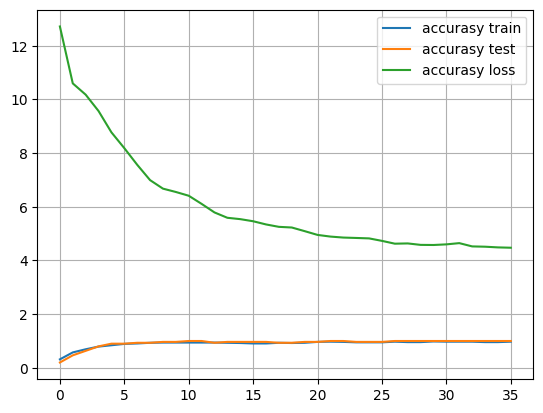

In [ ]:
X, y =  make_IRIS_v2(3,3)
alpha_noise = 0.3
alpha_R = 0.2
model = Modelo_DRU(qcircuit_1_qubit_mixed, Von_Neumman_Divergence,
                   epochs = 12, n_clases = 3, n_qubits = 1,
                   features = 3)
paramters_1q, bias_1q = model.fit(X, y)
plt.figure()
plt.plot(model.acc_train, label = 'accurasy train')
plt.plot(model.acc_test, label = 'accurasy test')
plt.plot(model.loss_list, label = 'accurasy loss')
plt.grid()
plt.legend()

In [ ]:
model.acc_train[-1]

tensor(0.96666667, requires_grad=True)

In [ ]:
model.acc_test[-1]

tensor(0.9, requires_grad=True)

[-3.21593942  0.13346807  0.29239675]


Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Entrada prediccion:
Autograd ArrayBox with value [[0.28822546-5.55111512e-17j 0.39805057-2.16118690e-01j]
 [0.39805057+2.16118690e-01j 0.71177454+2.77555756e-17j]]
Entrada true:
[[0.999+0.j 0.   +0.j]
 [0.   +0.j 0.001+0.j]]
Potencia:
0.5
dm_true_elevada:
[[0.99949987+0.j 0.        +0.j]
 [0.        +0.j 0.03162278+0.j]]
Arg 1 (RHO * P * RHO):
Autograd ArrayBox with value [[0.28793723-5.54556401e-17j 0.01258117-6.83085505e-03j]
 [0.01258117+6.83085505e-03j 0.00071177+2.77555756e-20j]]
Traza 1:
Autograd ArrayBox with value 0.5372606653531177
Arg 2 LOG(*):
Autograd ArrayBox with value 0.5372606653530506
log:
Autograd ArrayBox with value -0.6212718919058847
Divergencia:
Autograd ArrayBox with value 1.2425437838117694

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]

Epoch:   8%|▊         | 1/12 [00:56<10:21, 56.48s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  17%|█▋        | 2/12 [01:53<09:30, 57.06s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  25%|██▌       | 3/12 [02:50<08:31, 56.79s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  33%|███▎      | 4/12 [03:43<07:24, 55.52s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  42%|████▏     | 5/12 [04:39<06:29, 55.63s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  50%|█████     | 6/12 [05:35<05:33, 55.63s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  58%|█████▊    | 7/12 [06:29<04:36, 55.22s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  67%|██████▋   | 8/12 [07:29<03:47, 56.79s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  75%|███████▌  | 9/12 [08:24<02:48, 56.10s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  83%|████████▎ | 10/12 [09:21<01:52, 56.29s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  92%|█████████▏| 11/12 [10:14<00:55, 55.35s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch: 100%|██████████| 12/12 [11:09<00:00, 55.76s/it]


[-3.21593942  0.13346807  0.29239675]


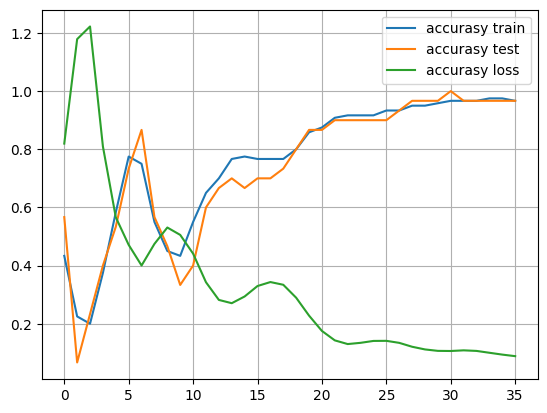

In [ ]:
X, y =  make_IRIS_v2(3,3)
alpha_noise = 0.0
alpha_R = 0.5
model = Modelo_DRU(qcircuit_1_qubit_mixed, Renyi_Divergence,
                   epochs = 12, n_clases = 3, n_qubits = 1,
                   features = 3)
paramters_1q, bias_1q = model.fit(X, y)
plt.figure()
plt.plot(model.acc_train, label = 'accurasy train')
plt.plot(model.acc_test, label = 'accurasy test')
plt.plot(model.loss_list, label = 'accurasy loss')
plt.grid()
plt.legend()

[-3.21593942  0.13346807  0.29239675]


Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:   8%|▊         | 1/12 [00:52<09:39, 52.68s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  17%|█▋        | 2/12 [01:43<08:38, 51.87s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  25%|██▌       | 3/12 [02:36<07:49, 52.12s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  33%|███▎      | 4/12 [03:28<06:56, 52.11s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  42%|████▏     | 5/12 [04:23<06:10, 52.98s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  50%|█████     | 6/12 [05:15<05:17, 52.89s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  58%|█████▊    | 7/12 [06:05<04:19, 51.98s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  67%|██████▋   | 8/12 [06:58<03:28, 52.04s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  75%|███████▌  | 9/12 [07:49<02:35, 51.73s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  83%|████████▎ | 10/12 [08:44<01:45, 52.79s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch:  92%|█████████▏| 11/12 [09:34<00:52, 52.00s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0

Epoch: 100%|██████████| 12/12 [10:28<00:00, 52.35s/it]

Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Hola entre
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
[-3.21593942  0.13346807  0.29239675]


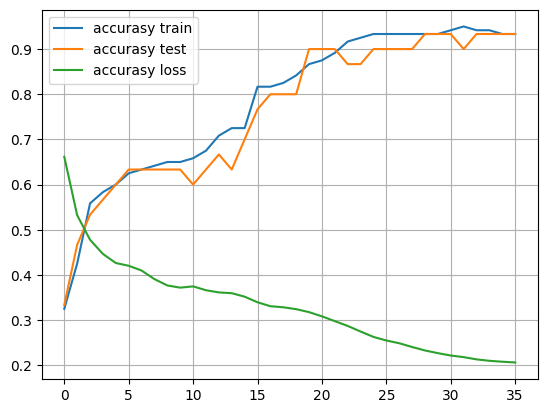

In [ ]:
X, y =  make_IRIS_v2(3,3)
alpha_noise = 0.3
alpha_R = 0.5
model = Modelo_DRU(qcircuit_1_qubit_mixed, Renyi_Divergence,
                   epochs = 12, n_clases = 3, n_qubits = 1,
                   features = 3)
paramters_1q, bias_1q = model.fit(X, y)
plt.figure()
plt.plot(model.acc_train, label = 'accurasy train')
plt.plot(model.acc_test, label = 'accurasy test')
plt.plot(model.loss_list, label = 'accurasy loss')
plt.grid()
plt.legend()

# Prueba para guardar en excel

## 1 qubit

In [ ]:
import pandas as pd

In [ ]:
f_cost_list = [Trace_Distance, fidelity_cost, Von_Neumman_Divergence, Renyi_Divergence]
renyi_alpha = [0.2, 0.5, 2]
Noise_range = [0.0, 0.3, 0.5, 0.9]
N_layers = [3, 5, 10]

X, y =  make_IRIS_v2(3,3)

In [ ]:
alpha_R = 0.5

In [ ]:
# Exportar 1 qubits:
for f_cost_i in f_cost_list:
  for n_l in N_layers:
    for noise_i in Noise_range:
      model = Modelo_DRU(qcircuit_1_qubit_mixed, f_cost_i,
                        epochs = 12, n_clases = 3, n_qubits = 1,
                        features = 3, num_layers = n_l, alpha_noise = noise_i,
                        save_process = False)
      paramters_1q, bias_1q = model.fit(X, y)


## 2 qubits

In [ ]:
import pandas as pd
f_cost_list = [Trace_Distance_v3, fidelity_cost, Von_Neumman_Divergence_v2, Renyi_Divergence_v2]
renyi_alpha = [0.2, 0.5, 2]
Noise_range = [0.0, 0.3, 0.5, 0.9]
N_layers = [3, 5, 10]

X, y =  make_IRIS_v2(3,3)
alpha_R = 0.5

In [ ]:
# Exportar 2 qubits:
for f_cost_i in f_cost_list:
  for n_l in N_layers:
    for noise_i in Noise_range:
      model = Modelo_DRU(qcircuit_2_qubit_mixed, f_cost_i,
                        epochs = 12, n_clases = 3, n_qubits = 2,
                        features = 3, num_layers = n_l, alpha_noise = noise_i,
                        save_process = False, entanglement = False,
                        excel_file_experimente = 'resultados_clasificacion_2q_wo_entanglement.xlsx')
      paramters_2q, bias_2q = model.fit(X, y)

[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:22<00:00,  6.92s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.50      1.00      0.67         9
           2       0.00      0.00      0.00        11

    accuracy                           0.63        30
   macro avg       0.44      0.67      0.53        30
weighted avg       0.43      0.63      0.50        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:20<00:00,  6.70s/it]


              precision    recall  f1-score   support

           0       0.43      1.00      0.61        10
           1       1.00      0.67      0.80         9
           2       1.00      0.09      0.17        11

    accuracy                           0.57        30
   macro avg       0.81      0.59      0.52        30
weighted avg       0.81      0.57      0.50        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:20<00:00,  6.74s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:18<00:00,  6.58s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:08<00:00, 10.69s/it]


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       1.00      0.56      0.71         9
           2       0.92      1.00      0.96        11

    accuracy                           0.87        30
   macro avg       0.90      0.85      0.85        30
weighted avg       0.89      0.87      0.85        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:05<00:00, 10.46s/it]


              precision    recall  f1-score   support

           0       0.62      1.00      0.77        10
           1       1.00      0.56      0.71         9
           2       1.00      0.82      0.90        11

    accuracy                           0.80        30
   macro avg       0.88      0.79      0.79        30
weighted avg       0.88      0.80      0.80        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:07<00:00, 10.60s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:03<00:00, 10.27s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:23<00:00, 21.99s/it]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [03:58<00:00, 19.92s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.62      1.00      0.77        10
           1       0.64      1.00      0.78         9
           2       0.00      0.00      0.00        11

    accuracy                           0.63        30
   macro avg       0.42      0.67      0.52        30
weighted avg       0.40      0.63      0.49        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:02<00:00, 20.17s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [03:59<00:00, 19.94s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [00:50<00:00,  4.24s/it]


              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       0.60      1.00      0.75         9
           2       1.00      0.09      0.17        11

    accuracy                           0.67        30
   macro avg       0.77      0.70      0.58        30
weighted avg       0.78      0.67      0.56        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [00:54<00:00,  4.53s/it]


              precision    recall  f1-score   support

           0       0.50      1.00      0.67        10
           1       1.00      0.89      0.94         9
           2       1.00      0.18      0.31        11

    accuracy                           0.67        30
   macro avg       0.83      0.69      0.64        30
weighted avg       0.83      0.67      0.62        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [00:51<00:00,  4.30s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [00:52<00:00,  4.35s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:27<00:00,  7.33s/it]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:25<00:00,  7.15s/it]


              precision    recall  f1-score   support

           0       0.59      1.00      0.74        10
           1       1.00      0.78      0.88         9
           2       1.00      0.55      0.71        11

    accuracy                           0.77        30
   macro avg       0.86      0.77      0.77        30
weighted avg       0.86      0.77      0.77        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:27<00:00,  7.25s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:26<00:00,  7.25s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:50<00:00, 14.23s/it]


              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      1.00      1.00         9
           2       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:51<00:00, 14.27s/it]


              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      1.00      1.00         9
           2       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:50<00:00, 14.22s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:48<00:00, 14.06s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:16<00:00,  6.38s/it]


              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       0.60      1.00      0.75         9
           2       1.00      0.09      0.17        11

    accuracy                           0.67        30
   macro avg       0.77      0.70      0.58        30
weighted avg       0.78      0.67      0.56        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:19<00:00,  6.59s/it]


              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       1.00      0.78      0.88         9
           2       1.00      0.82      0.90        11

    accuracy                           0.87        30
   macro avg       0.90      0.87      0.87        30
weighted avg       0.90      0.87      0.87        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:21<00:00,  6.81s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:20<00:00,  6.68s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:08<00:00, 10.72s/it]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:06<00:00, 10.50s/it]


              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       1.00      0.78      0.88         9
           2       1.00      0.82      0.90        11

    accuracy                           0.87        30
   macro avg       0.90      0.87      0.87        30
weighted avg       0.90      0.87      0.87        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:07<00:00, 10.62s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:05<00:00, 10.47s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [03:58<00:00, 19.87s/it]


              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      1.00      1.00         9
           2       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [03:59<00:00, 20.00s/it]


              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00         9
           2       1.00      0.82      0.90        11

    accuracy                           0.93        30
   macro avg       0.94      0.94      0.94        30
weighted avg       0.94      0.93      0.93        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [03:56<00:00, 19.73s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [03:57<00:00, 19.80s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:21<00:00,  6.77s/it]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.89      0.94         9
           2       0.92      1.00      0.96        11

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:20<00:00,  6.73s/it]


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       1.00      0.89      0.94         9
           2       1.00      0.82      0.90        11

    accuracy                           0.90        30
   macro avg       0.92      0.90      0.90        30
weighted avg       0.92      0.90      0.90        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:21<00:00,  6.77s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:23<00:00,  7.00s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:07<00:00, 10.59s/it]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:09<00:00, 10.79s/it]


              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.89      0.94         9
           2       1.00      0.91      0.95        11

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:09<00:00, 10.77s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:09<00:00, 10.76s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [03:59<00:00, 19.92s/it]


              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00         9
           2       1.00      0.82      0.90        11

    accuracy                           0.93        30
   macro avg       0.94      0.94      0.94        30
weighted avg       0.94      0.93      0.93        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:00<00:00, 20.04s/it]


              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       1.00      0.78      0.88         9
           2       1.00      0.82      0.90        11

    accuracy                           0.87        30
   macro avg       0.90      0.87      0.87        30
weighted avg       0.90      0.87      0.87        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:00<00:00, 20.01s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [03:59<00:00, 19.95s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]


In [ ]:
import pandas as pd
f_cost_list = [Trace_Distance_v3, fidelity_cost, Von_Neumman_Divergence_v2, Renyi_Divergence_v2]
renyi_alpha = [0.2, 0.5, 2]
Noise_range = [0.0, 0.3, 0.5, 0.9]
N_layers = [3, 5, 10]

X, y =  make_IRIS_v2(3,3)
alpha_R = 0.5

In [ ]:
# Exportar 2 qubits:

for f_cost_i in f_cost_list:
  for n_l in N_layers:
    for noise_i in Noise_range:
      model = Modelo_DRU(qcircuit_2_qubit_mixed, f_cost_i,
                        epochs = 12, n_clases = 3, n_qubits = 2,
                        features = 3, num_layers = n_l, alpha_noise = noise_i,
                        save_process = False, entanglement = True,
                        excel_file_experimente = 'resultados_clasificacion_2q_with_entanglement.xlsx')
      paramters_2q, bias_2q = model.fit(X, y)

[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:20<00:00,  6.73s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.53      1.00      0.69         9
           2       0.00      0.00      0.00        11

    accuracy                           0.63        30
   macro avg       0.43      0.67      0.52        30
weighted avg       0.42      0.63      0.50        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:22<00:00,  6.86s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.45      1.00      0.62        10
           1       0.88      0.78      0.82         9
           2       0.00      0.00      0.00        11

    accuracy                           0.57        30
   macro avg       0.44      0.59      0.48        30
weighted avg       0.41      0.57      0.46        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:21<00:00,  6.78s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:21<00:00,  6.83s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:13<00:00, 11.10s/it]


              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.78      0.88         9
           2       0.92      1.00      0.96        11

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:12<00:00, 11.05s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        10
           1       0.00      0.00      0.00         9
           2       0.90      0.82      0.86        11

    accuracy                           0.63        30
   macro avg       0.47      0.61      0.51        30
weighted avg       0.50      0.63      0.54        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:15<00:00, 11.30s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:12<00:00, 11.02s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:08<00:00, 20.70s/it]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      1.00      0.95         9
           2       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:09<00:00, 20.78s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.62      1.00      0.77        10
           1       0.64      1.00      0.78         9
           2       0.00      0.00      0.00        11

    accuracy                           0.63        30
   macro avg       0.42      0.67      0.52        30
weighted avg       0.40      0.63      0.49        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:16<00:00, 21.40s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:09<00:00, 20.77s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [00:56<00:00,  4.69s/it]


              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.82      1.00      0.90         9
           2       1.00      0.64      0.78        11

    accuracy                           0.87        30
   macro avg       0.88      0.88      0.86        30
weighted avg       0.89      0.87      0.86        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [00:55<00:00,  4.66s/it]


              precision    recall  f1-score   support

           0       0.50      1.00      0.67        10
           1       0.89      0.89      0.89         9
           2       1.00      0.09      0.17        11

    accuracy                           0.63        30
   macro avg       0.80      0.66      0.57        30
weighted avg       0.80      0.63      0.55        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [00:56<00:00,  4.69s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [00:56<00:00,  4.72s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:31<00:00,  7.60s/it]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:31<00:00,  7.66s/it]


              precision    recall  f1-score   support

           0       0.48      1.00      0.65        10
           1       1.00      0.44      0.62         9
           2       1.00      0.45      0.62        11

    accuracy                           0.63        30
   macro avg       0.83      0.63      0.63        30
weighted avg       0.83      0.63      0.63        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:32<00:00,  7.68s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:32<00:00,  7.74s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [03:00<00:00, 15.05s/it]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.89      0.94         9
           2       0.92      1.00      0.96        11

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [03:01<00:00, 15.10s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.62      1.00      0.77        10
           1       0.64      1.00      0.78         9
           2       0.00      0.00      0.00        11

    accuracy                           0.63        30
   macro avg       0.42      0.67      0.52        30
weighted avg       0.40      0.63      0.49        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [03:02<00:00, 15.22s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [03:00<00:00, 15.07s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:23<00:00,  6.92s/it]


              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.82      1.00      0.90         9
           2       1.00      0.64      0.78        11

    accuracy                           0.87        30
   macro avg       0.88      0.88      0.86        30
weighted avg       0.89      0.87      0.86        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:24<00:00,  7.01s/it]


              precision    recall  f1-score   support

           0       0.50      1.00      0.67        10
           1       0.89      0.89      0.89         9
           2       1.00      0.09      0.17        11

    accuracy                           0.63        30
   macro avg       0.80      0.66      0.57        30
weighted avg       0.80      0.63      0.55        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:21<00:00,  6.80s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:25<00:00,  7.08s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:12<00:00, 11.05s/it]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:16<00:00, 11.35s/it]


              precision    recall  f1-score   support

           0       0.50      1.00      0.67        10
           1       1.00      0.44      0.62         9
           2       1.00      0.55      0.71        11

    accuracy                           0.67        30
   macro avg       0.83      0.66      0.66        30
weighted avg       0.83      0.67      0.67        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:12<00:00, 11.04s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:15<00:00, 11.28s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:14<00:00, 21.18s/it]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.89      0.94         9
           2       0.92      1.00      0.96        11

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:08<00:00, 20.69s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.56      1.00      0.71        10
           1       0.75      1.00      0.86         9
           2       0.00      0.00      0.00        11

    accuracy                           0.63        30
   macro avg       0.44      0.67      0.52        30
weighted avg       0.41      0.63      0.50        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:05<00:00, 20.47s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:13<00:00, 21.15s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:26<00:00,  7.20s/it]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:25<00:00,  7.11s/it]


              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.89      0.94         9
           2       1.00      0.91      0.95        11

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:23<00:00,  6.95s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:25<00:00,  7.12s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:11<00:00, 10.93s/it]


              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.90      1.00      0.95         9
           2       1.00      0.73      0.84        11

    accuracy                           0.90        30
   macro avg       0.91      0.91      0.90        30
weighted avg       0.91      0.90      0.90        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:10<00:00, 10.90s/it]


              precision    recall  f1-score   support

           0       0.45      1.00      0.62        10
           1       1.00      0.78      0.88         9
           2       1.00      0.09      0.17        11

    accuracy                           0.60        30
   macro avg       0.82      0.62      0.56        30
weighted avg       0.82      0.60      0.53        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:11<00:00, 10.94s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:17<00:00, 11.49s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:11<00:00, 20.98s/it]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:12<00:00, 21.04s/it]


              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       1.00      0.78      0.88         9
           2       1.00      0.36      0.53        11

    accuracy                           0.70        30
   macro avg       0.84      0.71      0.70        30
weighted avg       0.84      0.70      0.69        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:10<00:00, 20.87s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:11<00:00, 20.99s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]


## 4 qubits

In [ ]:
import pandas as pd
f_cost_list = [Trace_Distance_v3, fidelity_cost, Von_Neumman_Divergence_v2, Renyi_Divergence_v2]
renyi_alpha = [0.2, 0.5, 2]
Noise_range = [0.0, 0.3, 0.5, 0.9]
N_layers = [3, 5, 10]

X, y =  make_IRIS_v2(3,3)
alpha_R = 0.5

NameError: name 'Trace_Distance_v3' is not defined

In [ ]:
# Exportar 2 qubits:

for f_cost_i in f_cost_list:
  for n_l in N_layers:
    for noise_i in Noise_range:
      model = Modelo_DRU(qcircuit_4_qubit_mixed, f_cost_i,
                        epochs = 12, n_clases = 3, n_qubits = 4,
                        features = 3, num_layers = n_l, alpha_noise = noise_i,
                        save_process = False, entanglement = False,
                        excel_file_experimente = 'resultados_clasificacion_4q_wo_entanglement.xlsx')
      paramters_2q, bias_2q = model.fit(X, y)

In [ ]:
import pandas as pd
f_cost_list = [Trace_Distance_v3, fidelity_cost, Von_Neumman_Divergence_v2, Renyi_Divergence_v2]
renyi_alpha = [0.2, 0.5, 2]
Noise_range = [0.0, 0.3, 0.5, 0.9]
N_layers = [3, 5, 10]

X, y =  make_IRIS_v2(3,3)
alpha_R = 0.5

In [ ]:
# Exportar 2 qubits:

for f_cost_i in f_cost_list:
  for n_l in N_layers:
    for noise_i in Noise_range:
      model = Modelo_DRU(qcircuit_4_qubit_mixed, f_cost_i,
                        epochs = 12, n_clases = 3, n_qubits = 4,
                        features = 3, num_layers = n_l, alpha_noise = noise_i,
                        save_process = False, entanglement = True,
                        excel_file_experimente = 'resultados_clasificacion_4q_with_entanglement.xlsx')
      paramters_2q, bias_2q = model.fit(X, y)

[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:32<00:00,  7.68s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.50      1.00      0.67         9
           2       0.00      0.00      0.00        11

    accuracy                           0.63        30
   macro avg       0.44      0.67      0.53        30
weighted avg       0.43      0.63      0.50        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:31<00:00,  7.64s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.62      1.00      0.77        10
           1       0.64      1.00      0.78         9
           2       0.00      0.00      0.00        11

    accuracy                           0.63        30
   macro avg       0.42      0.67      0.52        30
weighted avg       0.40      0.63      0.49        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:31<00:00,  7.64s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:30<00:00,  7.54s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:30<00:00, 12.50s/it]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      1.00      0.95         9
           2       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:30<00:00, 12.54s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.82      1.00      0.90         9
           2       0.00      0.00      0.00        11

    accuracy                           0.63        30
   macro avg       0.45      0.67      0.53        30
weighted avg       0.42      0.63      0.50        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:29<00:00, 12.44s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:30<00:00, 12.54s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:49<00:00, 24.15s/it]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.47      1.00      0.64         9
           2       1.00      0.09      0.17        11

    accuracy                           0.67        30
   macro avg       0.82      0.70      0.60        30
weighted avg       0.84      0.67      0.59        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:50<00:00, 24.22s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.42      1.00      0.59        10
           1       0.00      0.00      0.00         9
           2       0.83      0.45      0.59        11

    accuracy                           0.50        30
   macro avg       0.42      0.48      0.39        30
weighted avg       0.44      0.50      0.41        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:52<00:00, 24.36s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:50<00:00, 24.19s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:07<00:00,  5.60s/it]


              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.90      1.00      0.95         9
           2       1.00      0.73      0.84        11

    accuracy                           0.90        30
   macro avg       0.91      0.91      0.90        30
weighted avg       0.91      0.90      0.90        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:07<00:00,  5.63s/it]


              precision    recall  f1-score   support

           0       0.56      1.00      0.71        10
           1       0.90      1.00      0.95         9
           2       1.00      0.18      0.31        11

    accuracy                           0.70        30
   macro avg       0.82      0.73      0.66        30
weighted avg       0.82      0.70      0.64        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:07<00:00,  5.62s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:07<00:00,  5.60s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:52<00:00,  9.39s/it]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:52<00:00,  9.41s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.82      1.00      0.90         9
           2       0.00      0.00      0.00        11

    accuracy                           0.63        30
   macro avg       0.45      0.67      0.53        30
weighted avg       0.42      0.63      0.50        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:52<00:00,  9.40s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:52<00:00,  9.41s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [03:47<00:00, 18.97s/it]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      1.00      0.95         9
           2       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [03:48<00:00, 19.07s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       0.00      0.00      0.00         9
           2       0.91      0.91      0.91        11

    accuracy                           0.67        30
   macro avg       0.48      0.64      0.53        30
weighted avg       0.51      0.67      0.56        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [03:47<00:00, 18.93s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [03:46<00:00, 18.90s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:32<00:00,  7.71s/it]


              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.90      1.00      0.95         9
           2       1.00      0.73      0.84        11

    accuracy                           0.90        30
   macro avg       0.91      0.91      0.90        30
weighted avg       0.91      0.90      0.90        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:31<00:00,  7.66s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.48      1.00      0.65        10
           1       1.00      1.00      1.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.63        30
   macro avg       0.49      0.67      0.55        30
weighted avg       0.46      0.63      0.52        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:32<00:00,  7.70s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:32<00:00,  7.70s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:32<00:00, 12.67s/it]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:31<00:00, 12.63s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        10
           1       0.90      1.00      0.95         9
           2       0.00      0.00      0.00        11

    accuracy                           0.63        30
   macro avg       0.47      0.67      0.54        30
weighted avg       0.44      0.63      0.51        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:30<00:00, 12.53s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:30<00:00, 12.55s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:53<00:00, 24.43s/it]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      1.00      0.95         9
           2       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:52<00:00, 24.38s/it]


              precision    recall  f1-score   support

           0       0.50      1.00      0.67        10
           1       1.00      0.22      0.36         9
           2       1.00      0.73      0.84        11

    accuracy                           0.67        30
   macro avg       0.83      0.65      0.62        30
weighted avg       0.83      0.67      0.64        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:51<00:00, 24.33s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:53<00:00, 24.45s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:33<00:00,  7.79s/it]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:32<00:00,  7.72s/it]


              precision    recall  f1-score   support

           0       0.48      1.00      0.65        10
           1       1.00      0.89      0.94         9
           2       1.00      0.09      0.17        11

    accuracy                           0.63        30
   macro avg       0.83      0.66      0.58        30
weighted avg       0.83      0.63      0.56        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:33<00:00,  7.81s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [01:34<00:00,  7.84s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:31<00:00, 12.65s/it]


              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.89      0.89      0.89         9
           2       1.00      0.91      0.95        11

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:31<00:00, 12.63s/it]


              precision    recall  f1-score   support

           0       0.50      1.00      0.67        10
           1       1.00      0.89      0.94         9
           2       1.00      0.18      0.31        11

    accuracy                           0.67        30
   macro avg       0.83      0.69      0.64        30
weighted avg       0.83      0.67      0.62        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:32<00:00, 12.69s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [02:33<00:00, 12.81s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:53<00:00, 24.50s/it]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      1.00      0.95         9
           2       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:55<00:00, 24.61s/it]


              precision    recall  f1-score   support

           0       0.59      1.00      0.74        10
           1       0.86      0.67      0.75         9
           2       1.00      0.55      0.71        11

    accuracy                           0.73        30
   macro avg       0.82      0.74      0.73        30
weighted avg       0.82      0.73      0.73        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:53<00:00, 24.45s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
[-3.21593942  0.13346807  0.29239675]


Epoch: 100%|██████████| 12/12 [04:53<00:00, 24.44s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loca

              precision    recall  f1-score   support

           0       0.33      1.00      0.50        10
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30

[-3.21593942  0.13346807  0.29239675]
